### Content
- [Problem Statement](#Problem-Statement)
- [Libraries Used](#Importing-Libraries)
- [Data Used](#Load-Data)
- [EDA](#EDA)
- [Prediction for Kaggle Submission](#Make-Prediction-Using-"Test.csv"-for-Kaggle-Submission)

### Problem Statement
<br>
New buyers of residential properties usually are unfamiliar if a residential is over-priced or under-priced. You are tasked to create a model that will help buyers to evaluate the reasonable selling price for residential properties so that they are not over-paying for them and know when a property is a good deal.

### Importing Libraries

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

### Functions Definition

In [66]:
def boxplot_subfig(x, feature_list, data, row, col, figure_size=(20, 15)):
    # This function plots boxplot for each feature as as subfigure
    # To make all row and col positive values
    row = abs(row)
    col = abs(col)
    
    # Declare variables
    i = 0
    fig, ax = plt.subplots(figsize=figure_size, nrows=row, ncols=col)

    # Loop through feature_list to create subplot for each feature    
    for feature in feature_list:
        if row>1 and col>1:
            sns.boxplot(x=x, y=feature, data=data, ax=ax[math.floor(i/3), i%3])
        elif row==1 and col==1:
            sns.boxplot(x=x, y=feature, data=data, ax=ax)
        else:
            sns.boxplot(x=x, y=feature, data=data, ax=ax[i])
        i+=1
    
    # Set plot title
    fig.suptitle('Relationship of Features With Sale Price', fontsize = 20, fontweight = 'bold')

    
def categories_spread(feature_list, data, row, col, figure_size=(20, 15)):
    # This function plots boxplot for each feature as as subfigure
    
    # Declare variables
    i = 0
    fig, ax = plt.subplots(figsize=(20, 15), nrows=row, ncols=col)
    
    # Loop through feature_list to create subplot for each feature
    for feature in feature_list:
        sns.barplot(x=data[feature].value_counts(normalize=True),y=data[feature].value_counts().index, ax=ax[math.floor(i/3), i%3])
        i+=1
        
    # Set plot title
    fig.suptitle('Categories By % of Population', fontsize = 20, fontweight = 'bold')

def boxplot_count_subplot(x, feature_list, data, row, col, figure_size=(20, 15)):
    # This function plots boxplot and count bar graph for each feature as as subplots
    # Declaring and initialising variables
    fig, ax = plt.subplots(figsize=figure_size, nrows=2, ncols = 3)
    i = 0
    
    # Loop through feature_list to create subplot for each feature
    for feature in feature_list:
        sns.boxplot(x=x, y=feature, data=data, ax=ax[0,i], order=data[feature].value_counts().index)
        sns.barplot(x=data[feature].value_counts(),y=data[feature].value_counts().index, ax=ax[1, i])
        i+=1
        
        
def corr_heatmap(data):
    plt.figure(figsize=(8, 8))
    pearson_corr = data.corr()
    mask = np.zeros_like(pearson_corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(pearson_corr, annot=True, mask=mask, vmax = 1, vmin = -1)

def scatter_plot_by_cat(data, x, y, features_list, rows, cols, figsize=(12,12)):
    '''
    data: DataFrame of the data
    x: String. Numeric common feature to be set as x axis of all subplots
    y: String. Numeric common feature to be set as x axis of all subplots
    Features: List of strings to be set as hue in scatterplot
    rows: No of rows
    cols: No of cols
    figsize: tuple (Width, Height)
    '''
    fig, ax = plt.subplots(figsize=figsize, nrows=rows, ncols=cols)
    for i in range(len(features_list)):
        if rows > 1 and cols > 1:
            sns.scatterplot(x=x, y=y, data=data, hue=features_list[i], ax=ax[int(i/cols),i%cols])
            ax[int(i/cols),i%cols].set_title(f"{y} vs {x} By {features_list[i]}")
        else:
            sns.scatterplot(x=x, y=y, data=data, hue=features_list[i], ax=ax[i])
            ax[i].set_title(f"{y} vs {x} By {features_list[i]}")
    plt.suptitle(f"{y} vs {x} By Various Features")
    
    
def clean(data):
    data=data.copy()
    # Converting MS SubClass, Overall Qual, Overall Cond to string as it is categorical data
    data['MS SubClass'] = data['MS SubClass'].astype('str')
    data['Overall Qual'] = data['Overall Qual'].astype('str')
    data['Overall Cond'] = data['Overall Qual'].astype('str')
    
    # Replace all 'NaN' from object columns
    for column in data.columns:
        if data[column].dtype == 'O':
            if column in ['Mas Vnr Type', 'Misc Feature']:
                data[column].replace(np.nan, 'None', inplace=True)
            else:
                data[column].replace(np.nan, 'n.a', inplace=True)
            
    # Ensuring that related basemenet data is set to 0 if BsmtFin Type 1 is n.a
    for feature in ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 
                    'Bsmt Full Bath', 'Bsmt Half Bath']:
        data.loc[data['BsmtFin Type 1'] == 'n.a', feature] = 0
           
    # Set 0 for rows with house style as 1story but 2nd level SF is not 0
    data.loc[(data['House Style'] == '1Story') & (data['2nd Flr SF'] > 0), '2nd Flr SF'] = 0
    
    # Fill missing data Garage Area/Cars as 0
    data.loc[data['Garage Qual'] == 'n.a', ['Garage Cars', 'Garage Area']]=0
    
    # Set Mas Vnr Area to 0 for rows where 'Mas Vnr Type' is None 
    data.loc[(data['Mas Vnr Type']=='None'), 'Mas Vnr Area'] = 0
    
    # Ensuring that Mas Vnr Area is 0 if Mas Vnr Type is 'n.a'
    #data.loc[data['Mas Vnr Type'] == 'n.a', 'Mas Vnr Area'] = 0
      
    return data


def prep(data):
    data=data.copy()
    # Engineering new numeric features
    data['Total SF'] = data['Total Bsmt SF'] + data['1st Flr SF'] + data['2nd Flr SF']
    data['Total SF**2'] = (data['Total Bsmt SF'] + data['1st Flr SF'] + data['2nd Flr SF'])**2
    data['Total 1_2 SF'] = data['1st Flr SF'] + data['2nd Flr SF']
    data['Total 1_2 SF**2'] = (data['1st Flr SF'] + data['2nd Flr SF'])**2
    data['No Of Bath'] = data['Bsmt Full Bath'] + (data['Bsmt Half Bath']/2) + data['Full Bath'] + (data['Half Bath']/2)
    data['Total Porch SF'] = data['Open Porch SF'] + data['Enclosed Porch'] + data['3Ssn Porch'] + data['Screen Porch']
    data['Amenities SF'] = data['Pool Area'] + data['Wood Deck SF'] + data['Garage Area']
    data['Age_Sold'] = data['Yr Sold'] - data['Year Built']
    data['Remod/Add Age_Sold'] = data['Yr Sold'] - data['Year Remod/Add']
    data['Lot Area_Log'] = np.log(data['Lot Area'])
    data['Mas Vnr Area_sqrt'] = np.sqrt(data['Mas Vnr Area'])
    
    # Engineering new categorical features
    data['Condition'] = data['Condition 1'] + data['Condition 2']
    data['Exterior'] = data['Exterior 1st'] + data['Exterior 2nd']
    data['BsmtFin'] = data['BsmtFin Type 1'] + data['BsmtFin Type 2']
    for feature in ['Mas Vnr Area', 'Total Bsmt SF', '2nd Flr SF', 'Garage Area', 'Wood Deck SF', 
                    'Total Porch SF', 'Pool Area', 'Age_Sold']:
        data[feature + ' Available'] = data[feature].apply(lambda x: 1 if x > 0 else 0)
    
    
    # Transform 'SalePrice' if available
    if 'SalePrice' in data.columns:
        data['SalePrice_Log'] = np.log(data['SalePrice'])
    
    # Dropping Lot Frontage and Garage Yr Blt
    data.drop(columns = ['Lot Frontage', 'Garage Yr Blt'], inplace=True)

    
    # Dropping data due to abnormal price for size of lot
    #data.drop(index = data[data['1st Flr SF']>4000].index, inplace=True)
    
    # Polym
    
    
    return data

def residual_plot(model, predictors, target, fig_title):
    plt.scatter(model.predict(predictors), target - model.predict(predictors))
    plt.axhline(y = 0, color='red')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residual (Target - Predicted)')
    plt.title(fig_title)


def output_result(model_type, features, Train_R2, Train_CV_R2, Test_R2, Train_RMSE, Train_CV_RMSE, Test_RMSE):
    results = pd.DataFrame([[model_type, str(features), Train_R2, Train_CV_R2, Test_R2, Train_RMSE, Train_CV_RMSE, Test_RMSE]])
    results.to_csv(r'..\datasets\results.csv', index=False, mode='a', header=False)

### Import Data and Clean Data

#### Read Data

In [67]:
# Read train.csv
data_ori = pd.read_csv('../datasets/train.csv')
data = data_ori.copy()

# Read test.csv
test = pd.read_csv('../datasets/test.csv')

In [68]:
# Determing the shape of the training dataset
data.shape

(2051, 81)

In [69]:
data.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

#### Checking for missing data

In [70]:
# Calculating the percentage of rows with missing data for each features
temp = data.isnull().sum()
for i in range(len(temp)):
    print(temp.index[i], ': ',  temp[i], ', Percentage of All Rows', ": ", 
          temp[i]/data.shape[0], ', Data Type: ', data.dtypes[i])

Id :  0 , Percentage of All Rows :  0.0 , Data Type:  int64
PID :  0 , Percentage of All Rows :  0.0 , Data Type:  int64
MS SubClass :  0 , Percentage of All Rows :  0.0 , Data Type:  int64
MS Zoning :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Lot Frontage :  330 , Percentage of All Rows :  0.16089712335446124 , Data Type:  float64
Lot Area :  0 , Percentage of All Rows :  0.0 , Data Type:  int64
Street :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Alley :  1911 , Percentage of All Rows :  0.931740614334471 , Data Type:  object
Lot Shape :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Land Contour :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Utilities :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Lot Config :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Land Slope :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Neighborhood :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Condition 1 :  0 , Perce

- Multiple object type columns like 'Alley' has high percentage of NaN. 
- NA in the original file was was converted to NaN after being read by Pandas
    - NA originally meant that that dwelling does not have that feature 
    - Hence need to replace 'NaN' with 'n.a' so that NaN is not treated as missing data for those categorical columns

In [71]:
# Replace all 'NaN' from object columns
for column in data.columns:
    if data[column].dtype == 'O':
        data[column].replace(np.nan, 'n.a', inplace=True)

In [72]:
# Check Garage Area and Garage Cars
data[data['Garage Area'].isnull()][['Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Area', 'Garage Cars', 'Garage Qual', 'Garage Cond']]

Garage Type  Garage Yr Blt Garage Finish  Garage Area  Garage Cars  \
1712      Detchd            NaN           n.a          NaN          NaN   

     Garage Qual Garage Cond  
1712         n.a         n.a

To drop row since there is a garage (garage type is not NA) but other garage related information is missing.

Text(0.5, 1.0, 'Histogram Showing Majority of Garage Built in Same Year as House')

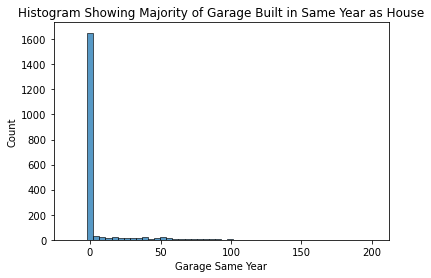

In [73]:
# Checking how many garages are built in same year as house
temp = data[['Year Built', 'Year Remod/Add', 'Garage Yr Blt']].copy()
temp['Garage Same Year'] = temp['Garage Yr Blt'] - temp['Year Built']
sns.histplot(temp['Garage Same Year'], bins = 50)
plt.title('Histogram Showing Majority of Garage Built in Same Year as House')

- Most garages are built in the same year as the house

Text(0.5, 1.0, 'Histogram of Garage Yr Blt With/Without Imputed Data')

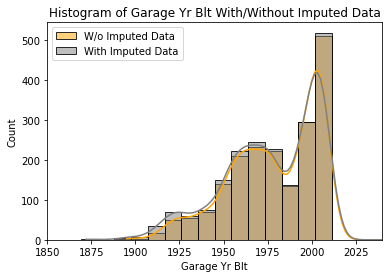

In [74]:
# To check Garage Yr Blt with imputed data vs without imputed data
sns.histplot(temp['Garage Yr Blt'], bins = 20, label='W/o Imputed Data', kde=True, color='orange', binrange=(1850, 2040))
sns.histplot(temp['Garage Yr Blt'].fillna(value=temp['Year Built']), bins = 20, label='With Imputed Data', kde=True, color='grey', binrange=(1850, 2040))
plt.xlim(1850, 2040)
plt.legend()
plt.title('Histogram of Garage Yr Blt With/Without Imputed Data')

- Histogram did not change significantly by imputing Garage Yr Blt with Year Built data

In [75]:
# Checking correlation between Garage Yr Blt and Year Built
data[['Garage Yr Blt', 'Year Built']].corr()

Garage Yr Blt  Year Built
Garage Yr Blt       1.000000    0.825316
Year Built          0.825316    1.000000

- To not use Garage Yr Blt due to high correlation with Year Built and missing data

In [76]:
# To check if there is a basement for the missing data row
data[data['BsmtFin SF 1'].isnull()][['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Full Bath', 'Bsmt Half Bath']]

BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF BsmtFin Type 1  \
1327           NaN           NaN          NaN            NaN            n.a   

     BsmtFin Type 2  Bsmt Full Bath  Bsmt Half Bath  
1327            n.a             NaN             NaN

In [77]:
# Set basement numeric features to 0 for row with missing value
for feature in ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']:
    data[feature].fillna(value=0, inplace=True)

In [78]:
for feature in ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']:
    data.loc[data['BsmtFin Type 1'] == 'n.a', feature] = 0

Since there is no basement, set 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF' to 0.

In [79]:
# Checking if Mas Vnr Area is NA due to missing data or there is no Mas Vnr
temp = data[['Mas Vnr Type', 'Mas Vnr Area']]
temp[temp['Mas Vnr Area'].isnull()]

Mas Vnr Type  Mas Vnr Area
22            n.a           NaN
41            n.a           NaN
86            n.a           NaN
212           n.a           NaN
276           n.a           NaN
338           n.a           NaN
431           n.a           NaN
451           n.a           NaN
591           n.a           NaN
844           n.a           NaN
913           n.a           NaN
939           n.a           NaN
1025          n.a           NaN
1244          n.a           NaN
1306          n.a           NaN
1430          n.a           NaN
1434          n.a           NaN
1606          n.a           NaN
1699          n.a           NaN
1815          n.a           NaN
1820          n.a           NaN
1941          n.a           NaN

In [80]:
# Fill missing data Mas Vnr Area as 0
data.loc[data['Mas Vnr Type'] == 'n.a', 'Mas Vnr Area'] = 0

In [81]:
# Checking if Garage Cars/Area is NA due to missing data or there is no Garage
data[data['Garage Cars'].isnull()][['Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond']]

Garage Cars  Garage Area Garage Qual Garage Cond
1712          NaN          NaN         n.a         n.a

In [82]:
# Fill missing data Garage Area/Cars as 0
data.loc[data['Garage Qual'] == 'n.a', ['Garage Cars', 'Garage Area']]=0
data.iloc[1712, :][['Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond']]

Garage Cars    0.0
Garage Area    0.0
Garage Qual    n.a
Garage Cond    n.a
Name: 1712, dtype: object

In [83]:
# Checking status of missing data for each feature
temp = data.isnull().sum()
for i in range(len(temp)):
    print(temp.index[i], ': ',  temp[i], ', Percentage of All Rows', ": ", 
          temp[i]/data.shape[0], ', Type: ', data.dtypes[i])

Id :  0 , Percentage of All Rows :  0.0 , Type:  int64
PID :  0 , Percentage of All Rows :  0.0 , Type:  int64
MS SubClass :  0 , Percentage of All Rows :  0.0 , Type:  int64
MS Zoning :  0 , Percentage of All Rows :  0.0 , Type:  object
Lot Frontage :  330 , Percentage of All Rows :  0.16089712335446124 , Type:  float64
Lot Area :  0 , Percentage of All Rows :  0.0 , Type:  int64
Street :  0 , Percentage of All Rows :  0.0 , Type:  object
Alley :  0 , Percentage of All Rows :  0.0 , Type:  object
Lot Shape :  0 , Percentage of All Rows :  0.0 , Type:  object
Land Contour :  0 , Percentage of All Rows :  0.0 , Type:  object
Utilities :  0 , Percentage of All Rows :  0.0 , Type:  object
Lot Config :  0 , Percentage of All Rows :  0.0 , Type:  object
Land Slope :  0 , Percentage of All Rows :  0.0 , Type:  object
Neighborhood :  0 , Percentage of All Rows :  0.0 , Type:  object
Condition 1 :  0 , Percentage of All Rows :  0.0 , Type:  object
Condition 2 :  0 , Percentage of All Rows :  0

- To drop 'Lot Frontage' due to large percentage of missing data (16%) and it might be risky to impute the data.

In [84]:
# Dropping Lot Frontage and Garage Yr Blt
data.drop(columns = ['Lot Frontage', 'Garage Yr Blt'], inplace=True)

# Dropping NA rows
data.dropna(inplace=True)


#### Checking for abnormal data

In [85]:
# Checking for abnormalities in Min and Max Values for first 40 features
data.iloc[:, 0:40].describe()

Id           PID  MS SubClass       Lot Area  Overall Qual  \
count  2051.000000  2.051000e+03  2051.000000    2051.000000   2051.000000   
mean   1474.033642  7.135900e+08    57.008776   10065.208191      6.112140   
std     843.980841  1.886918e+08    42.824223    6742.488909      1.426271   
min       1.000000  5.263011e+08    20.000000    1300.000000      1.000000   
25%     753.500000  5.284581e+08    20.000000    7500.000000      5.000000   
50%    1486.000000  5.354532e+08    50.000000    9430.000000      6.000000   
75%    2198.000000  9.071801e+08    70.000000   11513.500000      7.000000   
max    2930.000000  9.241520e+08   190.000000  159000.000000     10.000000   

       Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  BsmtFin SF 1  \
count   2051.000000  2051.000000     2051.000000   2051.000000   2051.000000   
mean       5.562165  1971.708922     1984.190151     98.626524    442.084837   
std        1.104497    30.177889       21.036250    174.324690    461.195041   
min        1.000000  1872.000000     1950.000000      0.000000      0.000000   
25%        5.000000  1953.500000     1964.500000      0.000000      0.000000   
50%        5.000000  1974.000000     1993.000000      0.000000    368.000000   
75%        6.000000  2001.000000     2004.000000    159.000000    733.500000   
max        9.000000  2010.000000     2010.000000   1600.000000   5644.000000   

       BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  
count   2051.000000  2051.000000    2051.000000  
mean      47.935641   567.451487    1057.471965  
std      164.964052   445.022846     449.908003  
min        0.000000     0.000000       0.000000  
25%        0.000000   220.000000     793.000000  
50%        0.000000   474.000000     994.000000  
75%        0.000000   811.000000    1318.500000  
max     1474.000000  2336.000000    6110.000000

- No abnormalities

In [86]:
# Checking for abnormalities in Min and Max Values for next 20 features
data.iloc[:, 41:60].describe()

1st Flr SF   2nd Flr SF  Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  \
count  2051.000000  2051.000000      2051.000000  2051.000000     2051.000000   
mean   1164.488055   329.329108         5.512921  1499.330083        0.427109   
std     396.446923   425.671046        51.068870   500.447829        0.522589   
min     334.000000     0.000000         0.000000   334.000000        0.000000   
25%     879.500000     0.000000         0.000000  1129.000000        0.000000   
50%    1093.000000     0.000000         0.000000  1444.000000        0.000000   
75%    1405.000000   692.500000         0.000000  1728.500000        1.000000   
max    5095.000000  1862.000000      1064.000000  5642.000000        3.000000   

       Bsmt Half Bath    Full Bath    Half Bath  Bedroom AbvGr  Kitchen AbvGr  \
count     2051.000000  2051.000000  2051.000000    2051.000000    2051.000000   
mean         0.063384     1.577279     0.371039       2.843491       1.042906   
std          0.251590     0.549279     0.501043       0.826618       0.209790   
min          0.000000     0.000000     0.000000       0.000000       0.000000   
25%          0.000000     1.000000     0.000000       2.000000       1.000000   
50%          0.000000     2.000000     0.000000       3.000000       1.000000   
75%          0.000000     2.000000     1.000000       3.000000       1.000000   
max          2.000000     4.000000     2.000000       8.000000       3.000000   

       TotRms AbvGrd   Fireplaces  
count    2051.000000  2051.000000  
mean        6.435885     0.590931  
std         1.560225     0.638516  
min         2.000000     0.000000  
25%         5.000000     0.000000  
50%         6.000000     1.000000  
75%         7.000000     1.000000  
max        15.000000     4.000000

- No abnormalities

In [87]:
# Checking for abnormalities in Min and Max Values for next 20 features
data.iloc[:, 60:82].describe()

Garage Cars  Garage Area  Wood Deck SF  Open Porch SF  Enclosed Porch  \
count  2051.000000  2051.000000   2051.000000    2051.000000     2051.000000   
mean      1.775719   473.440761     93.833740      47.556802       22.571916   
std       0.765357   216.135102    128.549416      66.747241       59.845110   
min       0.000000     0.000000      0.000000       0.000000        0.000000   
25%       1.000000   319.000000      0.000000       0.000000        0.000000   
50%       2.000000   480.000000      0.000000      27.000000        0.000000   
75%       2.000000   576.000000    168.000000      70.000000        0.000000   
max       5.000000  1418.000000   1424.000000     547.000000      432.000000   

        3Ssn Porch  Screen Porch    Pool Area      Misc Val      Mo Sold  \
count  2051.000000   2051.000000  2051.000000   2051.000000  2051.000000   
mean      2.591419     16.511458     2.397855     51.574354     6.219893   
std      25.229615     57.374204    37.782570    573.393985     2.744736   
min       0.000000      0.000000     0.000000      0.000000     1.000000   
25%       0.000000      0.000000     0.000000      0.000000     4.000000   
50%       0.000000      0.000000     0.000000      0.000000     6.000000   
75%       0.000000      0.000000     0.000000      0.000000     8.000000   
max     508.000000    490.000000   800.000000  17000.000000    12.000000   

           Yr Sold      SalePrice  
count  2051.000000    2051.000000  
mean   2007.775719  181469.701609  
std       1.312014   79258.659352  
min    2006.000000   12789.000000  
25%    2007.000000  129825.000000  
50%    2008.000000  162500.000000  
75%    2009.000000  214000.000000  
max    2010.000000  611657.000000

- No abnormalities

#### Checking data types

In [88]:
# Checking data types of each colunms
data.dtypes[0:20]

Id               int64
PID              int64
MS SubClass      int64
MS Zoning       object
Lot Area         int64
Street          object
Alley           object
Lot Shape       object
Land Contour    object
Utilities       object
Lot Config      object
Land Slope      object
Neighborhood    object
Condition 1     object
Condition 2     object
Bldg Type       object
House Style     object
Overall Qual     int64
Overall Cond     int64
Year Built       int64
dtype: object

In [89]:
data.dtypes[20:40]

Year Remod/Add      int64
Roof Style         object
Roof Matl          object
Exterior 1st       object
Exterior 2nd       object
Mas Vnr Type       object
Mas Vnr Area      float64
Exter Qual         object
Exter Cond         object
Foundation         object
Bsmt Qual          object
Bsmt Cond          object
Bsmt Exposure      object
BsmtFin Type 1     object
BsmtFin SF 1      float64
BsmtFin Type 2     object
BsmtFin SF 2      float64
Bsmt Unf SF       float64
Total Bsmt SF     float64
Heating            object
dtype: object

In [90]:
data.dtypes[40:60]

Heating QC          object
Central Air         object
Electrical          object
1st Flr SF           int64
2nd Flr SF           int64
Low Qual Fin SF      int64
Gr Liv Area          int64
Bsmt Full Bath     float64
Bsmt Half Bath     float64
Full Bath            int64
Half Bath            int64
Bedroom AbvGr        int64
Kitchen AbvGr        int64
Kitchen Qual        object
TotRms AbvGrd        int64
Functional          object
Fireplaces           int64
Fireplace Qu        object
Garage Type         object
Garage Finish       object
dtype: object

In [91]:
data.dtypes[60:79]

Garage Cars       float64
Garage Area       float64
Garage Qual        object
Garage Cond        object
Paved Drive        object
Wood Deck SF        int64
Open Porch SF       int64
Enclosed Porch      int64
3Ssn Porch          int64
Screen Porch        int64
Pool Area           int64
Pool QC            object
Fence              object
Misc Feature       object
Misc Val            int64
Mo Sold             int64
Yr Sold             int64
Sale Type          object
SalePrice           int64
dtype: object

In [92]:
# Converting MS SubClass, PID to string as it is categorical data
# Converting Overall Qual, Overall Cond to string as it is ordinal data
for feature in ['MS SubClass', 'PID', 'Overall Qual', 'Overall Cond']:
    data[feature] = data[feature].astype('str')

#### Checking if 2nd Floor SF is 0 for 1Story House

Text(0.5, 1.0, '2nd Floor Area by House Style')

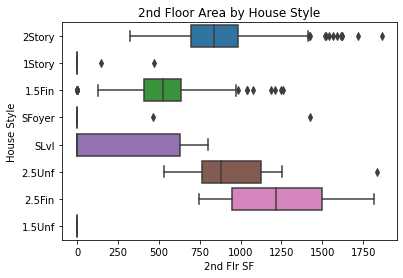

In [93]:
# Checking if 1Storey has raws with 2nd Flr SF > 0
sns.boxplot(x = '2nd Flr SF', y='House Style', data=data)
plt.title('2nd Floor Area by House Style')

In [94]:
data[(data['House Style'] == '1Story') & (data['2nd Flr SF'] > 0)]

Id        PID MS SubClass MS Zoning  Lot Area Street Alley Lot Shape  \
513  2006  903201090          40        RL      6854   Pave   n.a       Reg   
782  2000  902401030          40        RM      5400   Pave  Pave       Reg   

    Land Contour Utilities  ... Screen Porch Pool Area Pool QC Fence  \
513          Bnk    AllPub  ...          150         0     n.a   n.a   
782          Lvl    AllPub  ...            0         0     n.a   n.a   

    Misc Feature Misc Val Mo Sold Yr Sold Sale Type  SalePrice  
513          n.a        0       8    2007       WD      136500  
782          n.a        0      10    2007       WD      152000  

[2 rows x 79 columns]

In [95]:
# Impute 2nd Flr SF as 0 for rows where house stype is 1story but 2nd flr SF is not 0
# Assume that House Style is correct
data.loc[(data['House Style'] == '1Story') & (data['2nd Flr SF'] > 0), '2nd Flr SF'] = 0

#### Checking Mas Vnr Area

<AxesSubplot:xlabel='Mas Vnr Type', ylabel='Mas Vnr Area'>

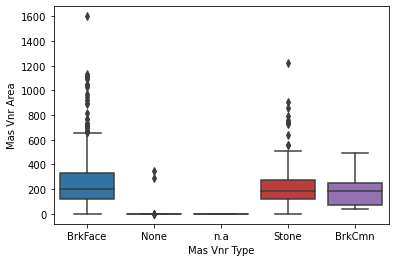

In [96]:
sns.boxplot(x='Mas Vnr Type', y = 'Mas Vnr Area', data=data)

In [97]:
# Reassign n.a as None
data.loc[data['Mas Vnr Type']=='n.a', 'Mas Vnr Type'] = 'None'

# Set Mas Vnr Area to 0 for rows where 'Mas Vnr Type' is None 
data.loc[(data['Mas Vnr Type']=='None') & (data['Mas Vnr Area']>0), 'Mas Vnr Area'] = 0

<AxesSubplot:xlabel='Mas Vnr Type', ylabel='Mas Vnr Area'>

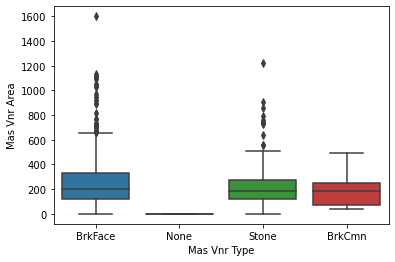

In [98]:
sns.boxplot(x='Mas Vnr Type', y = 'Mas Vnr Area', data=data)

### EDA

In [99]:
# Filtering features with with type "object"
feature_typeObj = [data.dtypes.index[i] for i in range(len(data.dtypes)) if data.dtypes[i] == 'object']
feature_typeObj

['PID',
 'MS SubClass',
 'MS Zoning',
 'Street',
 'Alley',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Overall Qual',
 'Overall Cond',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Exter Qual',
 'Exter Cond',
 'Foundation',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating',
 'Heating QC',
 'Central Air',
 'Electrical',
 'Kitchen Qual',
 'Functional',
 'Fireplace Qu',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive',
 'Pool QC',
 'Fence',
 'Misc Feature',
 'Sale Type']

In [100]:
# Filtering numeric features
feature_typeNum = [data.dtypes.index[i] for i in range(len(data.dtypes)) if data.dtypes[i] != 'object']
feature_typeNum

['Id',
 'Lot Area',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Mo Sold',
 'Yr Sold',
 'SalePrice']

In [101]:
# Initialize list to contain features to select
model_features_list = []
secondary_model_features_list = []

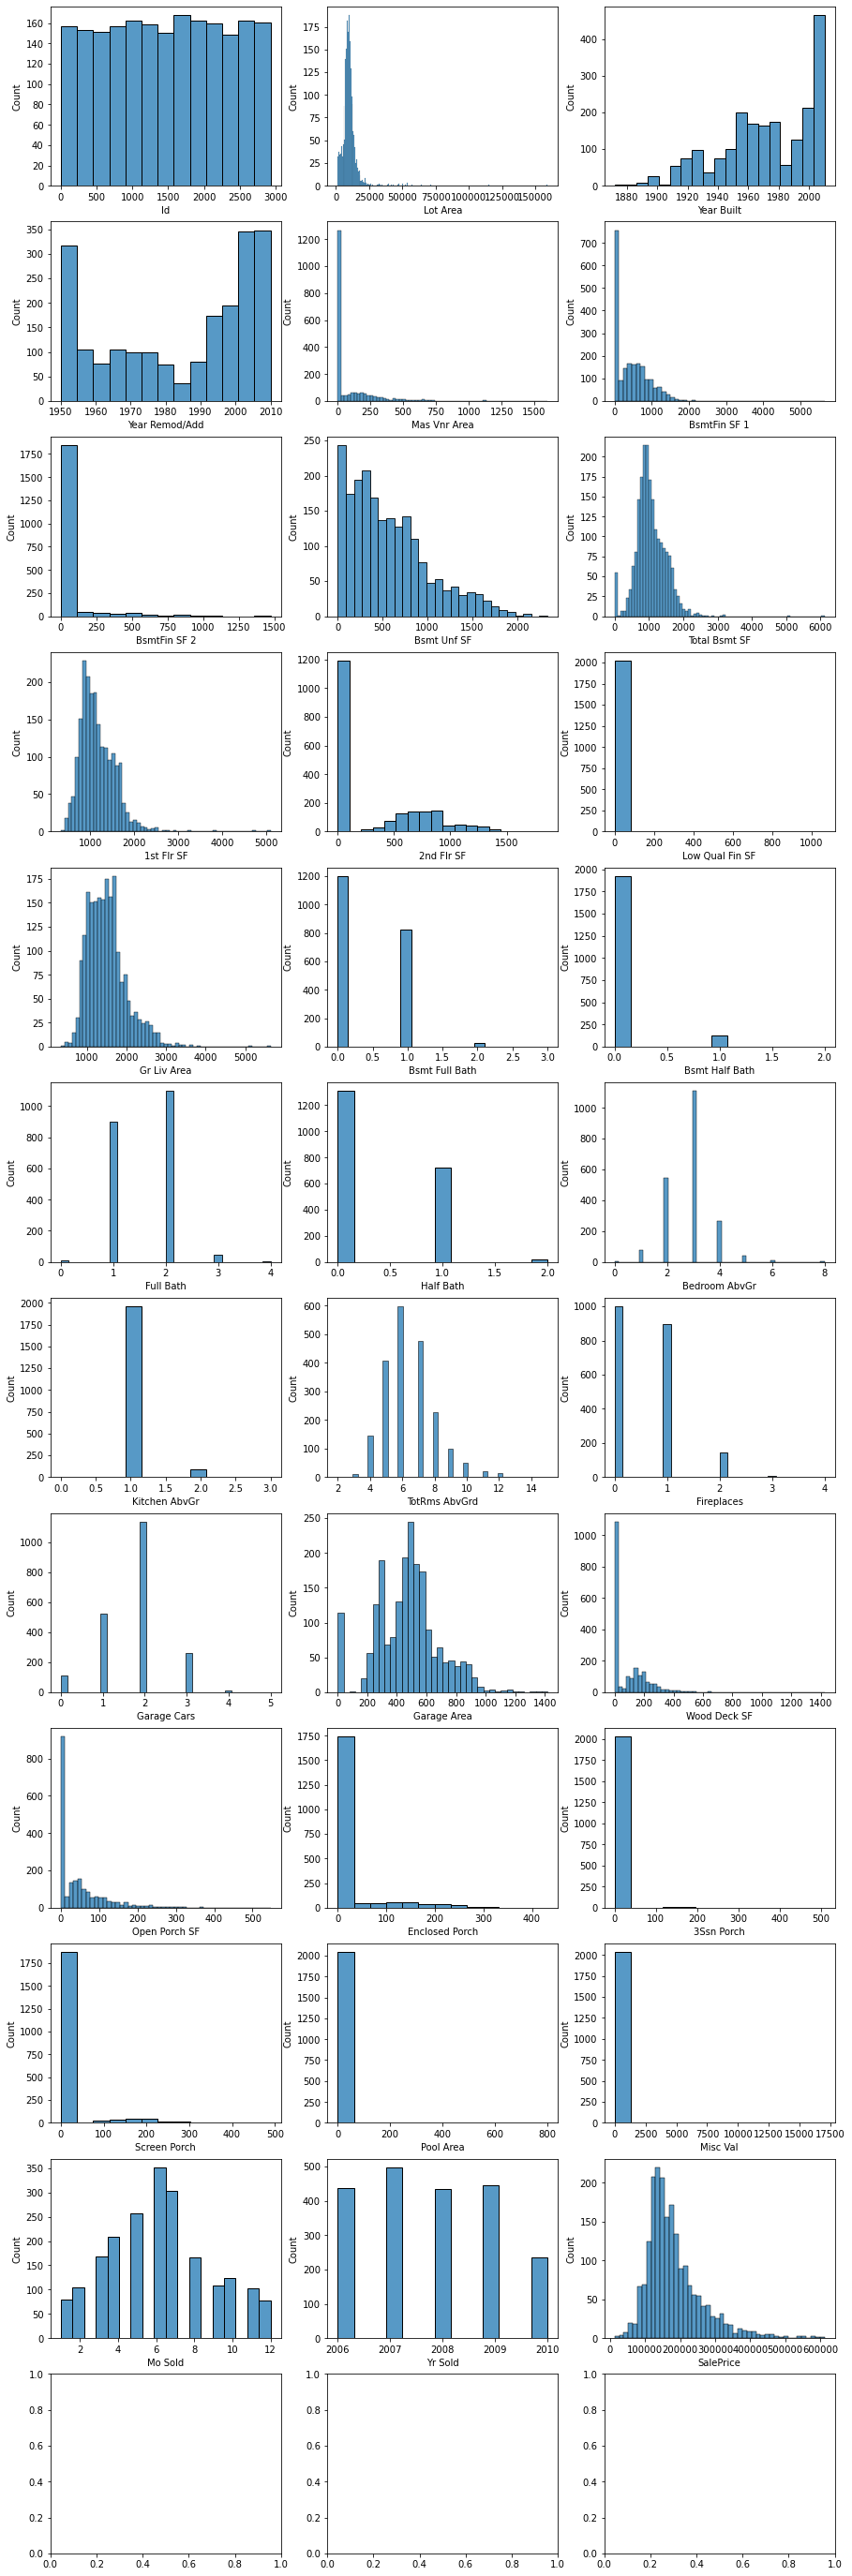

In [102]:
# Checking which feature is not roughly approximate normal distribution
fig, ax = plt.subplots(nrows=12, ncols=3, figsize=(15, 50))
for i in range(len(feature_typeNum)):
    row = int(i/3)
    col = i%3
    sns.histplot(x=data[feature_typeNum[i]], ax=ax[row, col])

- Some features such as Mas Vnr Area, 2nd Flr SF, etc showing high counts of 0.
- Observed multiple features with extreme outliers

#### Engineering new features

In [103]:
# Engineering new numeric features
data['Total SF'] = data['Total Bsmt SF'] + data['1st Flr SF'] + data['2nd Flr SF']
data['Total SF**2'] = (data['Total Bsmt SF'] + data['1st Flr SF'] + data['2nd Flr SF'])**2
data['Total 1_2 SF'] = data['1st Flr SF'] + data['2nd Flr SF']
data['Total 1_2 SF**2'] = (data['1st Flr SF'] + data['2nd Flr SF'])**2
data['No Of Bath'] = data['Bsmt Full Bath'] + (data['Bsmt Half Bath']/2) + data['Full Bath'] + (data['Half Bath']/2)
data['No Of Bath'] = data['Bsmt Full Bath'] + (data['Bsmt Half Bath']/2) + data['Full Bath'] + (data['Half Bath']/2)
data['Total Porch SF'] = data['Open Porch SF'] + data['Enclosed Porch'] + data['3Ssn Porch'] + data['Screen Porch']
data['Amenities SF'] = data['Pool Area'] + data['Wood Deck SF'] + data['Garage Area']
data['Age_Sold'] = data['Yr Sold'] - data['Year Built']
data['Remod/Add Age_Sold'] = data['Yr Sold'] - data['Year Remod/Add']
data['SalePrice_Log'] = np.log(data['SalePrice'])
data['Lot Area_Log'] = np.log(data['Lot Area'])
data['Mas Vnr Area_sqrt'] = np.sqrt(data['Mas Vnr Area'])

# Engineering new categorical features
data['Condition'] = data['Condition 1'] + data['Condition 2']
data['Exterior'] = data['Exterior 1st'] + data['Exterior 2nd']
data['BsmtFin'] = data['BsmtFin Type 1'] + data['BsmtFin Type 2']

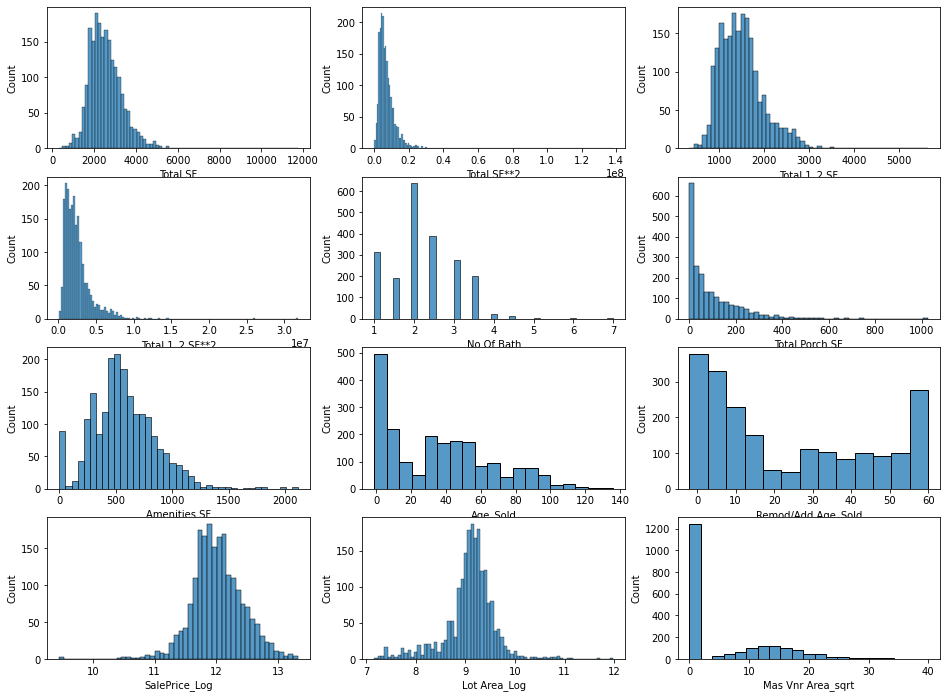

In [104]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16,12))
engineered_feature = ['Total SF', 'Total SF**2', 'Total 1_2 SF', 'Total 1_2 SF**2',
                      'No Of Bath', 'Total Porch SF', 'Amenities SF', 'Age_Sold',
                      'Remod/Add Age_Sold', 'SalePrice_Log', 'Lot Area_Log', 'Mas Vnr Area_sqrt']
for i in range(len(engineered_feature)):
    row = int(i/3)
    col = i%3
    sns.histplot(x=data[engineered_feature[i]], ax=ax[row, col])

#### Checking impact of Year Built and Year Remod/Add on sale price

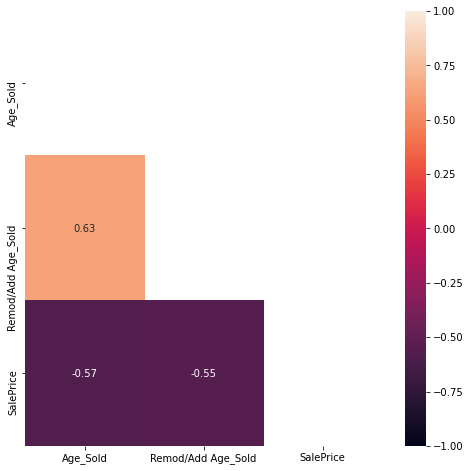

In [105]:
# Plot correlation heatmap between 'Year Built', 'Year Remod/Add', 'SalePrice'
corr_heatmap(data[['Age_Sold', 'Remod/Add Age_Sold', 'SalePrice']])

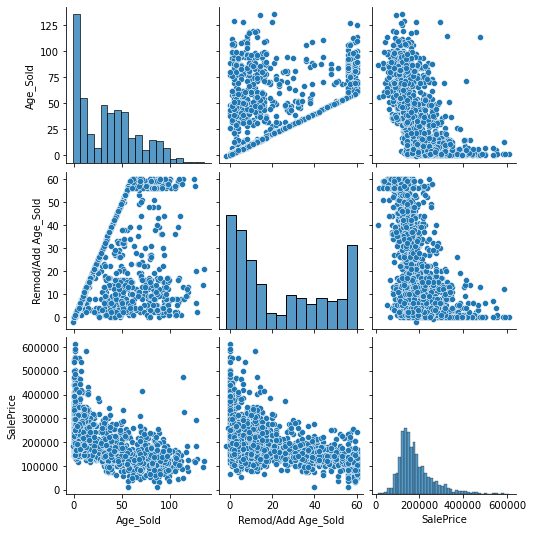

In [106]:
# Plot Pairplot between 'Year Built', 'Year Remod/Add', 'SalePrice'
sns.pairplot(data[['Age_Sold', 'Remod/Add Age_Sold', 'SalePrice']])

- Medium correlation between 'Age_Sold' and 'Remod/Add Age_Sold'
- All 2 features have similar correlation value to sale price
- To use 'Age_Sold' for model as its distribution is more normally distributed

In [107]:
# Append 'Year Built' to list
model_features_list.append('Age_Sold')

#### Checking impact of floor area on sale price

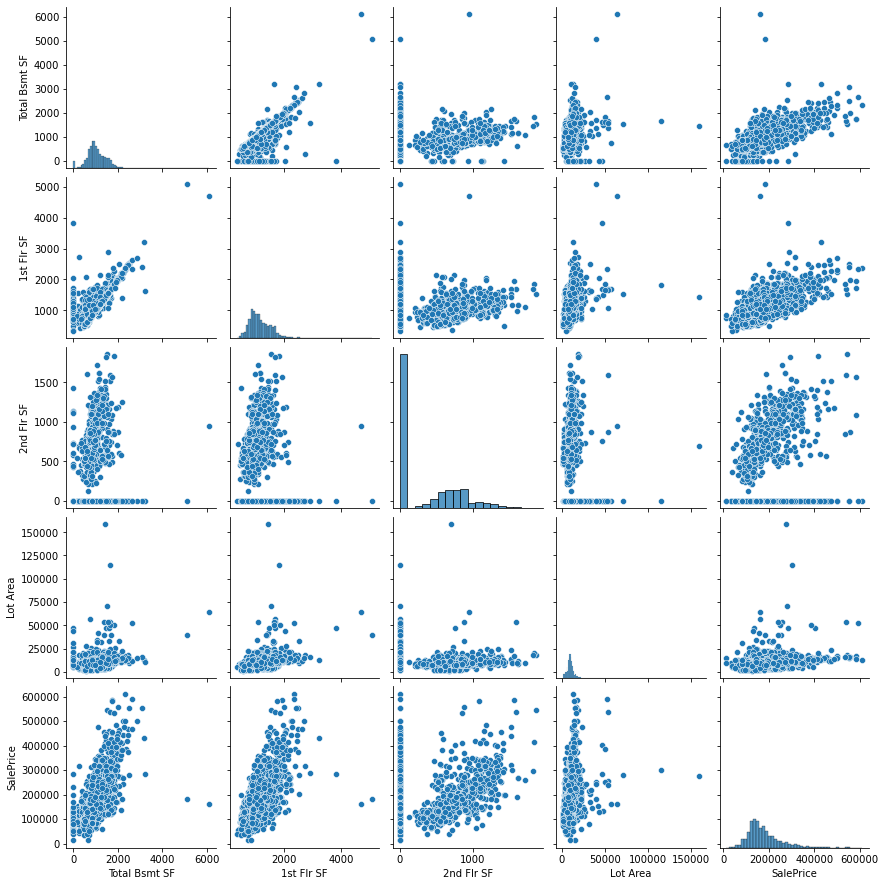

In [108]:
# Plot Pairplot between 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Total SF', 'SalePrice' 
sns.pairplot(data[['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Lot Area', 'SalePrice']])

- Noticed that there are 2 outliers points for 'Total Bsmt SF', '1st Flr SF' and 'Lot Area'.

<AxesSubplot:xlabel='Lot Area', ylabel='SalePrice'>

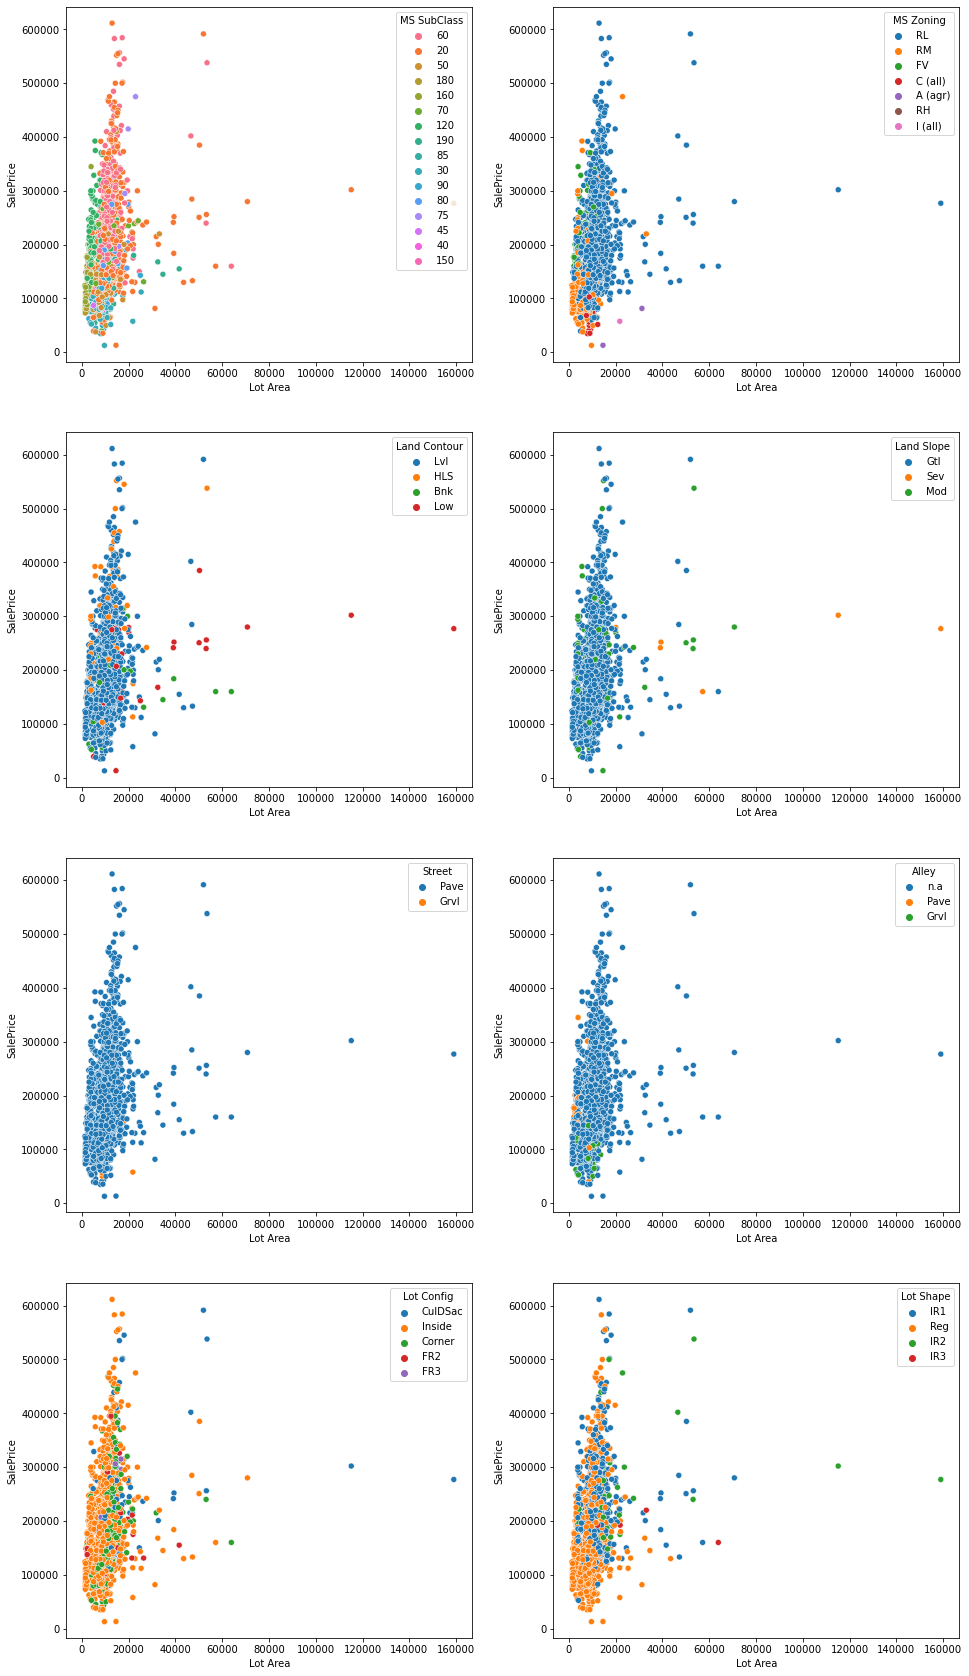

In [109]:
# Checking how land related feature affect Sale Price and Lot Area relationship
fig, ax = plt.subplots(figsize = (16,30), nrows = 4, ncols = 2)
sns.scatterplot(x='Lot Area', y='SalePrice', data=data, ax=ax[0,0], hue='MS SubClass')
sns.scatterplot(x='Lot Area', y='SalePrice', data=data, ax=ax[0,1], hue='MS Zoning')
sns.scatterplot(x='Lot Area', y='SalePrice', data=data, ax=ax[1,0], hue='Land Contour')
sns.scatterplot(x='Lot Area', y='SalePrice', data=data, ax=ax[1,1], hue='Land Slope')
sns.scatterplot(x='Lot Area', y='SalePrice', data=data, ax=ax[2,0], hue='Street')
sns.scatterplot(x='Lot Area', y='SalePrice', data=data, ax=ax[2,1], hue='Alley')
sns.scatterplot(x='Lot Area', y='SalePrice', data=data, ax=ax[3,0], hue='Lot Config')
sns.scatterplot(x='Lot Area', y='SalePrice', data=data, ax=ax[3,1], hue='Lot Shape')

Text(0.5, 0, 'Log(Lot Area)')

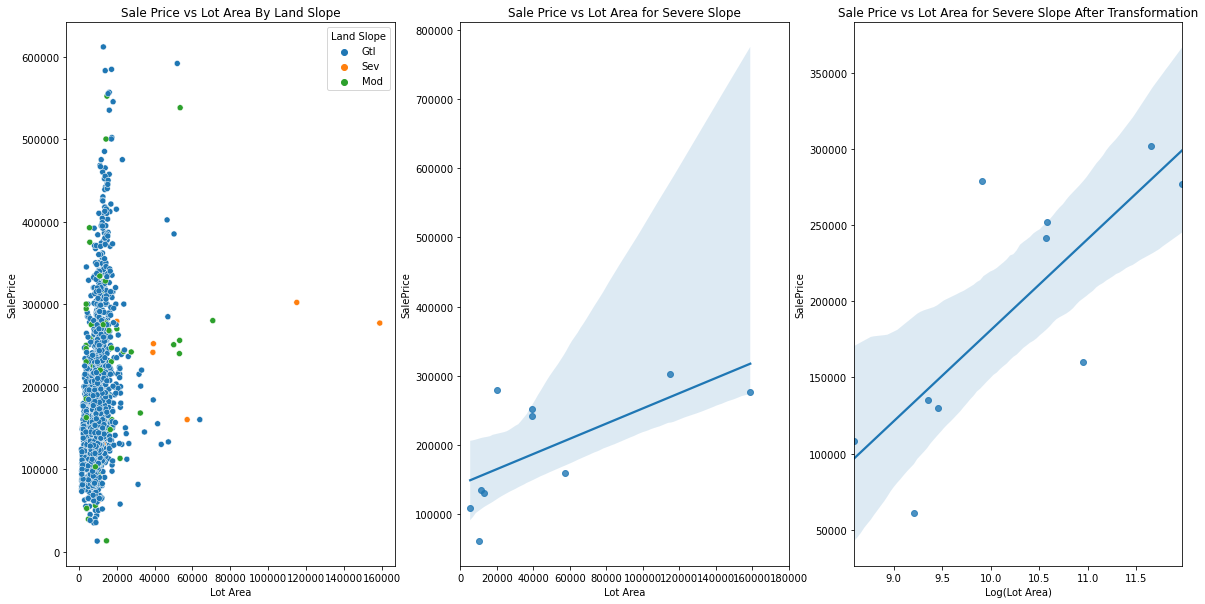

In [110]:
fig, ax = plt.subplots(figsize = (20,10), nrows = 1, ncols = 3)

# 'Sale Price vs Lot Area By Land Slope'
sns.scatterplot(x='Lot Area', y='SalePrice', data=data, ax=ax[0], hue='Land Slope')
ax[0].set_title('Sale Price vs Lot Area By Land Slope')

# Sale Price vs Lot Area for Severe Slope
sns.regplot(x='Lot Area', y='SalePrice', data=data[data['Land Slope']=='Sev'], ax=ax[1])
ax[1].set_title('Sale Price vs Lot Area for Severe Slope')
ax[1].set_xlim(0, 180000)

# Sale Price vs Lot Area for Severe Slope After Transformation
sns.regplot(x=np.log(data[data['Land Slope']=='Sev']['Lot Area']), y=data[data['Land Slope']=='Sev']['SalePrice'], ax=ax[2])
ax[2].set_title('Sale Price vs Lot Area for Severe Slope After Transformation')
ax[2].set_xlabel('Log(Lot Area)')

In [111]:
temp = data[data['Land Slope']=='Sev'].copy()
temp['Lot Area Log'] = np.log(temp['Lot Area'])
temp[['Lot Area', 'Lot Area Log', 'SalePrice']].corr()

Lot Area  Lot Area Log  SalePrice
Lot Area      1.000000      0.913410   0.661249
Lot Area Log  0.913410      1.000000   0.778577
SalePrice     0.661249      0.778577   1.000000

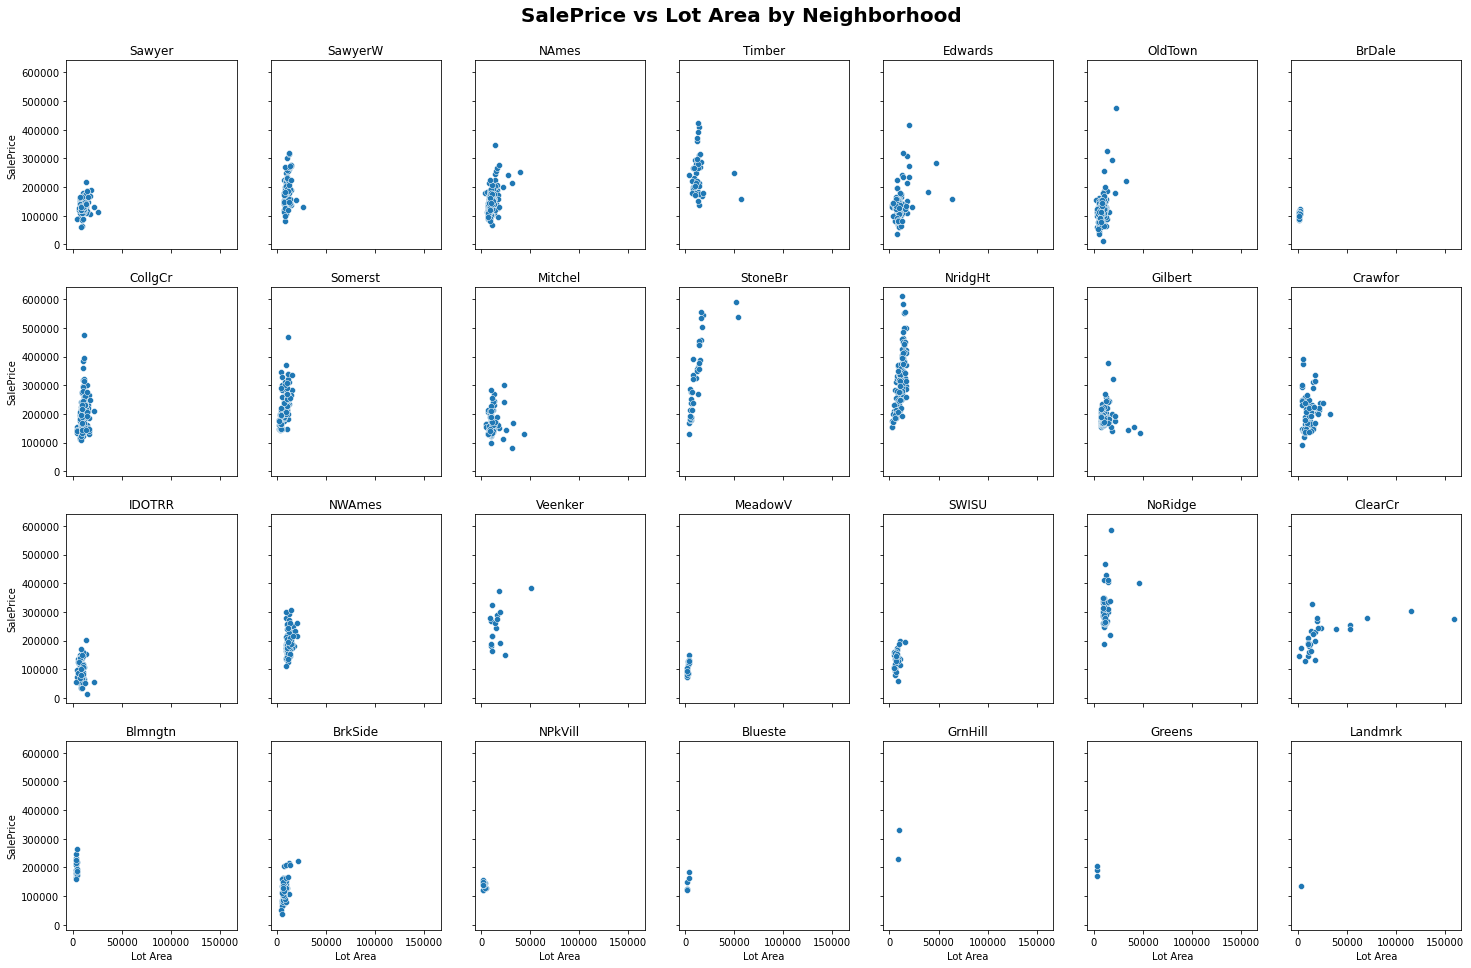

In [112]:
fig, ax = plt.subplots(figsize = (25,15), nrows = 4, ncols = 7, sharex=True, sharey=True, squeeze=False)
for i in range(data['Neighborhood'].nunique()):
    sns.scatterplot(x='Lot Area', y='SalePrice', data=data[data['Neighborhood']==data['Neighborhood'].unique()[i]],
                    ax=ax[int(i/7),i%7])
    ax[int(i/7),i%7].set_title(data['Neighborhood'].unique()[i])
fig.suptitle('SalePrice vs Lot Area by Neighborhood', fontsize=20, fontweight="bold")
fig.subplots_adjust(top=0.93)

- Neighborhood ClearCr is showing non-linear relationship between SalePrice and Lot Area

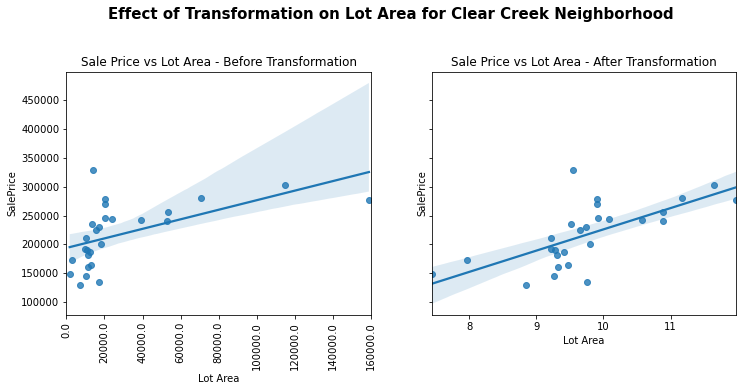

In [113]:
fig, ax = plt.subplots(figsize=(12,5), nrows=1, ncols=2, sharey=True)
# Comparison of scatter plot before and after transformation of Lot Area
# Plot for Sale Price vs Lot Area - Before Transformation for Neighborhood = ClearCr
sns.regplot(x='Lot Area', y='SalePrice', data=data[data['Neighborhood']=='ClearCr'], ax=ax[0])
ax[0].set_title('Sale Price vs Lot Area - Before Transformation')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticks(), rotation=90)

# Plot for Sale Price vs Lot Area - After Transformation for Neighborhood = ClearCr
sns.regplot(x=np.log(data[data['Neighborhood']=='ClearCr']['Lot Area']), y=data[data['Neighborhood']=='ClearCr']['SalePrice'], ax=ax[1])
ax[1].set_title('Sale Price vs Lot Area - After Transformation')

# Set Main Title
fig.suptitle('Effect of Transformation on Lot Area for Clear Creek Neighborhood', fontsize = 15, fontweight='bold')
fig.subplots_adjust(top=0.8)

In [114]:
temp = data[data['Neighborhood']=='ClearCr'].copy()
temp['Lot Area Log'] = np.log(temp['Lot Area'])
temp[['Lot Area', 'Lot Area Log', 'SalePrice']].corr()

Lot Area  Lot Area Log  SalePrice
Lot Area       1.00000      0.845790   0.551350
Lot Area Log   0.84579      1.000000   0.675446
SalePrice      0.55135      0.675446   1.000000

- Lot Area showing non-linear relationship with SalePrice for severe slope and Clear Creek Neighborhood
- Log of Lot Area helped improve the correlation coefficient with sever slope by 0.11 and Clear Creek neighborhood by 0.12
- To interact log(Lot Area) with severe slope from Land Slope and ClearCr from Neighborhood

<AxesSubplot:xlabel='1st Flr SF', ylabel='SalePrice'>

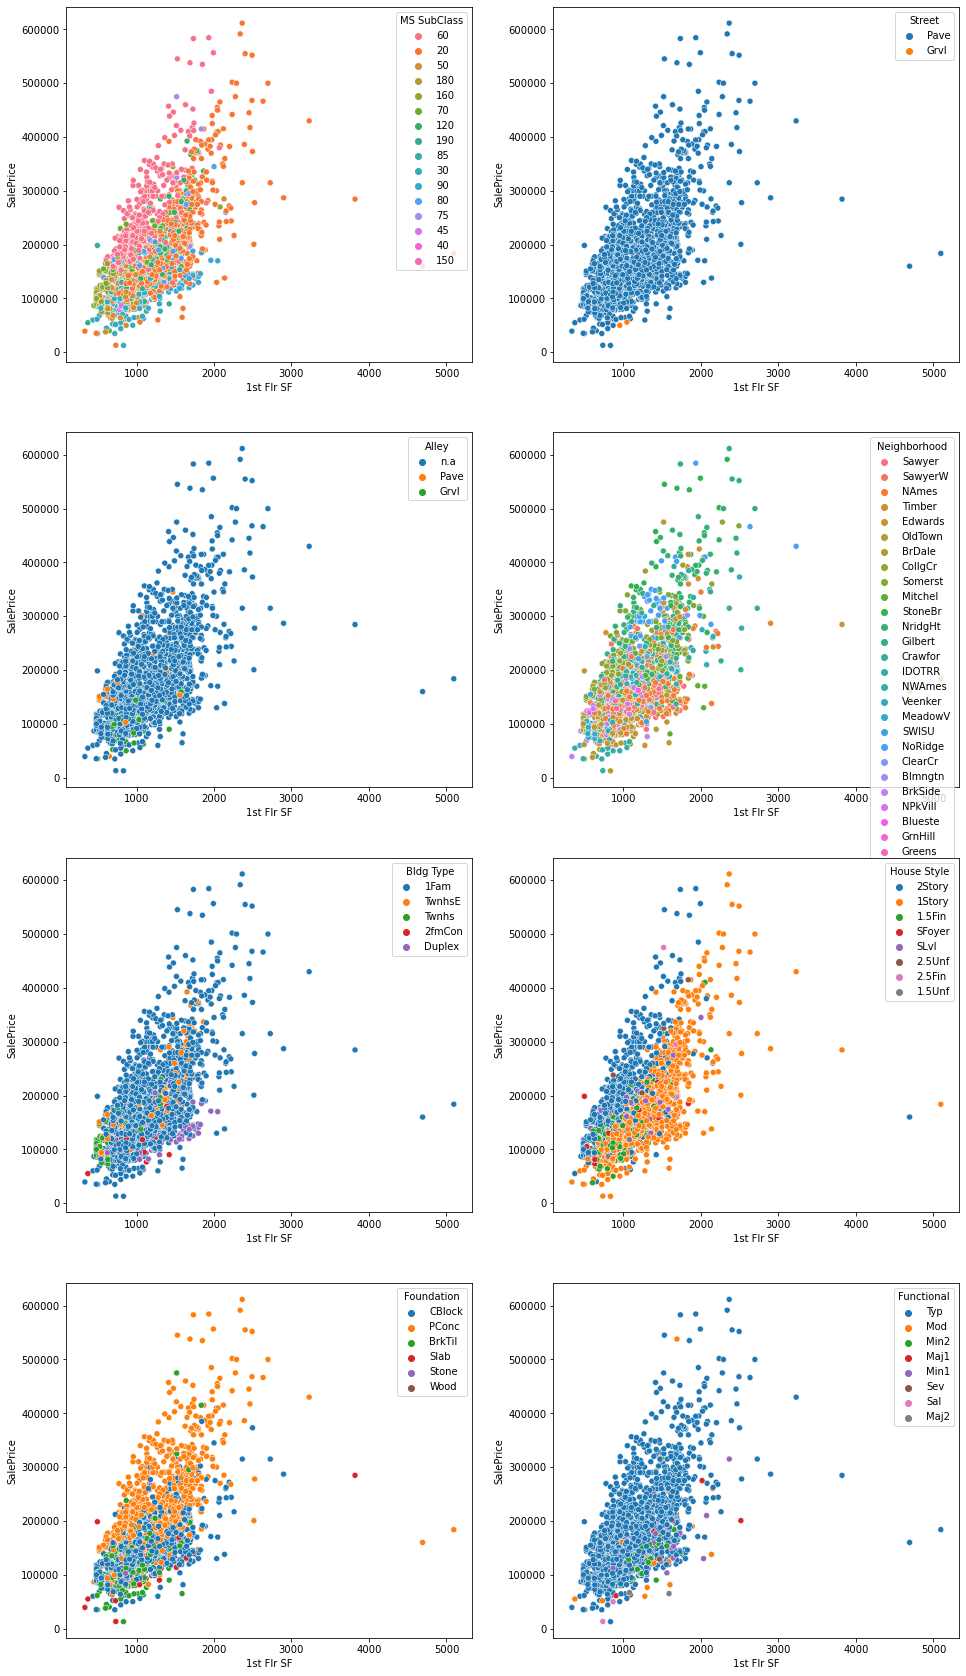

In [115]:
# Checking how land related feature affect Sale Price and 1st Flr SF relationship
fig, ax = plt.subplots(figsize = (16,30), nrows = 4, ncols = 2)
sns.scatterplot(x='1st Flr SF', y='SalePrice', data=data, ax=ax[0,0], hue='MS SubClass')
sns.scatterplot(x='1st Flr SF', y='SalePrice', data=data, ax=ax[0,1], hue='Street')
sns.scatterplot(x='1st Flr SF', y='SalePrice', data=data, ax=ax[1,0], hue='Alley')
sns.scatterplot(x='1st Flr SF', y='SalePrice', data=data, ax=ax[1,1], hue='Neighborhood')
sns.scatterplot(x='1st Flr SF', y='SalePrice', data=data, ax=ax[2,0], hue='Bldg Type')
sns.scatterplot(x='1st Flr SF', y='SalePrice', data=data, ax=ax[2,1], hue='House Style')
sns.scatterplot(x='1st Flr SF', y='SalePrice', data=data, ax=ax[3,0], hue='Foundation')
sns.scatterplot(x='1st Flr SF', y='SalePrice', data=data, ax=ax[3,1], hue='Functional')

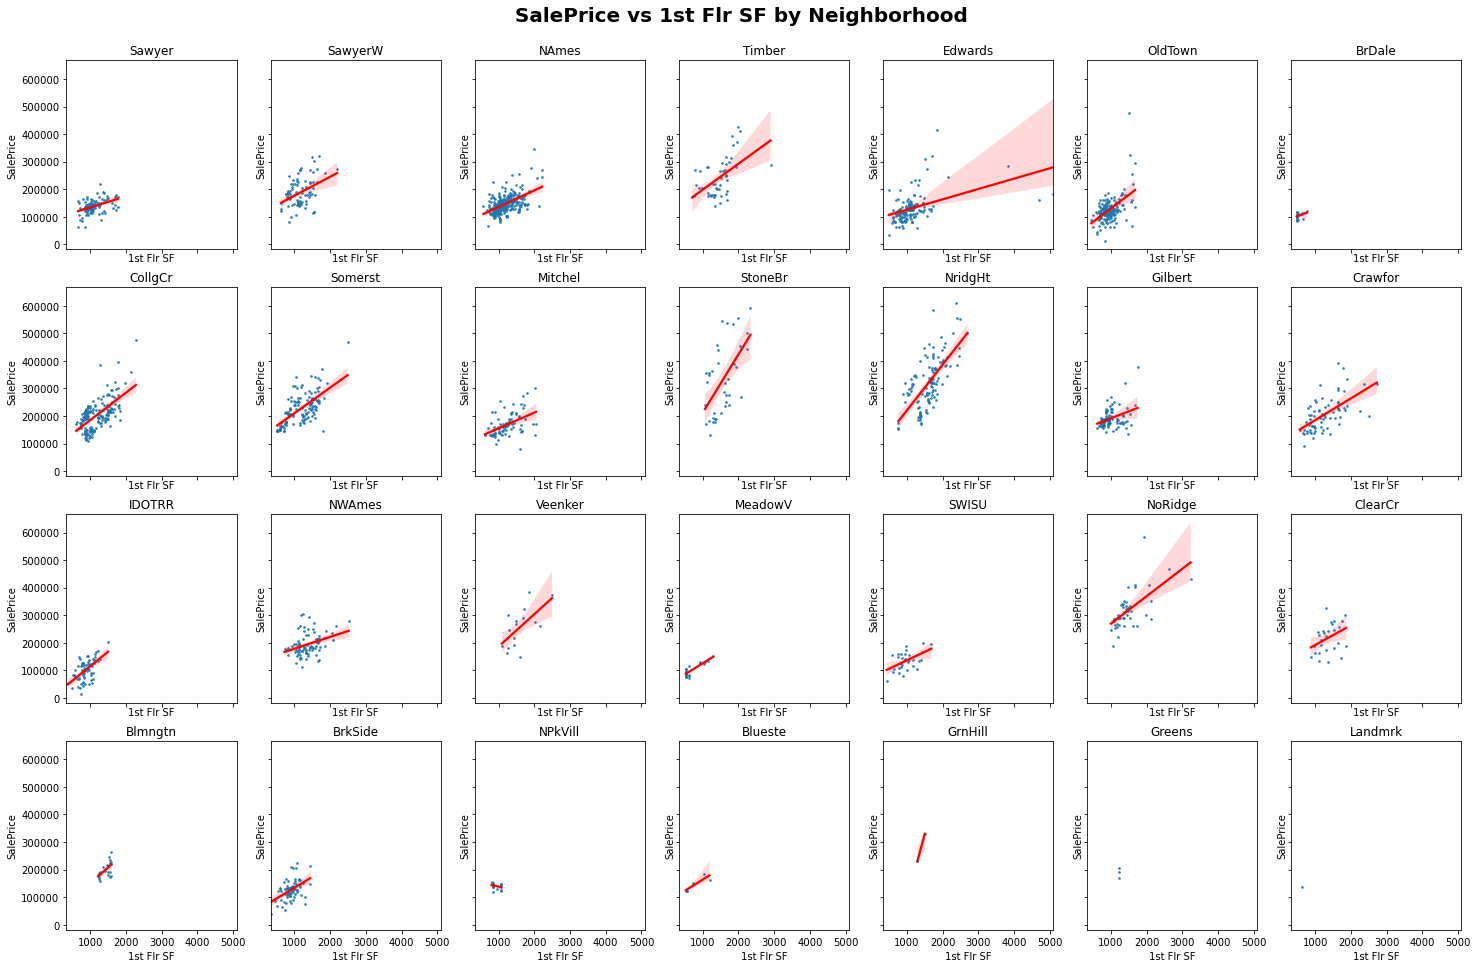

In [116]:
fig, ax = plt.subplots(figsize = (25,15), nrows = 4, ncols = 7, sharex=True, sharey=True)
for i in range(data['Neighborhood'].nunique()):
    sns.regplot(x='1st Flr SF', y='SalePrice', data=data[data['Neighborhood']==data['Neighborhood'].unique()[i]],
                ax=ax[int(i/7),i%7], line_kws={'color':'red'}, scatter_kws={'s':3})
    ax[int(i/7),i%7].set_title(data['Neighborhood'].unique()[i])


fig.suptitle('SalePrice vs 1st Flr SF by Neighborhood', fontsize=20, fontweight="bold")
fig.subplots_adjust(top=0.93)

- Outliers observed for 1st Flr SF are coming from Neighborhood Edwards

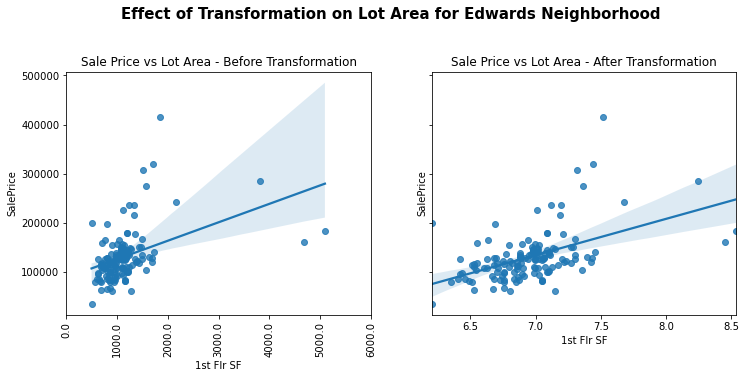

In [117]:
fig, ax = plt.subplots(figsize=(12,5), nrows=1, ncols=2, sharey=True)
# Comparison of scatter plot before and after transformation of Lot Area
# Plot for Sale Price vs Lot Area - Before Transformation for Neighborhood = Edwards
sns.regplot(x='1st Flr SF', y='SalePrice', data=data[data['Neighborhood']=='Edwards'], ax=ax[0])
ax[0].set_title('Sale Price vs Lot Area - Before Transformation')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticks(), rotation=90)

# Plot for Sale Price vs Lot Area - After Transformation for Neighborhood = Edwards
sns.regplot(x=np.log(data[data['Neighborhood']=='Edwards']['1st Flr SF']), y=data[data['Neighborhood']=='Edwards']['SalePrice'], ax=ax[1])
ax[1].set_title('Sale Price vs Lot Area - After Transformation')

# Set Main Title
fig.suptitle('Effect of Transformation on Lot Area for Edwards Neighborhood', fontsize = 15, fontweight='bold')
fig.subplots_adjust(top=0.8)

In [118]:
# Check impact of log of 1st Flr SF on correlatio coefficients 
temp = data[data['Neighborhood']=='Edwards'].copy()
temp['1st Flr SF Log'] = np.log(temp['1st Flr SF'])
temp[['1st Flr SF', '1st Flr SF Log', 'SalePrice']].corr()

1st Flr SF  1st Flr SF Log  SalePrice
1st Flr SF        1.000000        0.918177   0.426605
1st Flr SF Log    0.918177        1.000000   0.497823
SalePrice         0.426605        0.497823   1.000000

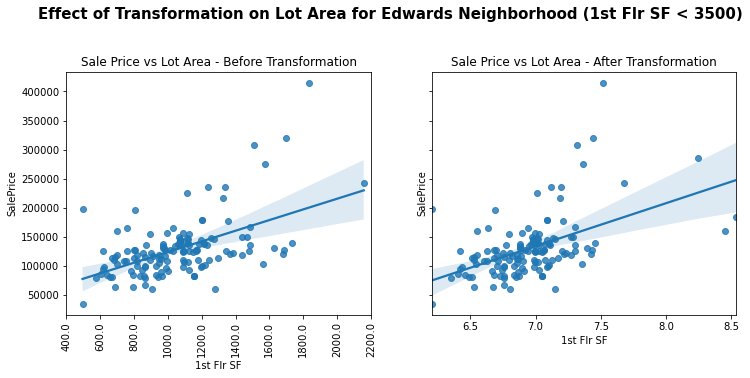

In [119]:
fig, ax = plt.subplots(figsize=(12,5), nrows=1, ncols=2, sharey=True)
# Comparison of scatter plot before and after transformation of Lot Area (1st Flr SF < 3500)
# Plot for Sale Price vs Lot Area - Before Transformation for Neighborhood = Edwards
sns.regplot(x='1st Flr SF', y='SalePrice', data=data[(data['Neighborhood']=='Edwards') & (data['1st Flr SF']<3500)], ax=ax[0])
ax[0].set_title('Sale Price vs Lot Area - Before Transformation')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticks(), rotation=90)

# Plot for Sale Price vs Lot Area - After Transformation for Neighborhood = Edwards
sns.regplot(x=np.log(data[data['Neighborhood']=='Edwards']['1st Flr SF']), y=data[data['Neighborhood']=='Edwards']['SalePrice'], ax=ax[1])
ax[1].set_title('Sale Price vs Lot Area - After Transformation')

# Set Main Title
fig.suptitle('Effect of Transformation on Lot Area for Edwards Neighborhood (1st Flr SF < 3500)', fontsize = 15, fontweight='bold')
fig.subplots_adjust(top=0.8)

In [120]:
# Check impact of log of 1st Flr SF on correlatio coefficients (1st Flr SF < 3500)
temp = data[(data['Neighborhood']=='Edwards') & (data['1st Flr SF']<3500)].copy()
temp['1st Flr SF Log'] = np.log(temp['1st Flr SF'])
temp[['1st Flr SF', '1st Flr SF Log', 'SalePrice']].corr()

1st Flr SF  1st Flr SF Log  SalePrice
1st Flr SF        1.000000        0.981338   0.529217
1st Flr SF Log    0.981338        1.000000   0.484027
SalePrice         0.529217        0.484027   1.000000

- Outliers observed in SalePrice vs 1st Flr SF is from Neighborhood Edwards
- By taking log of 1st Flr SF, the correlation coefficient improved by 0.06
- Although by limiting the 1st Flr SF to below 3500, the correlation coefficient improved by 0.1
    - However, no assignable cause for the outlier
    - Decide to keep data first and use log of 1st Flr SF first and revisit after looking at model

- 'Total SF' is showing higher correlation to 'SalePrice' with score of 0.78
- To use 'Total Bsmt SF', '1st Flr SF' & '2nd Flr SF' since 'Total SF' is just a summation of all 3 features

In [121]:
# Append '1st Flr SF', '2nd Flr SF' to list
model_features_list.extend(['1st Flr SF', '2nd Flr SF'])

#### Checking impact of basement size on sale price

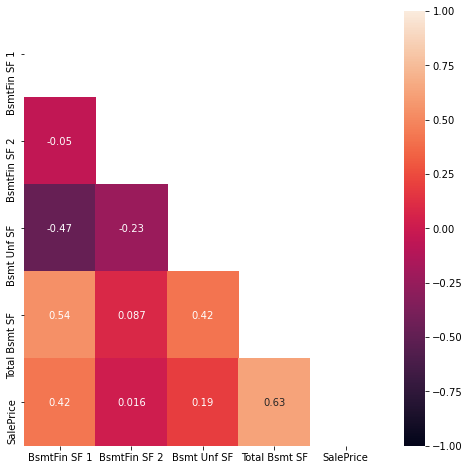

In [122]:
# Plot correlation heatmap between 'BsmtFin SF 1', 'BsmtFin SF 2',
# 'Bsmt Unf SF', 'Total Bsmt SF', 'SalePrice'
corr_heatmap(data[['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'SalePrice']])

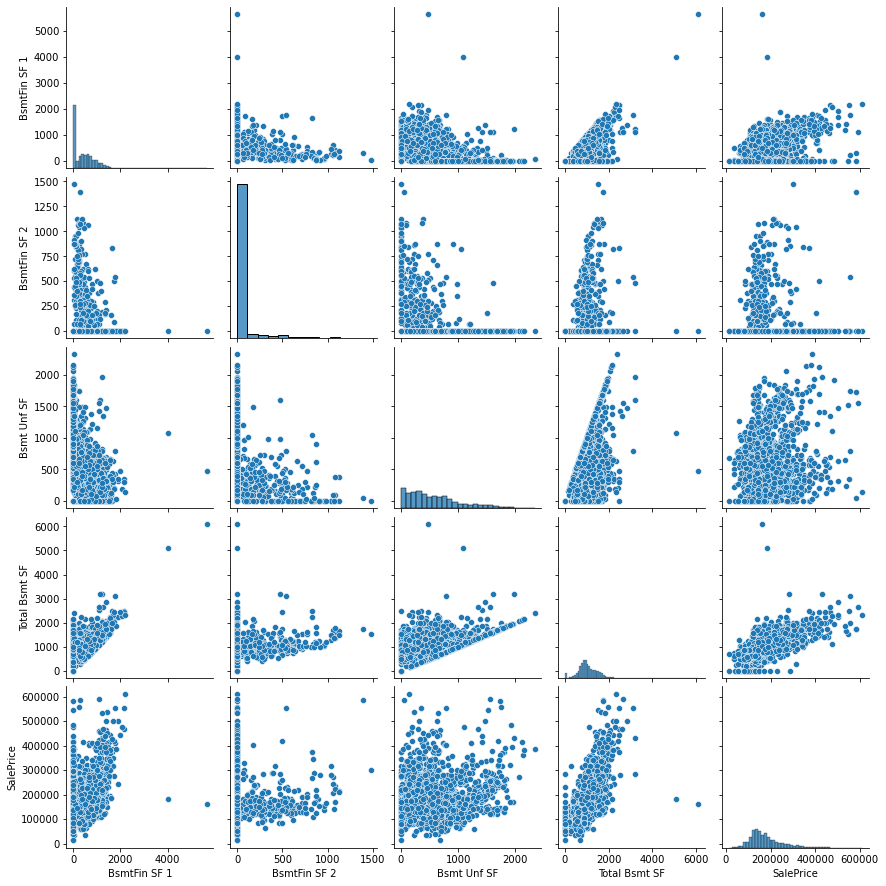

In [123]:
# Plot Pairplot between 'BsmtFin SF 1', 'BsmtFin SF 2', 
# 'Bsmt Unf SF', 'Total Bsmt SF', 'SalePrice'
sns.pairplot(data[['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'SalePrice']])

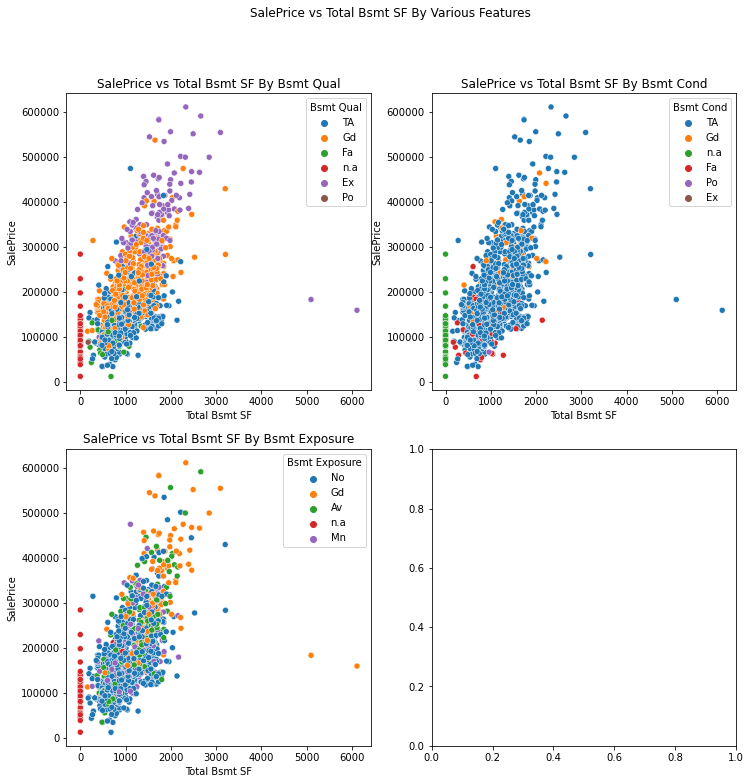

In [124]:
features_list=['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure']
rows = 2
cols = 2
scatter_plot_by_cat(data=data, x='Total Bsmt SF', y='SalePrice', 
                    features_list=features_list, rows=rows, cols=cols, figsize=(12,12))

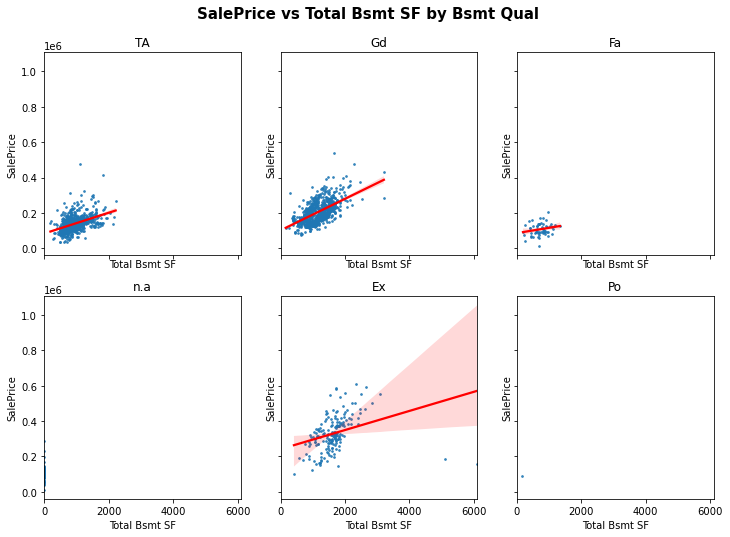

In [125]:
fig, ax = plt.subplots(figsize = (12,8), nrows = 2, ncols = 3, sharex=True, sharey=True)
for i in range(data['Bsmt Qual'].nunique()):
    sns.regplot(x='Total Bsmt SF', y='SalePrice', data=data[data['Bsmt Qual']==data['Bsmt Qual'].unique()[i]],
                ax=ax[int(i/3),i%3], line_kws={'color':'red'}, scatter_kws={'s':3})
    ax[int(i/3),i%3].set_title(data['Bsmt Qual'].unique()[i]) 


fig.suptitle('SalePrice vs Total Bsmt SF by Bsmt Qual', fontsize=15, fontweight="bold")
fig.subplots_adjust(top=0.9)

<AxesSubplot:xlabel='Total Bsmt SF', ylabel='SalePrice'>

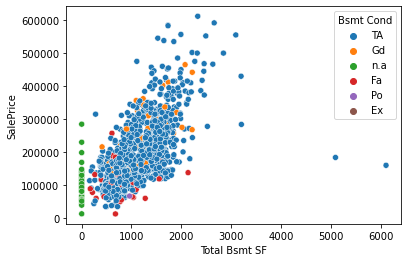

In [127]:
sns.scatterplot(x='Total Bsmt SF', y='SalePrice', data=data, hue='Bsmt Cond')

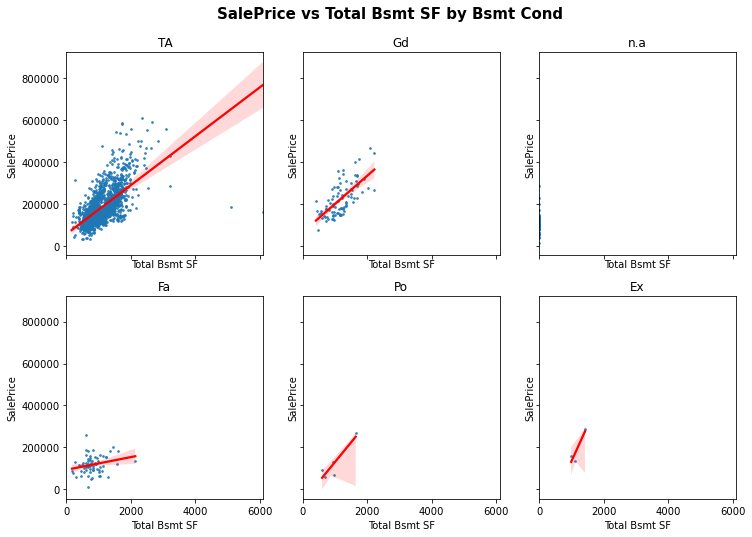

In [128]:
fig, ax = plt.subplots(figsize = (12,8), nrows = 2, ncols = 3, sharex=True, sharey=True)
for i in range(data['Bsmt Cond'].nunique()):
    sns.regplot(x='Total Bsmt SF', y='SalePrice', data=data[data['Bsmt Cond']==data['Bsmt Cond'].unique()[i]],
                ax=ax[int(i/3),i%3], line_kws={'color':'red'}, scatter_kws={'s':3})
    ax[int(i/3),i%3].set_title(data['Bsmt Cond'].unique()[i])


fig.suptitle('SalePrice vs Total Bsmt SF by Bsmt Cond', fontsize=15, fontweight="bold")
fig.subplots_adjust(top=0.9)

<AxesSubplot:xlabel='Total Bsmt SF', ylabel='SalePrice'>

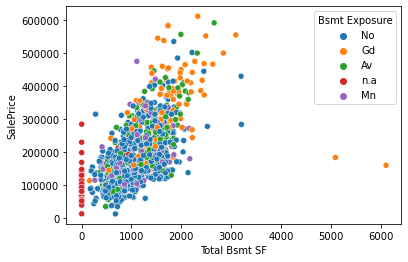

In [129]:
sns.scatterplot(x='Total Bsmt SF', y='SalePrice', data=data, hue='Bsmt Exposure')

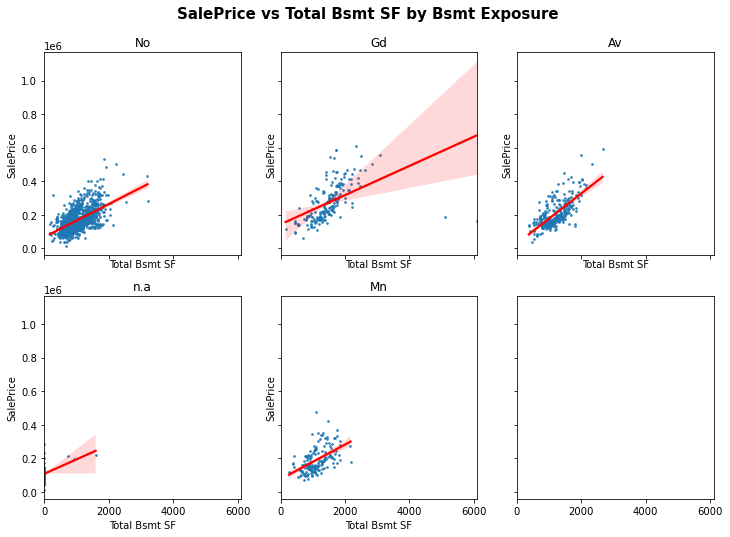

In [130]:
fig, ax = plt.subplots(figsize = (12,8), nrows = 2, ncols = 3, sharex=True, sharey=True)
for i in range(data['Bsmt Exposure'].nunique()):
    sns.regplot(x='Total Bsmt SF', y='SalePrice', data=data[data['Bsmt Exposure']==data['Bsmt Exposure'].unique()[i]],
                ax=ax[int(i/3),i%3], line_kws={'color':'red'}, scatter_kws={'s':3})
    ax[int(i/3),i%3].set_title(data['Bsmt Exposure'].unique()[i])


fig.suptitle('SalePrice vs Total Bsmt SF by Bsmt Exposure', fontsize=15, fontweight="bold")
fig.subplots_adjust(top=0.9)

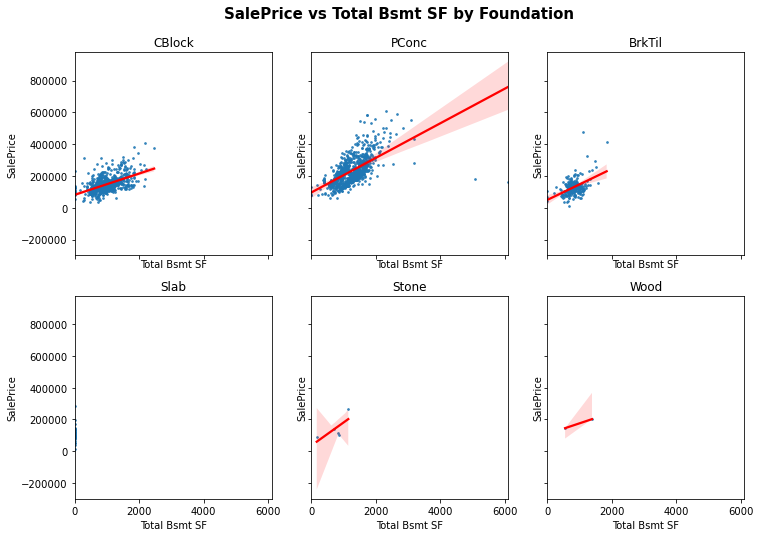

In [126]:
fig, ax = plt.subplots(figsize = (12,8), nrows = 2, ncols = 3, sharex=True, sharey=True)
for i in range(data['Foundation'].nunique()):
    sns.regplot(x='Total Bsmt SF', y='SalePrice', data=data[data['Foundation']==data['Foundation'].unique()[i]],
                ax=ax[int(i/3),i%3], line_kws={'color':'red'}, scatter_kws={'s':3})
    ax[int(i/3),i%3].set_title(data['Foundation'].unique()[i])


fig.suptitle('SalePrice vs Total Bsmt SF by Foundation', fontsize=15, fontweight="bold")
fig.subplots_adjust(top=0.9)

- 'Total Bsmt SF' has decent correlation to sale price
- To drop 'BsmtFin SF 1' due to moderate collinearity with 'Total Bsmt SF'
- To drop 'BsmtFin SF 2' & 'Bsmt Unf SF' due to low correlation score

In [131]:
# Append 'Total Bsmt SF' to list
model_features_list.append('Total Bsmt SF')

#### Checking impact of 'Lot Area' and 'Mas Vnr Area' on 'SalePrice'

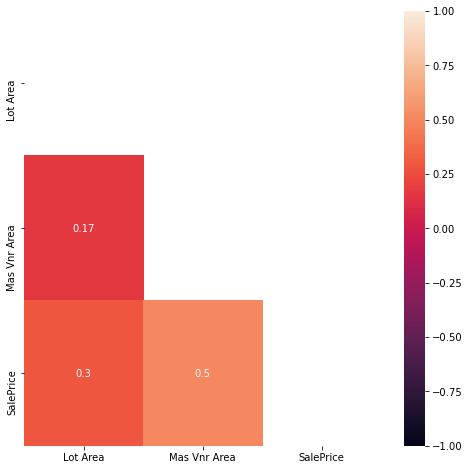

In [132]:
# Plot correlation heatmap between 'Lot Area', 'Mas Vnr Area', 'SalePrice'
corr_heatmap(data[['Lot Area', 'Mas Vnr Area', 'SalePrice']])

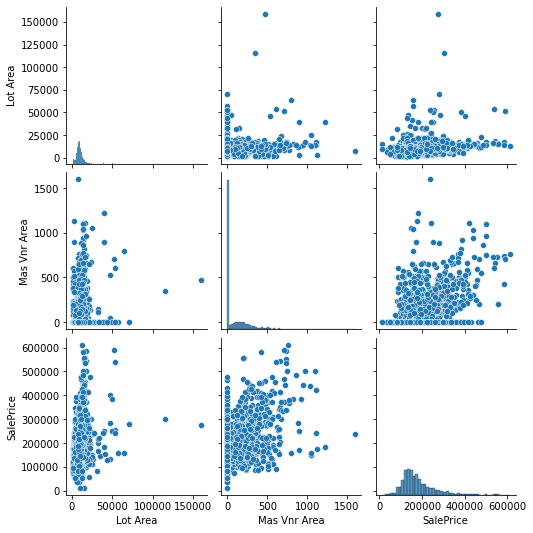

In [133]:
# Plot Pairplot between 'Lot Area', 'Mas Vnr Area', 'SalePrice'
sns.pairplot(data[['Lot Area', 'Mas Vnr Area', 'SalePrice']])

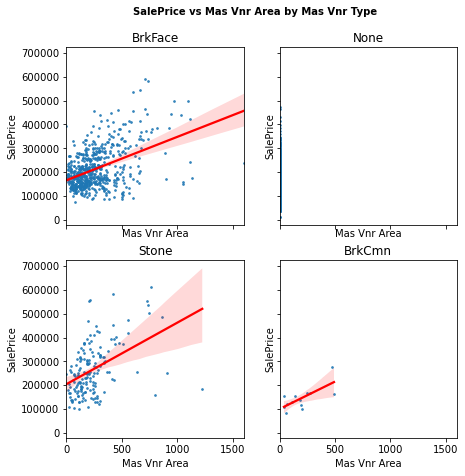

In [134]:
fig, ax = plt.subplots(figsize = (7,7), nrows = 2, ncols = 2, sharex=True, sharey=True)
for i in range(data['Mas Vnr Type'].nunique()):
    sns.regplot(x='Mas Vnr Area', y='SalePrice', data=data[data['Mas Vnr Type']==data['Mas Vnr Type'].unique()[i]],
                ax=ax[int(i/2),i%2], line_kws={'color':'red'}, scatter_kws={'s':3})
    ax[int(i/2),i%2].set_title(data['Mas Vnr Type'].unique()[i])


fig.suptitle('SalePrice vs Mas Vnr Area by Mas Vnr Type', fontsize=10, fontweight="bold")
fig.subplots_adjust(top=0.9)

- 'Mas Vnr Area' to be used for modeling for decent correlation score to 'SalePrice'

In [135]:
# Append 'Mas Vnr Area' to list
model_features_list.append('Mas Vnr Area')

#### Checking other floor related features impact on SalePrice

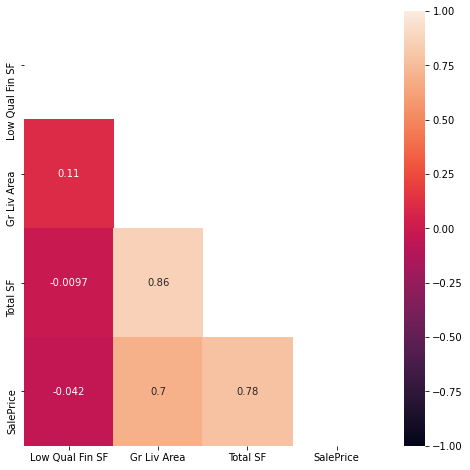

In [136]:
# Plot correlation heatmap between 'Low Qual Fin SF', 'Gr Liv Area', 'Overall Qual', 
# 'Overall Cond', 'SalePrice'
corr_heatmap(data[['Low Qual Fin SF', 'Gr Liv Area', 'Total SF', 'SalePrice']])

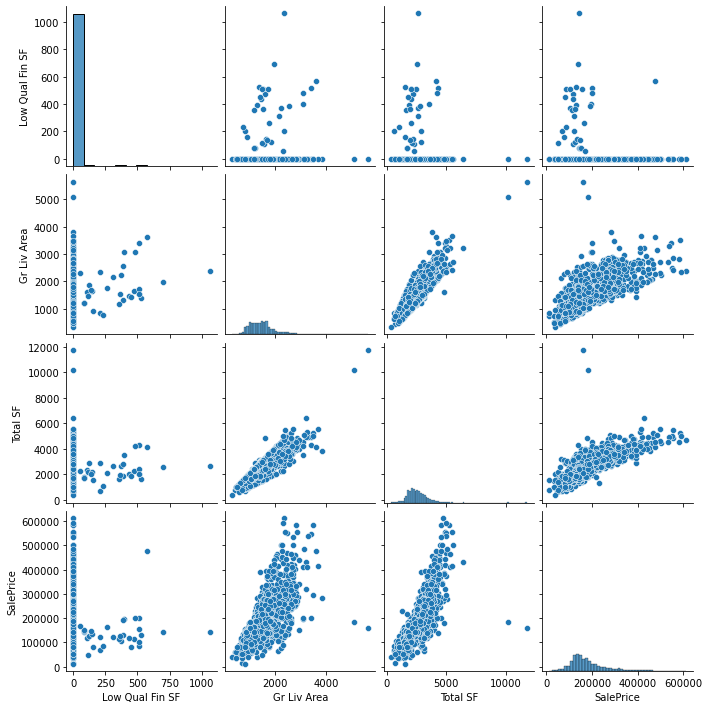

In [137]:
# Plot Pairplot between 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Total SF', 'SalePrice' 
sns.pairplot(data[['Low Qual Fin SF', 'Gr Liv Area', 'Total SF', 'SalePrice']])

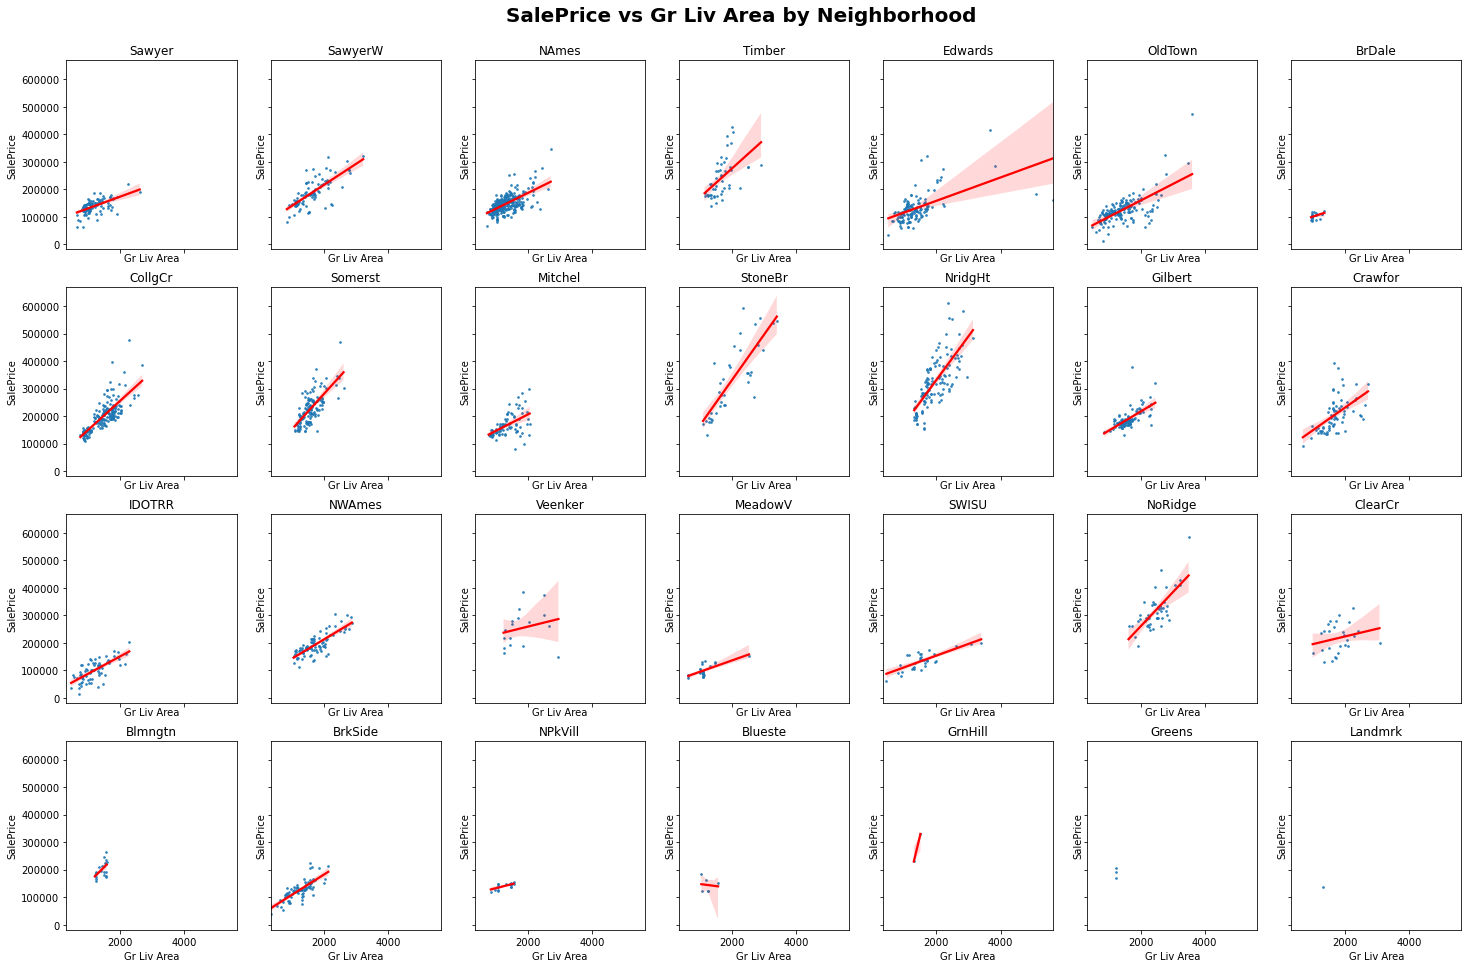

In [138]:
fig, ax = plt.subplots(figsize = (25,15), nrows = 4, ncols = 7, sharex=True, sharey=True)
for i in range(data['Neighborhood'].nunique()):
    sns.regplot(x='Gr Liv Area', y='SalePrice', data=data[data['Neighborhood']==data['Neighborhood'].unique()[i]],
                ax=ax[int(i/7),i%7], line_kws={'color':'red'}, scatter_kws={'s':3})
    ax[int(i/7),i%7].set_title(data['Neighborhood'].unique()[i])


fig.suptitle('SalePrice vs Gr Liv Area by Neighborhood', fontsize=20, fontweight="bold")
fig.subplots_adjust(top=0.93)

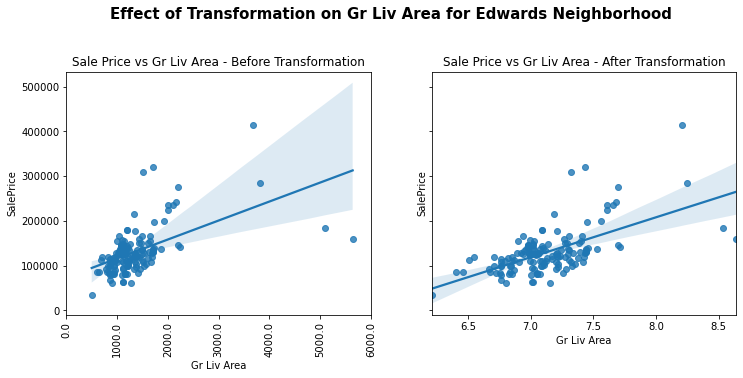

In [139]:
fig, ax = plt.subplots(figsize=(12,5), nrows=1, ncols=2, sharey=True)
# Comparison of scatter plot before and after transformation of Lot Area
# Plot for Sale Price vs Lot Area - Before Transformation for Neighborhood = ClearCr
sns.regplot(x='Gr Liv Area', y='SalePrice', data=data[data['Neighborhood']=='Edwards'], ax=ax[0])
ax[0].set_title('Sale Price vs Gr Liv Area - Before Transformation')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticks(), rotation=90)

# Plot for Sale Price vs Lot Area - After Transformation for Neighborhood = ClearCr
sns.regplot(x=np.log(data[data['Neighborhood']=='Edwards']['Gr Liv Area']), y=data[data['Neighborhood']=='Edwards']['SalePrice'], ax=ax[1])
ax[1].set_title('Sale Price vs Gr Liv Area - After Transformation')

# Set Main Title
fig.suptitle('Effect of Transformation on Gr Liv Area for Edwards Neighborhood', fontsize = 15, fontweight='bold')
fig.subplots_adjust(top=0.8)

In [140]:
# Check impact of log of 1st Flr SF on correlatio coefficients 
temp = data[data['Neighborhood']=='Edwards'].copy()
temp['Gr Liv Area Log'] = np.log(temp['Gr Liv Area'])
temp[['Gr Liv Area', 'Gr Liv Area Log', 'SalePrice']].corr()

Gr Liv Area  Gr Liv Area Log  SalePrice
Gr Liv Area         1.000000         0.929736   0.546075
Gr Liv Area Log     0.929736         1.000000   0.606391
SalePrice           0.546075         0.606391   1.000000

- Outliers observed in SalePrice vs Gr Liv Area is from Neighborhood Edwards
    - Not surprising since Gr Liv Area and 1st Flr SF is highly correlated to each other
- By taking log of Gr Liv Area, the correlation coefficient improved by 0.06

- To use 'Gr Liv Area', 'Overall Qual' in model due to high correlation score

In [141]:
# Append 'Gr Liv Area', 'Overall Qual' to list
model_features_list.extend(['Gr Liv Area', 'Overall Qual'])

#### Impact of Number of Bathrooms, bedrooms and Kitchen on SalePrice

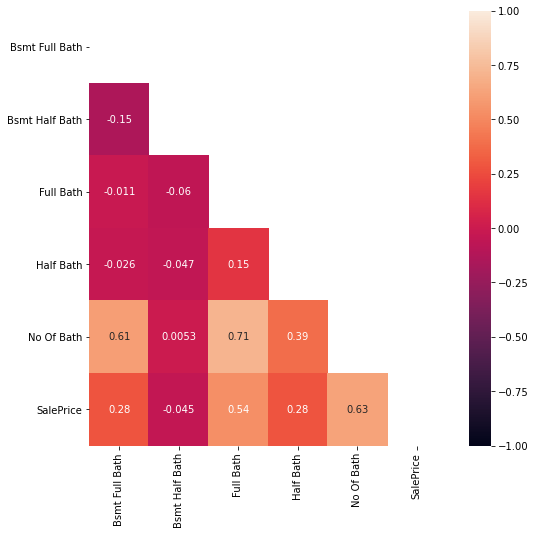

In [142]:
# Plot correlation heatmap
corr_heatmap(data[['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 
                   'No Of Bath', 'SalePrice']])

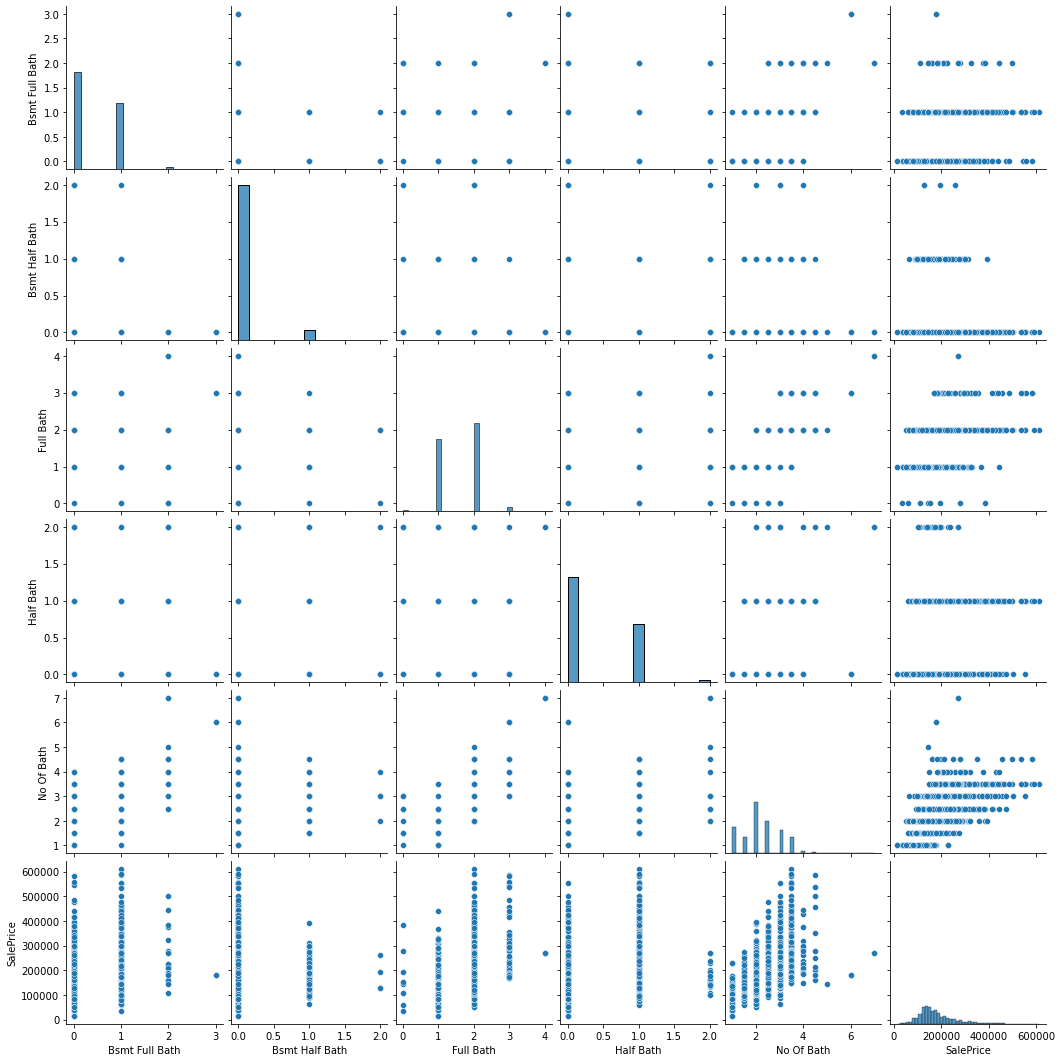

In [143]:
# Plot Pairplot
sns.pairplot(data[['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 
                   'No Of Bath', 'SalePrice']])

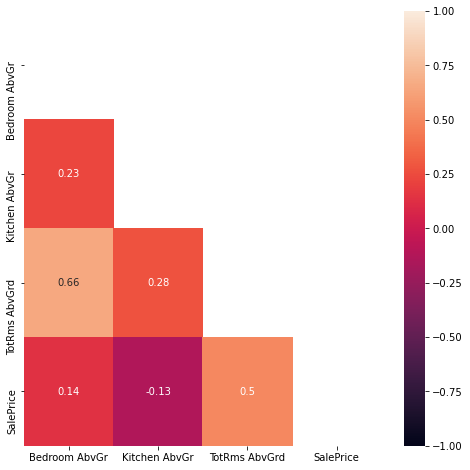

In [144]:
# Plot correlation heatmap
corr_heatmap(data[['Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'SalePrice']])

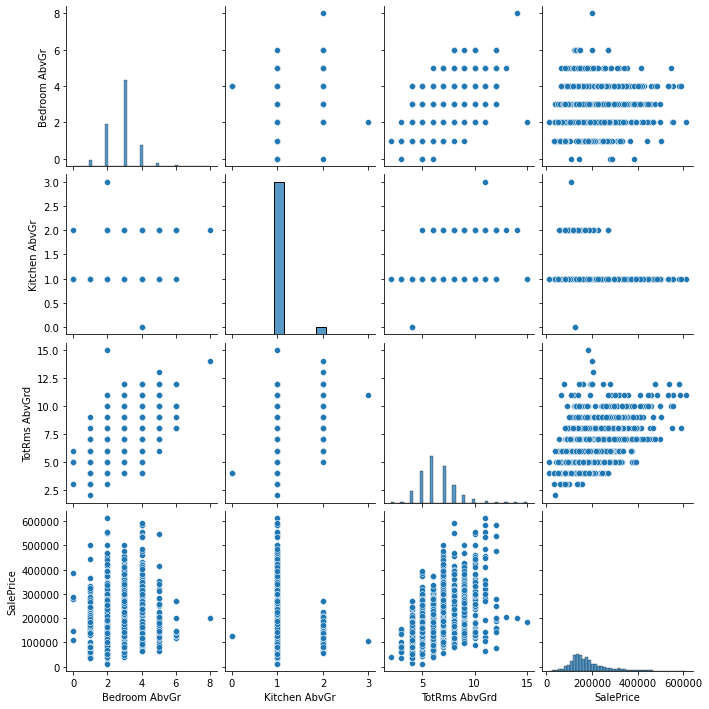

In [145]:
# Plot Pairplot
sns.pairplot(data[['Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'SalePrice']])

Dropping all features except the features indicated below for model:-
- No Of Bath
- TotRms AbvGrd

In [146]:
# Append 'Full Bath', 'TotRms AbvGrd' to list
model_features_list.extend(['No Of Bath', 'TotRms AbvGrd'])

#### Impact of Garage Cars and Garage Area on SalePrice

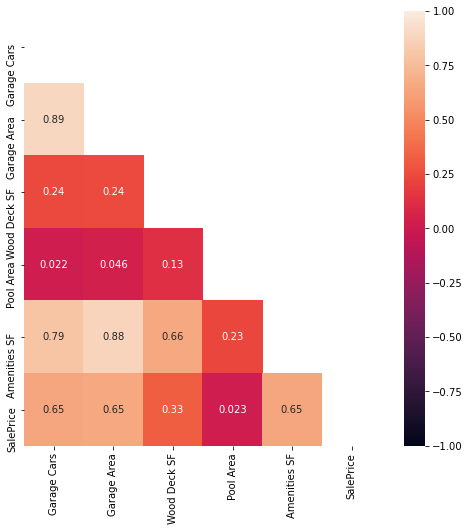

In [147]:
# Plot correlation heatmap
corr_heatmap(data[['Garage Cars', 'Garage Area', 'Wood Deck SF', 'Pool Area',
                   'Amenities SF',  'SalePrice']])

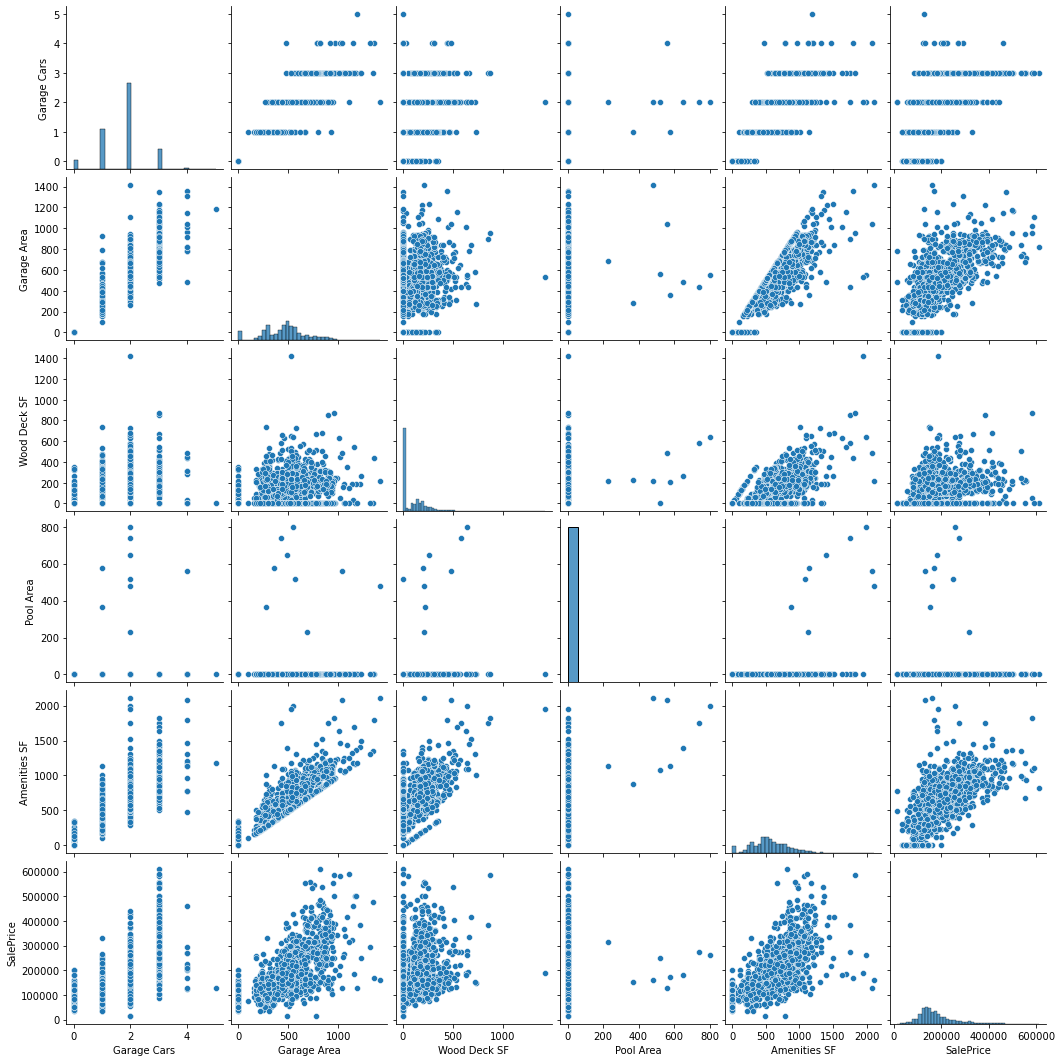

In [148]:
# Plot Pairplot
sns.pairplot(data[['Garage Cars', 'Garage Area', 'Wood Deck SF', 'Pool Area',
                   'Amenities SF',  'SalePrice']])

<AxesSubplot:xlabel='Pool Area', ylabel='SalePrice'>

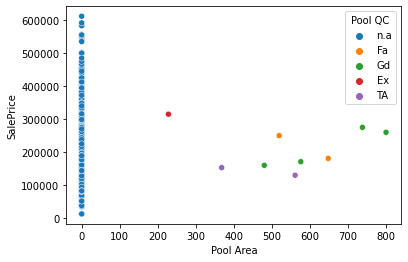

In [149]:
sns.scatterplot(x='Pool Area', y='SalePrice', hue='Pool QC', data=data)

<AxesSubplot:xlabel='Garage Area', ylabel='SalePrice'>

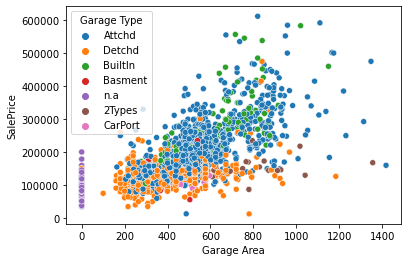

In [150]:
sns.scatterplot(x='Garage Area', y='SalePrice', hue='Garage Type', data=data)

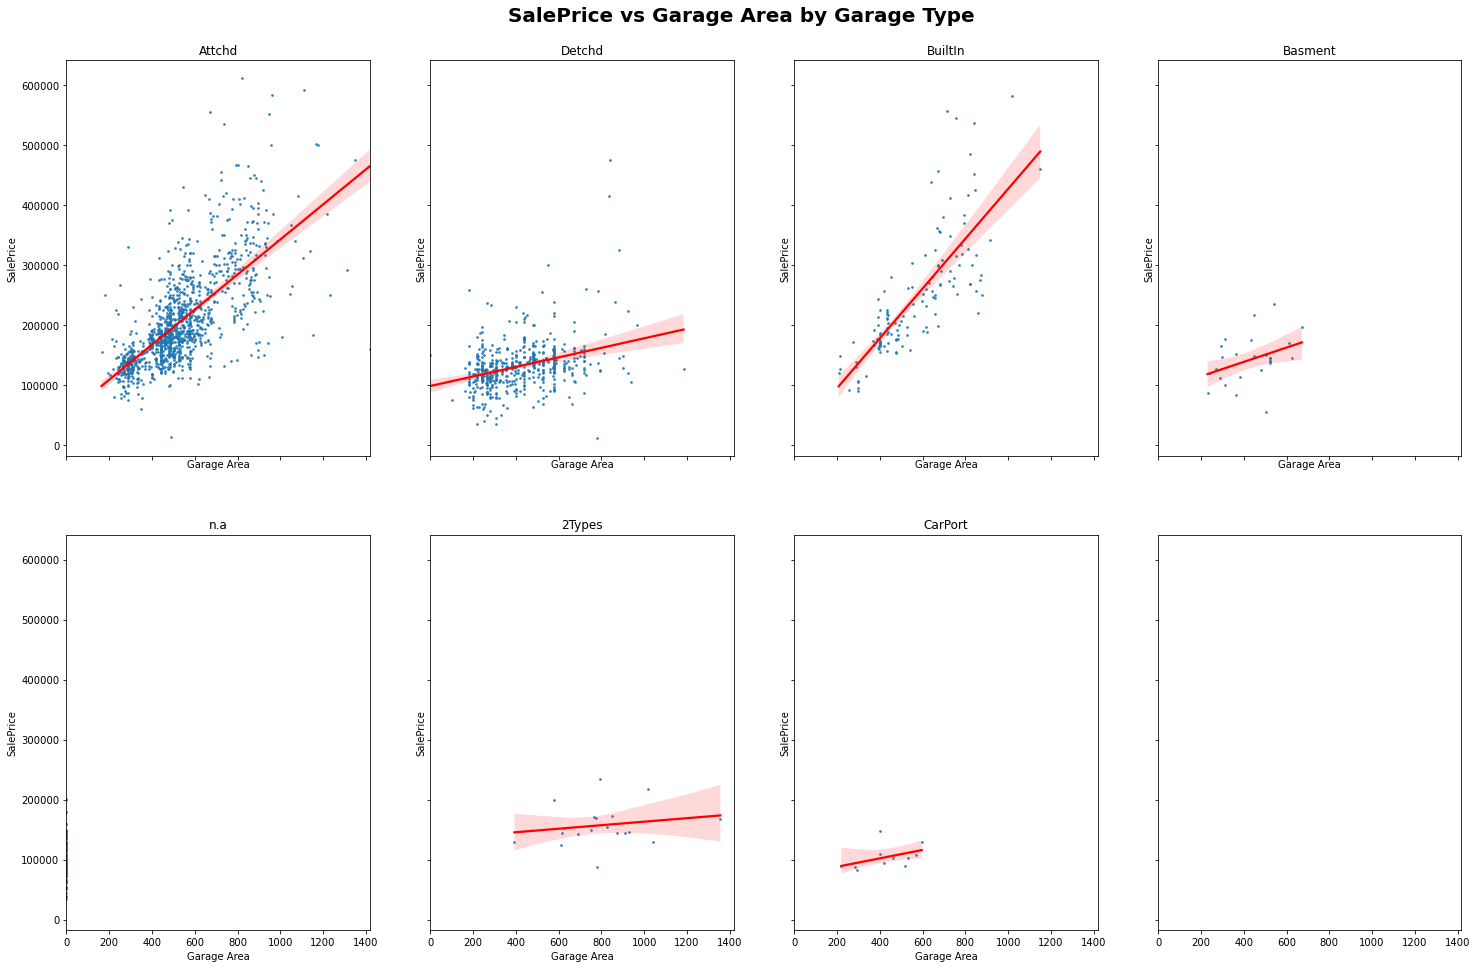

In [151]:
fig, ax = plt.subplots(figsize = (25,15), nrows = 2, ncols = 4, sharex=True, sharey=True)
for i in range(data['Garage Type'].nunique()):
    sns.regplot(x='Garage Area', y='SalePrice', data=data[data['Garage Type']==data['Garage Type'].unique()[i]],
                ax=ax[int(i/4),i%4], line_kws={'color':'red'}, scatter_kws={'s':3})
    ax[int(i/4),i%4].set_title(data['Garage Type'].unique()[i])


fig.suptitle('SalePrice vs Garage Area by Garage Type', fontsize=20, fontweight="bold")
fig.subplots_adjust(top=0.93)

- Insufficient data point to determine the relationship between Pool Area and Sale Price when grouped by their condition.

- To drop 'Garage Cars' in model due to high linearity with 'Garage Area'.
- 'Garage Area' has higher granularity.

In [152]:
# Append 'Garage Area' to list
model_features_list.append('Garage Area')

#### Impact of Fireplaces, Misc Val on SalePrice

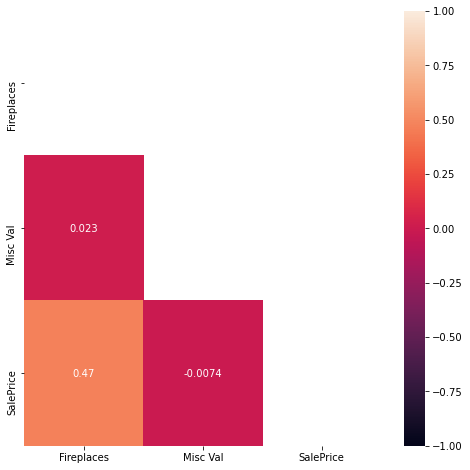

In [153]:
# Plot correlation heatmap
corr_heatmap(data[['Fireplaces', 'Misc Val', 'SalePrice']])

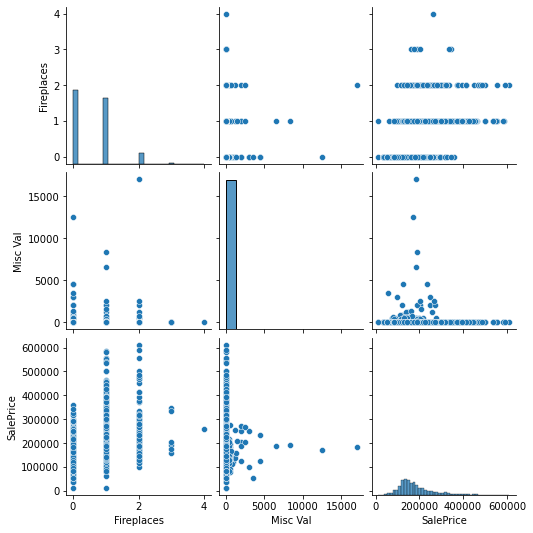

In [154]:
# Plot pairplot
sns.pairplot(data[['Fireplaces', 'Misc Val', 'SalePrice']])

<AxesSubplot:xlabel='Misc Feature', ylabel='Misc Val'>

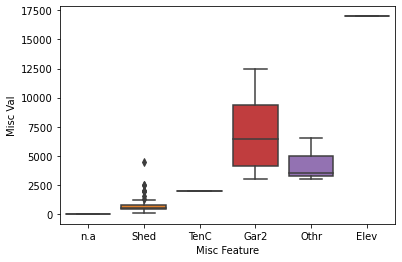

In [155]:
sns.boxplot(x='Misc Feature', y='Misc Val', data=data)

- Drop 'Pool Area' and 'Misc Val' due to low correlation score

In [156]:
# Append 'Fireplaces', 'Wood Deck SF' to list
model_features_list.extend(['Fireplaces', 'Wood Deck SF'])

#### Impact of Porch on SalePrice

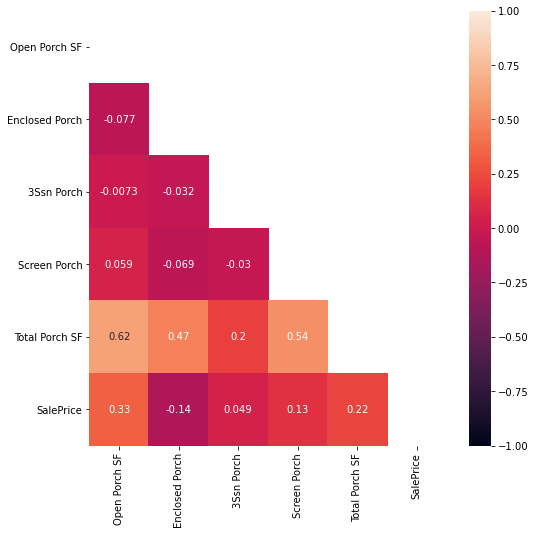

In [157]:
# Plot correlation heatmap
corr_heatmap(data[['Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Total Porch SF', 'SalePrice']])

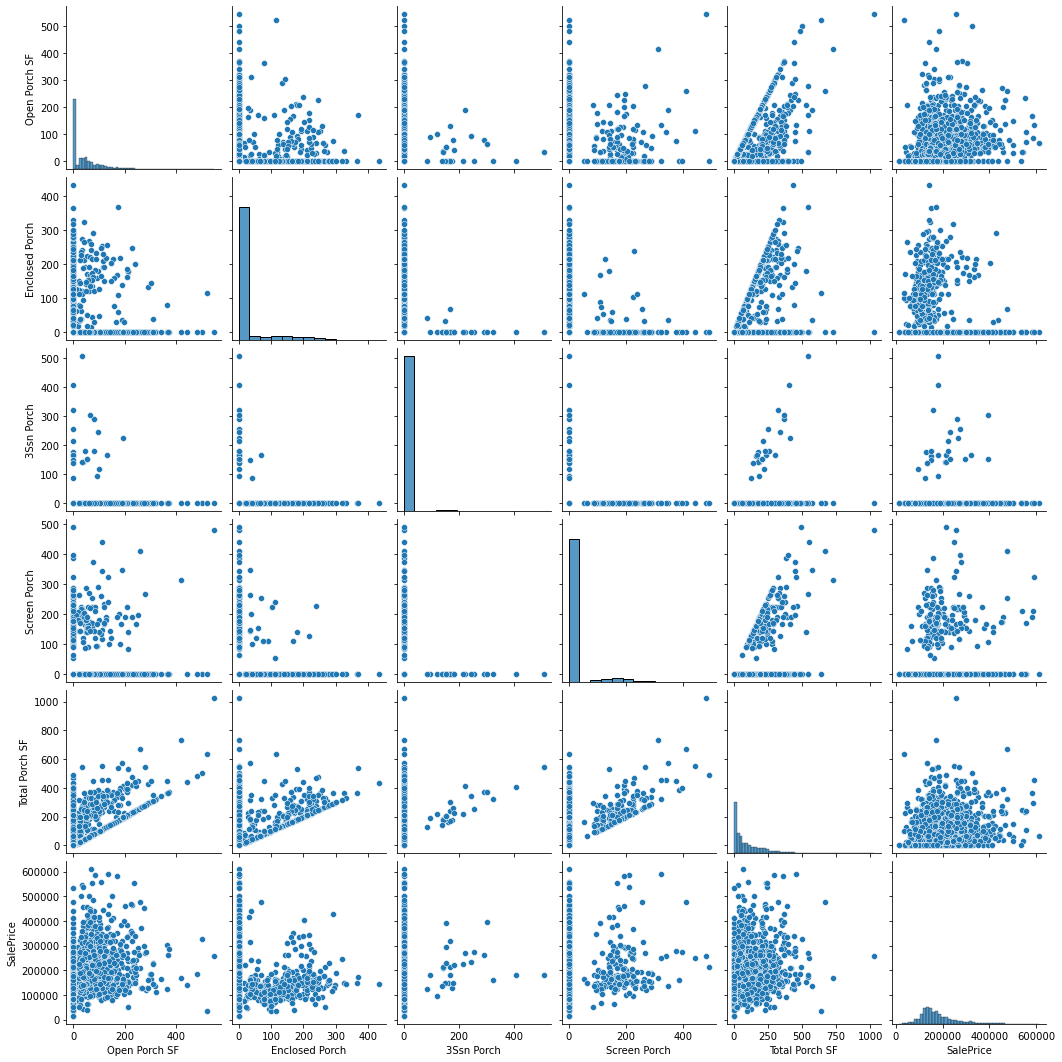

In [158]:
# Plot pairplot
sns.pairplot(data[['Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Total Porch SF', 'SalePrice']])

- To drop '3Ssn Porch' due to low correlation score

In [159]:
# Append 'Open Porch SF', 'Enclosed Porch', 'Screen Porch' to list
model_features_list.extend(['Open Porch SF', 'Enclosed Porch', 'Screen Porch'])

#### Impact of Mo Sold and Yr Sold on SalePrice

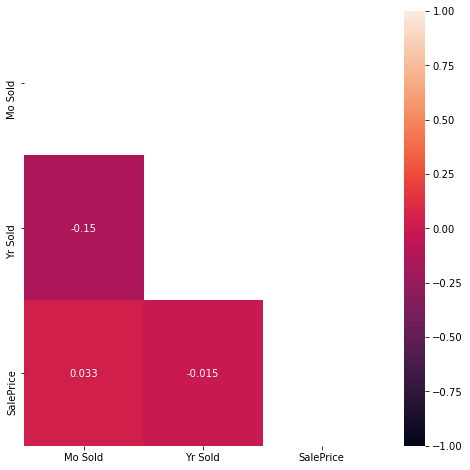

In [160]:
# Plot correlation heatmap
corr_heatmap(data[['Mo Sold', 'Yr Sold', 'SalePrice']])

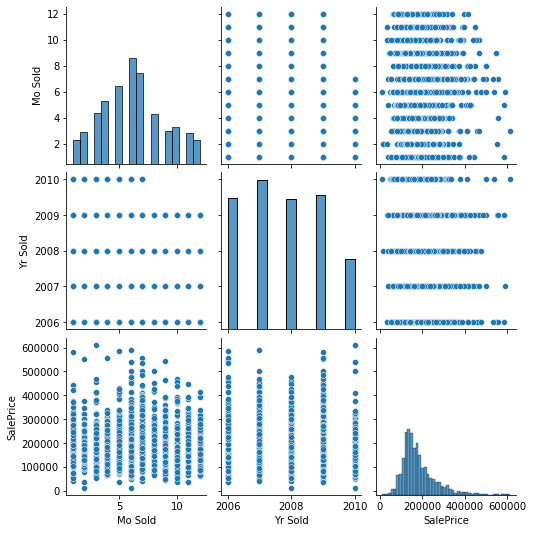

In [161]:
# Plot pairplot
sns.pairplot(data[['Mo Sold', 'Yr Sold', 'SalePrice']])

- To drop 'Mo Sold' and 'Yr Sold' due to low correlation score

#### Checking Impact of Categorical Features on SalePrice

Plotting SalePrice boxplot and counts bar graph for each categorical feature

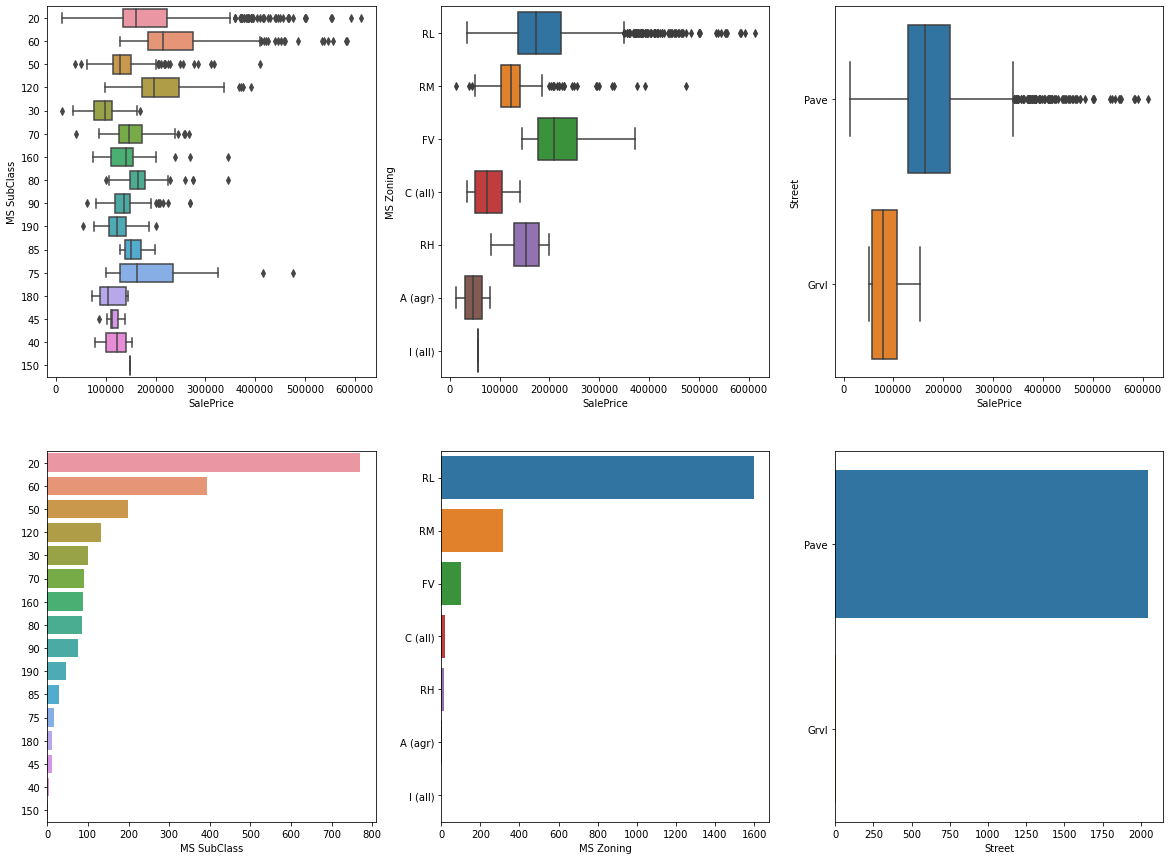

In [162]:
boxplot_count_subplot('SalePrice', ['MS SubClass', 'MS Zoning', 'Street'], data=data, row=2 , col=3, figure_size=(20, 15))

- To use MS SubClass, MS Zoning as primary categorical features
- Street as secondary categorical features for minute improvement due to majority of data is from Pave

In [163]:
model_features_list.extend(['MS SubClass', 'MS Zoning'])
secondary_model_features_list.append('Street')

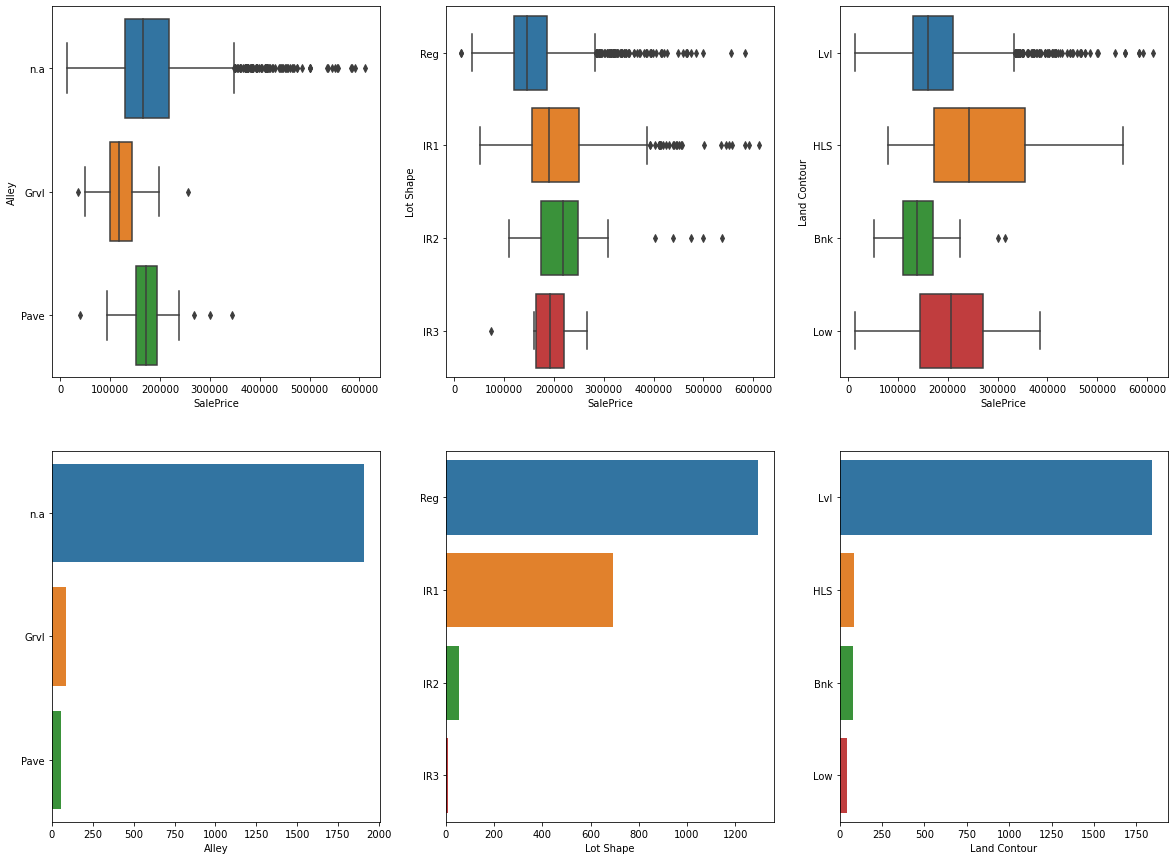

In [164]:
boxplot_count_subplot('SalePrice', ['Alley', 'Lot Shape', 'Land Contour'], data=data, row=2 , col=3, figure_size=(20, 15))

- To use Land Contour as primary feature
- Alley and Lot Shape as secondary features

In [165]:
model_features_list.extend(['Land Contour'])
secondary_model_features_list.extend(['Alley', 'Lot Shape'])

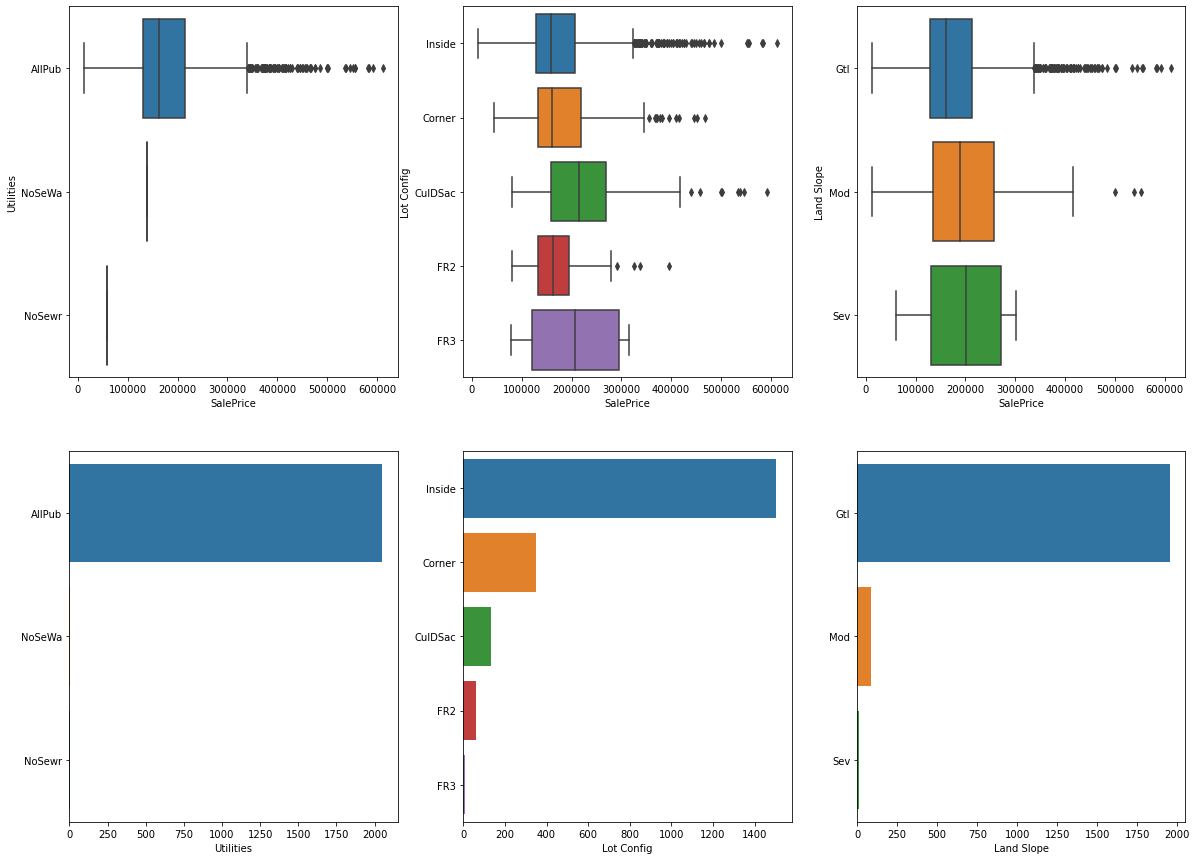

In [166]:
boxplot_count_subplot('SalePrice', ['Utilities', 'Lot Config', 'Land Slope'], data=data, row=2 , col=3, figure_size=(20, 15))

- Utilities as secondary feature as majority of data is AllPub
- Lot Config as secondary feature as the median between each groups are not distinct
- To drop Land Slope as all 3 categories has very similar median and interquartile so it would not provide any additional resolution

In [167]:
secondary_model_features_list.extend(['Utilities', 'Lot Config'])

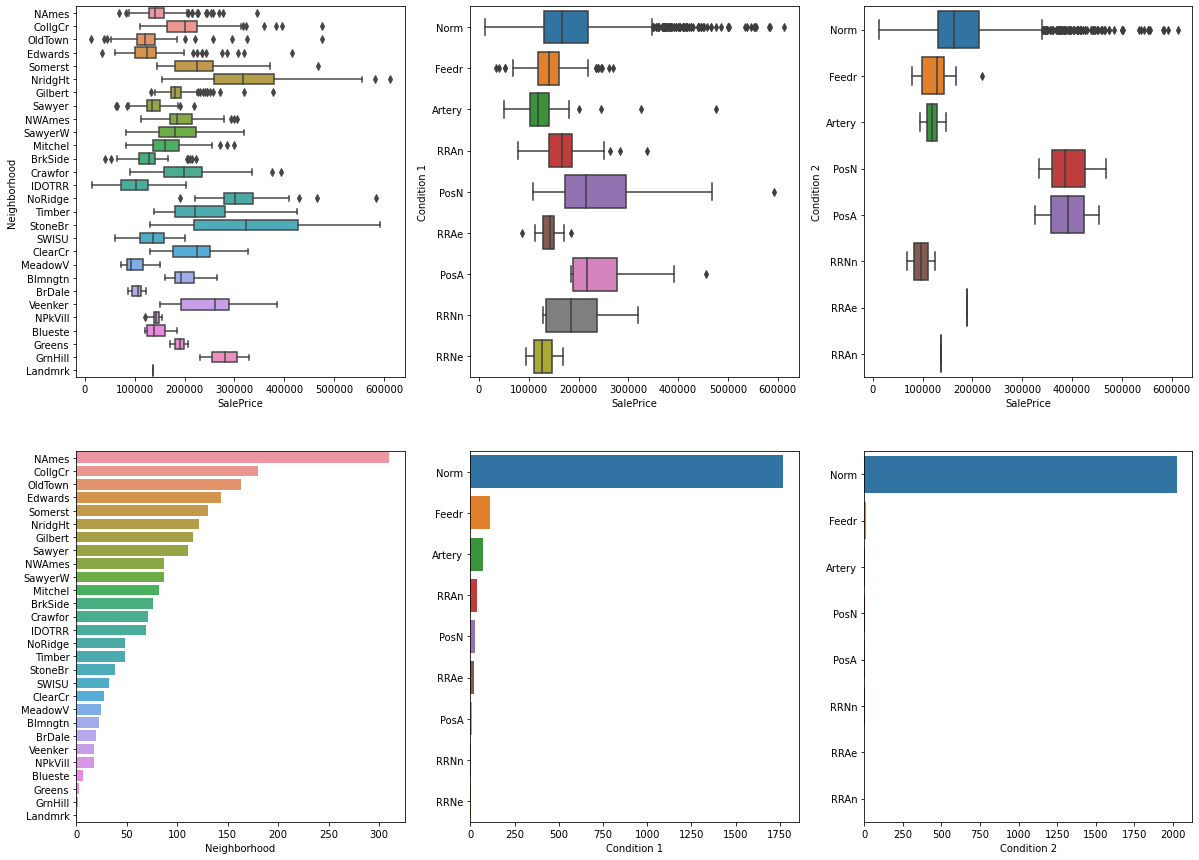

In [168]:
boxplot_count_subplot('SalePrice', ['Neighborhood', 'Condition 1', 'Condition 2'], data=data, row=2 , col=3, figure_size=(20, 15))

- Neighborhood as primary feature as the SalePrice greatlt varies depending on the neighborhood the house is in.
- Condition 1 and 2 as secondary due to the low count for other categories

In [169]:
model_features_list.extend(['Neighborhood'])
secondary_model_features_list.extend(['Condition 1', 'Condition 2'])

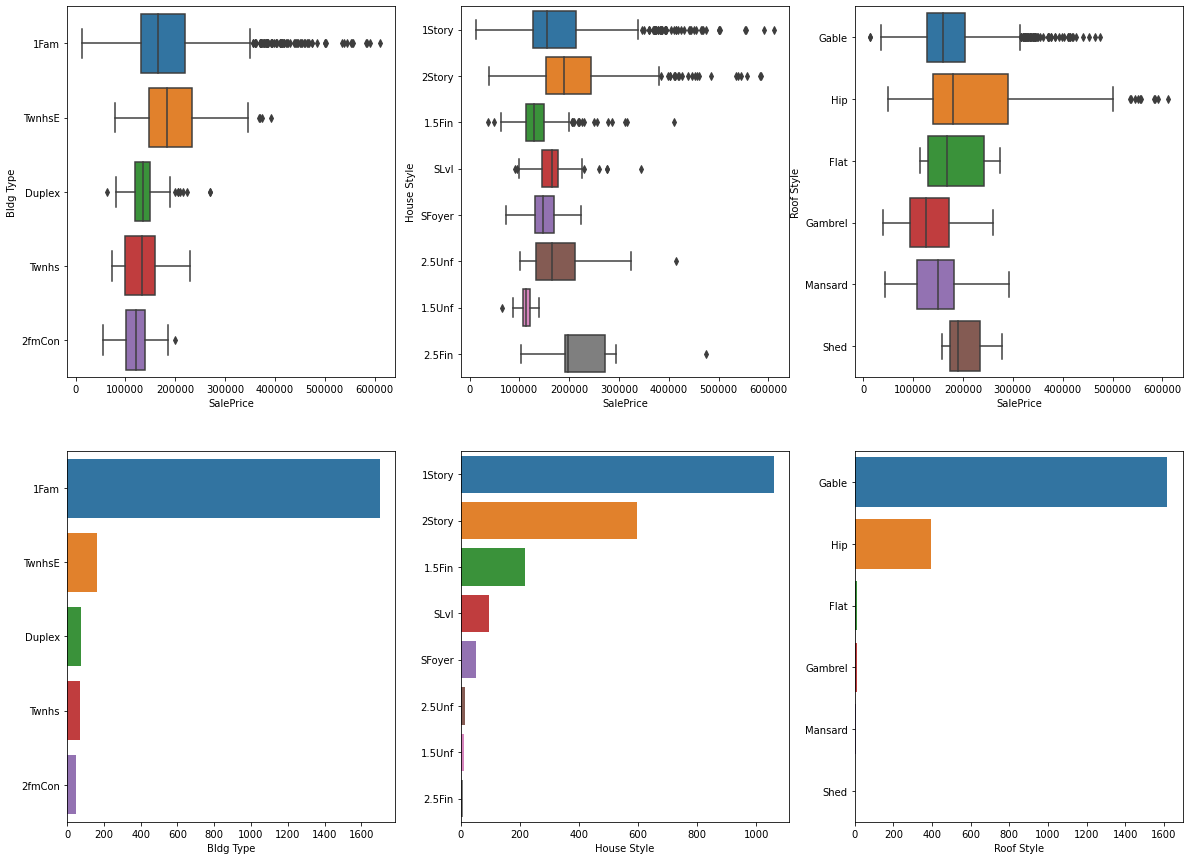

In [170]:
boxplot_count_subplot('SalePrice', ['Bldg Type', 'House Style', 'Roof Style'], data=data, row=2 , col=3, figure_size=(20, 15))

- House Style as primary as there is a distinct seperation in SalePrice for each category
- Bldg Type as secodnary due to median of each category being similar
- Roof Style as secondary as median for each category is similar

In [171]:
model_features_list.extend(['House Style'])
secondary_model_features_list.extend(['Bldg Type', 'Roof Style'])

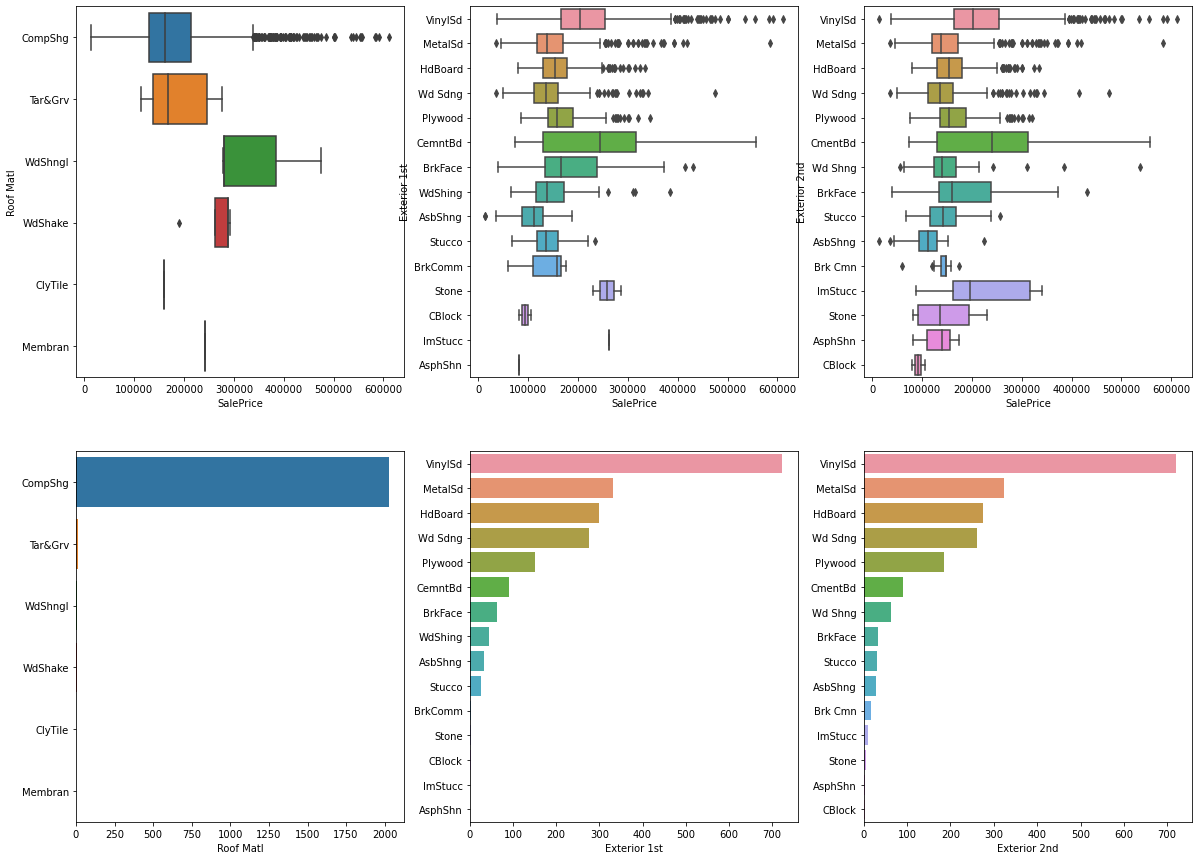

In [172]:
boxplot_count_subplot('SalePrice', ['Roof Matl', 'Exterior 1st', 'Exterior 2nd'], data=data, row=2 , col=3, figure_size=(20, 15))

- Roof Matl to be used as secondary feature as majority of data is using CompShg and will be used for minute improvement
- Exterior 1st and Exterior 2nd to be used as primary due to some cetegories having higher SalePrice

In [173]:
model_features_list.extend(['Exterior 1st', 'Exterior 2nd'])
secondary_model_features_list.extend(['Roof Matl'])

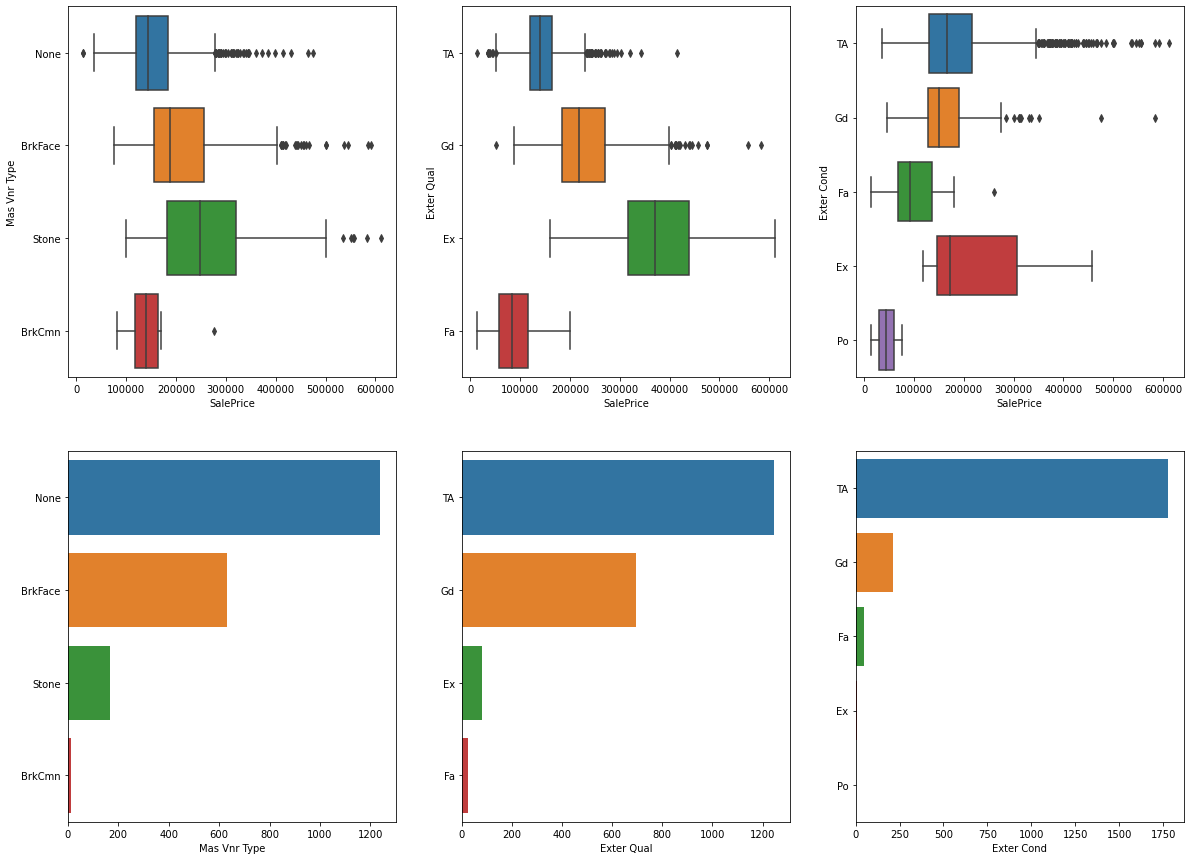

In [174]:
boxplot_count_subplot('SalePrice', ['Mas Vnr Type', 'Exter Qual', 'Exter Cond'], data=data, row=2 , col=3, figure_size=(20, 15))

- Mas Vnr Type and Exter Qual to be used as primary as there SalePrice varies with each category
- Exter Cond as secondary as majority of data is between TA and Gd and both have similar median values. To use for minute improvement of model.

In [175]:
model_features_list.extend(['Mas Vnr Type', 'Exter Qual'])
secondary_model_features_list.extend(['Exter Cond'])

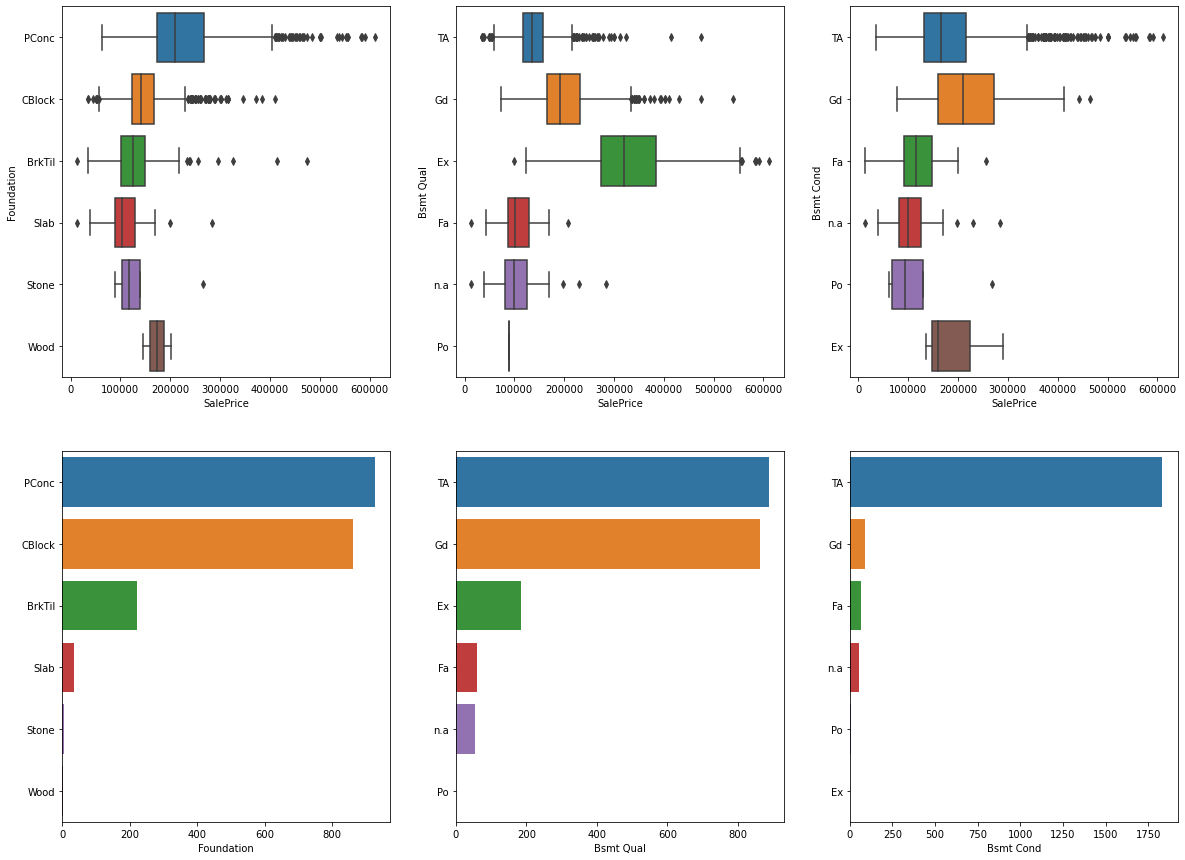

In [176]:
boxplot_count_subplot('SalePrice', ['Foundation', 'Bsmt Qual', 'Bsmt Cond'], data=data, row=2 , col=3, figure_size=(20, 15))

- Foundation and Bsmt Qual as primary as each category has distinct SalePrice.
- Bsmt Cond as secondary as majority of data is TA. To use for minute improvement since there is SalePrice differs for each category

In [177]:
model_features_list.extend(['Foundation', 'Bsmt Qual'])
secondary_model_features_list.extend(['Bsmt Cond'])

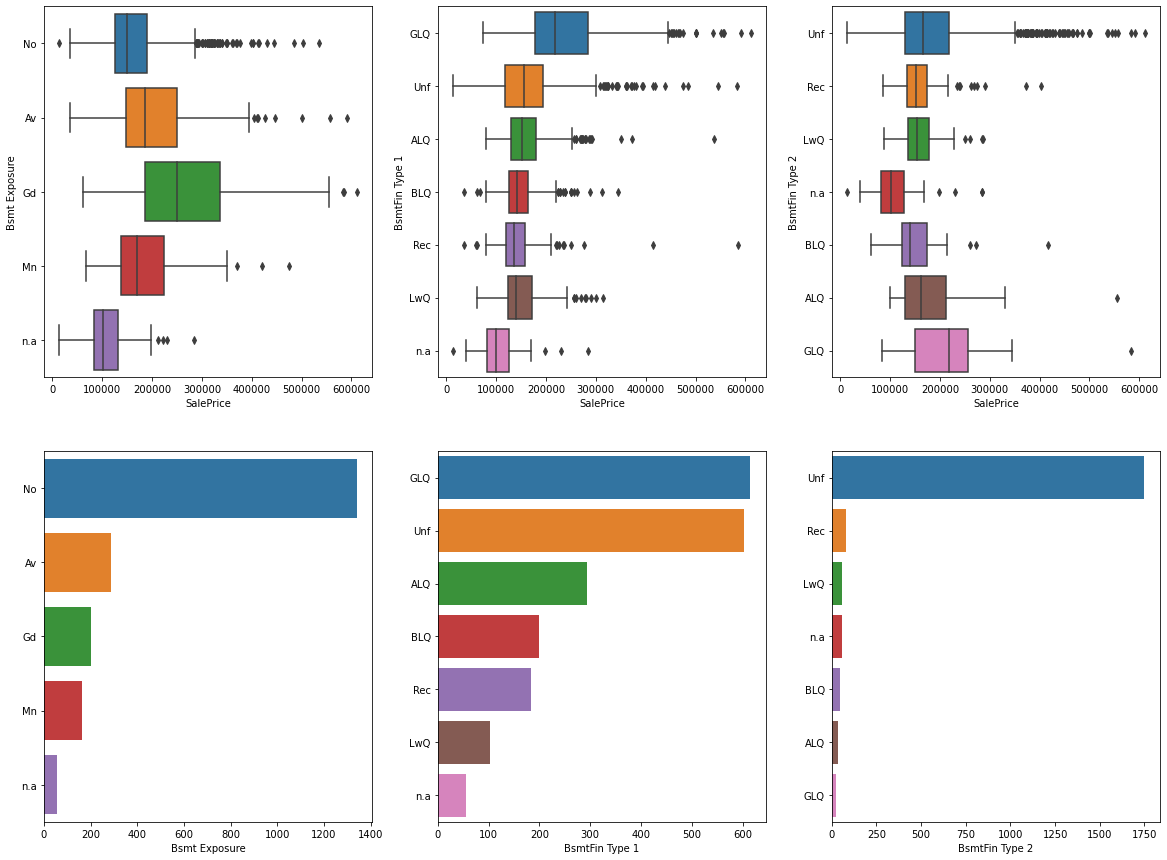

In [178]:
boxplot_count_subplot('SalePrice', ['Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2'], data=data, row=2 , col=3, figure_size=(20, 15))

- Bsmt Exposure as primary as each category has distinct SalePrice
- BsmtFin Type 1 and 2 as secondary due to multiple caetgories having similar SalePrice

In [179]:
model_features_list.extend(['Bsmt Exposure'])
secondary_model_features_list.extend(['BsmtFin Type 1', 'BsmtFin Type 2'])

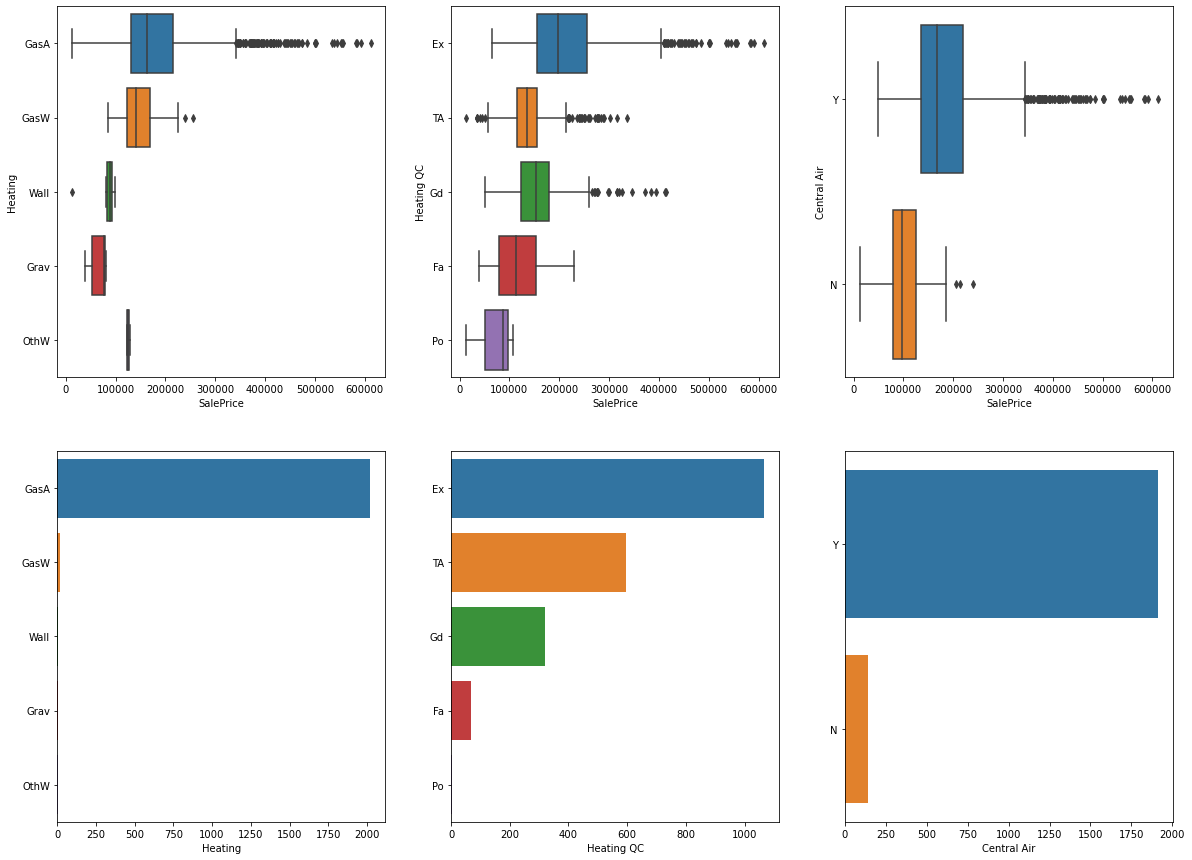

In [180]:
boxplot_count_subplot('SalePrice', ['Heating', 'Heating QC', 'Central Air'], data=data, row=2 , col=3, figure_size=(20, 15))

- Heating as secondary as majority of data is GasA
- Heating QC and Central Air as primary as each category has distinct SalePrice

In [181]:
model_features_list.extend(['Heating QC', 'Central Air'])
secondary_model_features_list.extend(['Heating'])

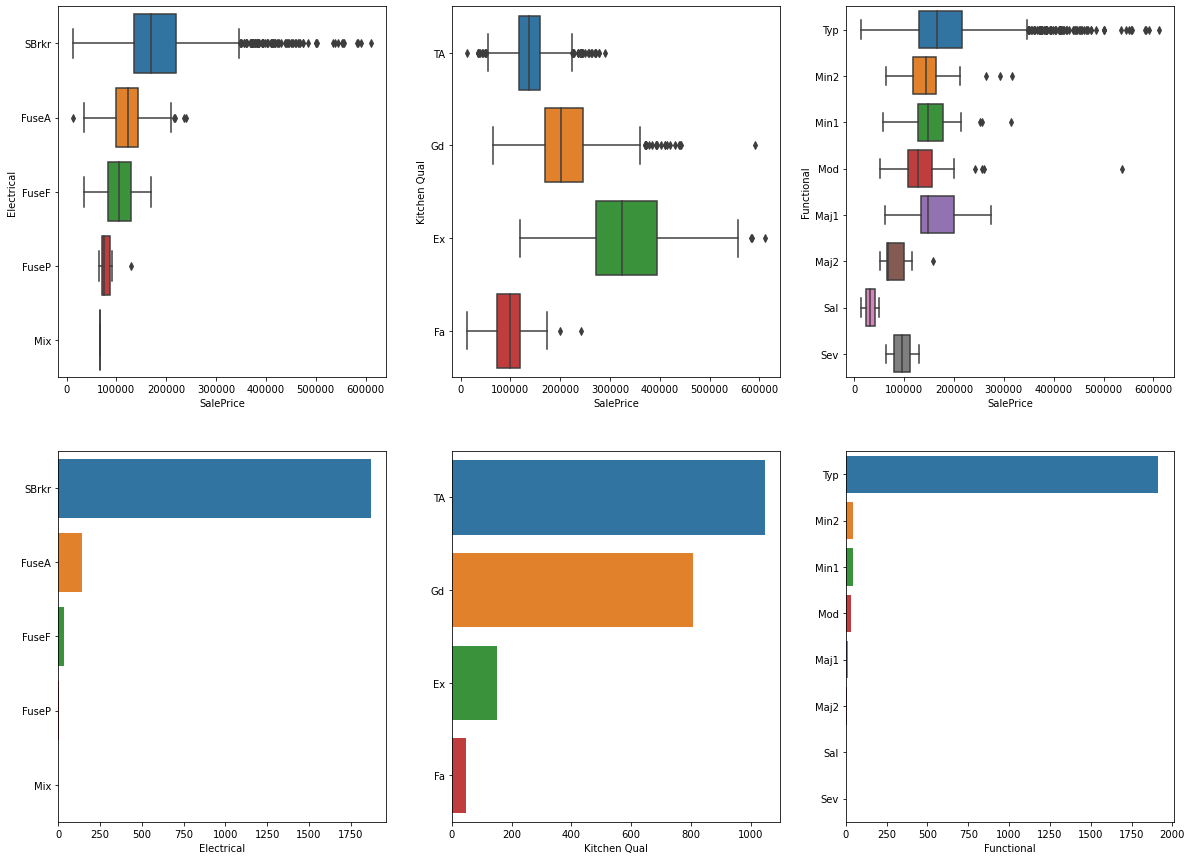

In [182]:
boxplot_count_subplot('SalePrice', ['Electrical', 'Kitchen Qual', 'Functional'], data=data, row=2 , col=3, figure_size=(20, 15))

- Electrical and Kitchen Qual as primary as there is a distinct Sale Price for each group
- Functional as secondary as majority of data is Typ. To used for minute adjustment as some groups show low price

In [183]:
model_features_list.extend(['Electrical', 'Kitchen Qual'])
secondary_model_features_list.extend(['Functional'])

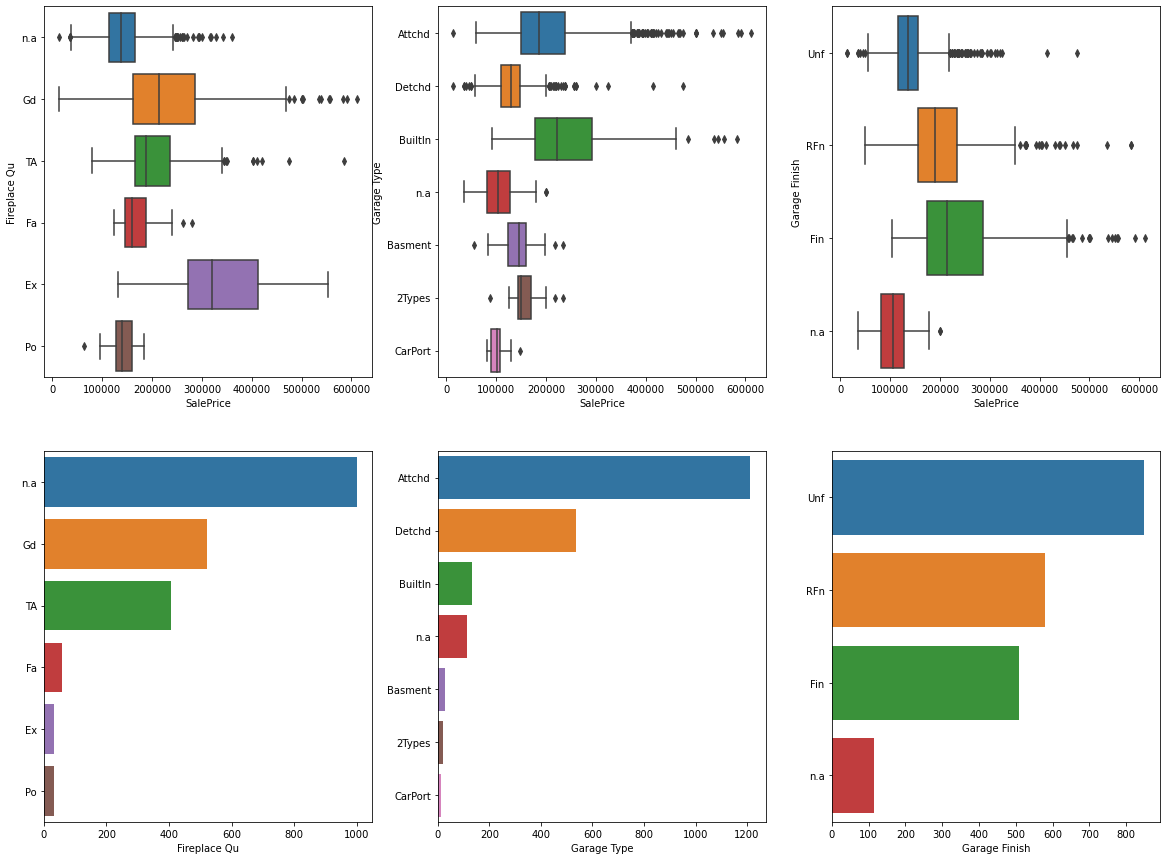

In [184]:
boxplot_count_subplot('SalePrice', ['Fireplace Qu', 'Garage Type', 'Garage Finish'], data=data, row=2 , col=3, figure_size=(20, 15))

- Fireplace Qu, Garage Type and Garage Finish as primary as there is SalePrice distinction for each group

In [185]:
model_features_list.extend(['Fireplace Qu', 'Garage Type', 'Garage Finish'])

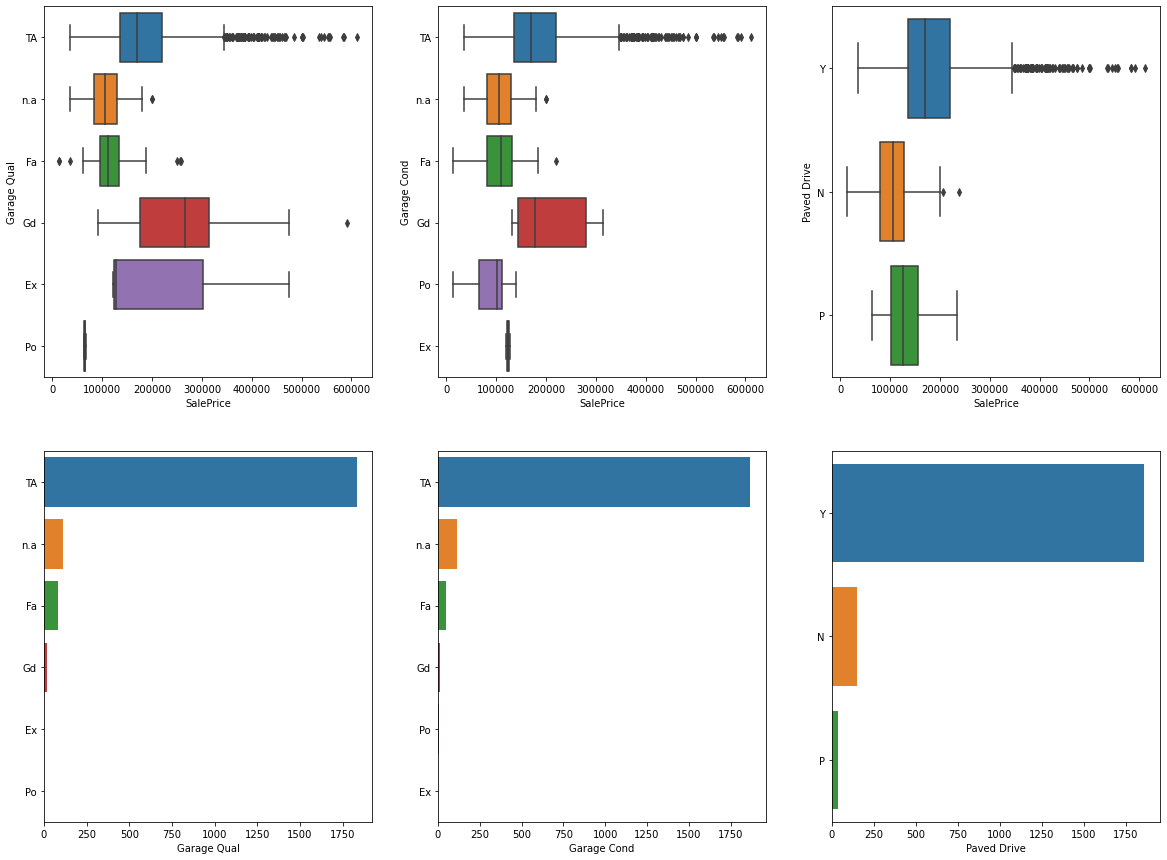

In [186]:
boxplot_count_subplot('SalePrice', ['Garage Qual', 'Garage Cond', 'Paved Drive'], data=data, row=2 , col=3, figure_size=(20, 15))

- To use Garage Qual as secondary categories with distinct SalePrice has low counts. To use for minute improvement to model
- Garage Cond and Paved Drive as secodnary as the median value for each group does not differ from each other too significantly and value counts are low for most categories

In [187]:
secondary_model_features_list.extend(['Garage Qual', 'Garage Cond', 'Paved Drive'])

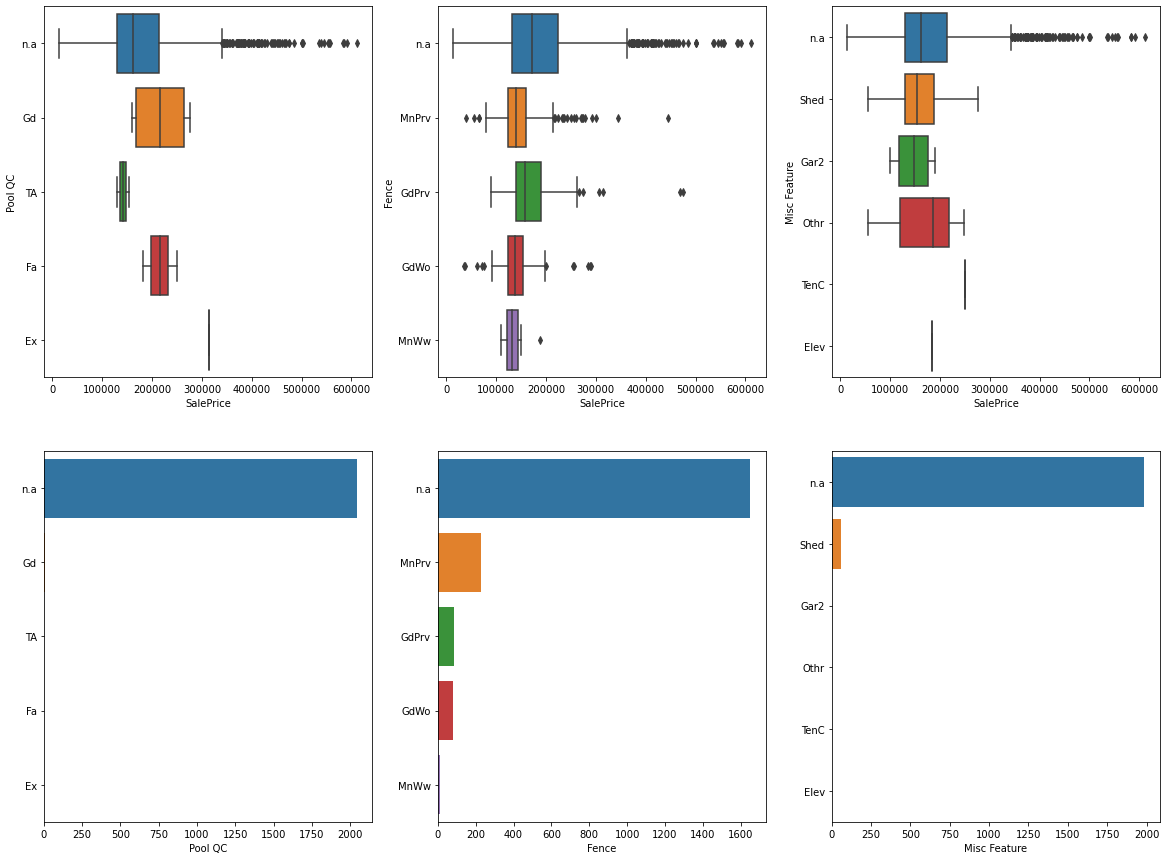

In [188]:
boxplot_count_subplot('SalePrice', ['Pool QC', 'Fence', 'Misc Feature'], data=data, row=2 , col=3, figure_size=(20, 15))

- Pool QC and Misc Feature as secondary feature as there are certain categories with distinct SalePrice despite low counts
- To drop Fence due to similar SalePrice between each category

In [189]:
secondary_model_features_list.extend(['Pool QC', 'Misc Feature'])

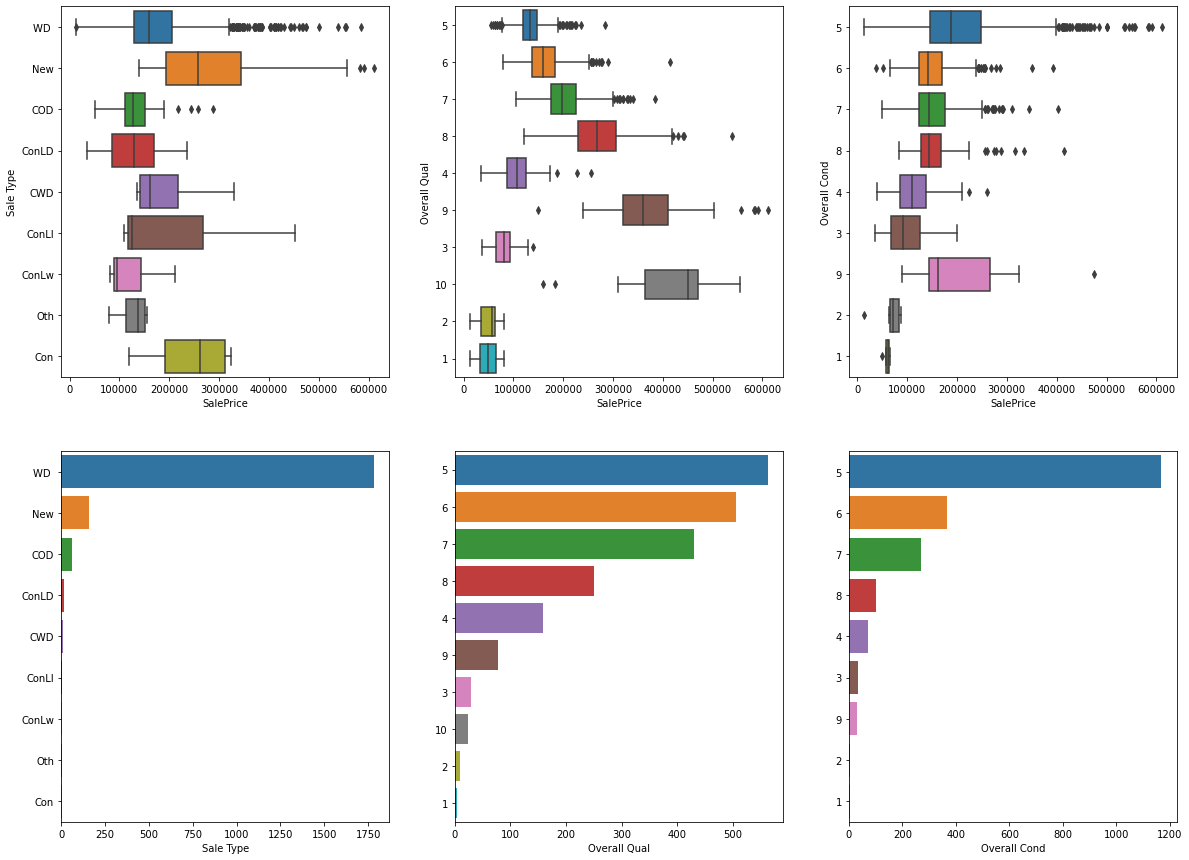

In [190]:
boxplot_count_subplot('SalePrice', ['Sale Type', 'Overall Qual', 'Overall Cond'], data=data, row=2 , col=3, figure_size=(20, 15))

- Sale Type as primary as the categories are showing different SalePrice

In [191]:
model_features_list.extend(['Sale Type'])

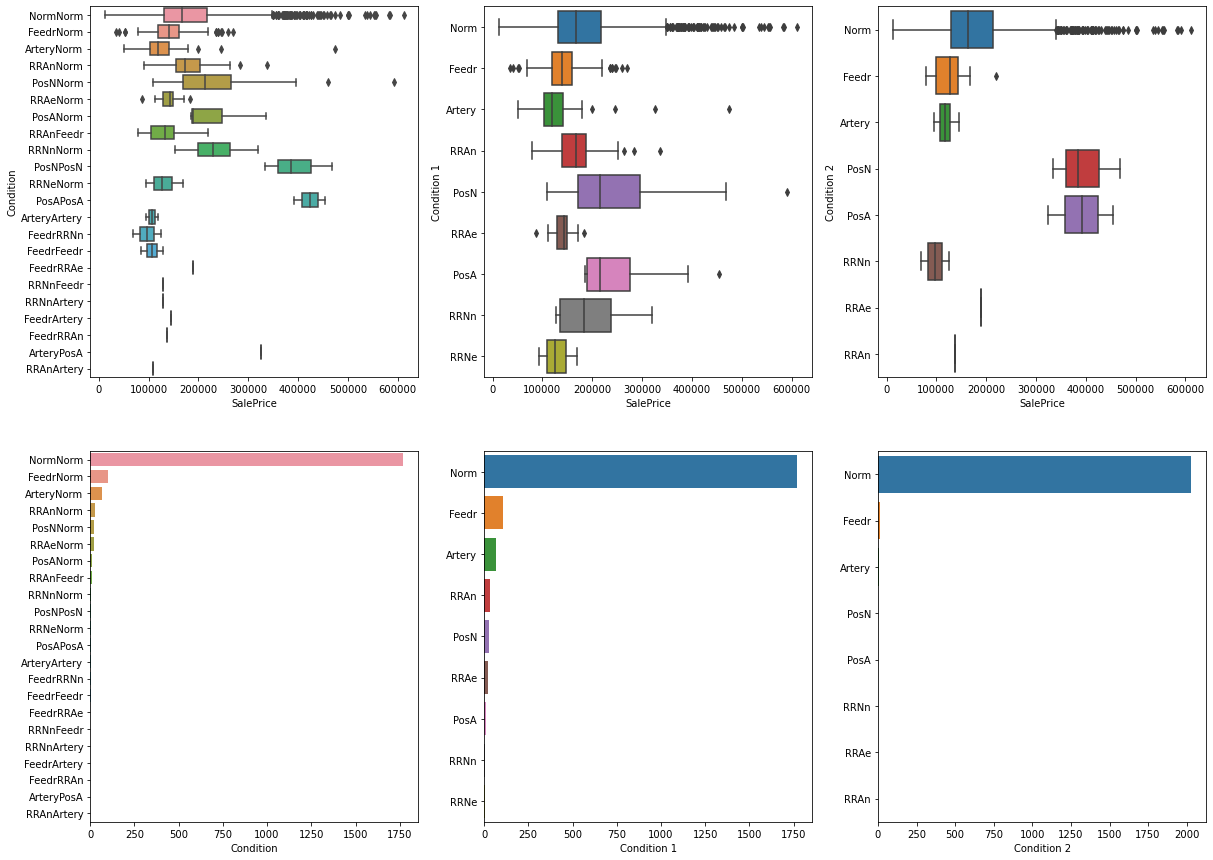

In [192]:
boxplot_count_subplot('SalePrice', ['Condition', 'Condition 1', 'Condition 2'], data=data, row=2 , col=3, figure_size=(20, 15))

- As Condition has more granularity, to drop Condition 1 and Condition 2 from secondary_model_features_list and use Condition as primary

<AxesSubplot:xlabel='House Style', ylabel='SalePrice'>

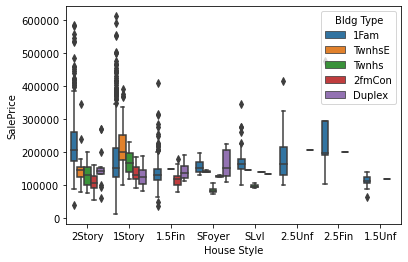

In [193]:
sns.boxplot(x='House Style', y='SalePrice', hue='Bldg Type', data=data)

<AxesSubplot:xlabel='House Style', ylabel='SalePrice'>

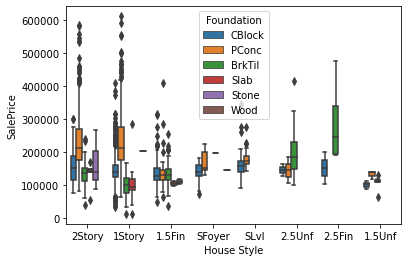

In [194]:
sns.boxplot(x='House Style', y='SalePrice', hue='Foundation', data=data)

<AxesSubplot:xlabel='Garage Type', ylabel='SalePrice'>

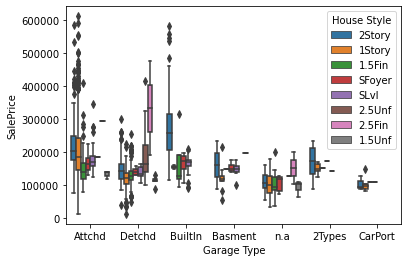

In [195]:
sns.boxplot(x='Garage Type', y='SalePrice', hue='House Style', data=data)

In [196]:
secondary_model_features_list.remove('Condition 1')
secondary_model_features_list.remove('Condition 2')
model_features_list.append('Condition')

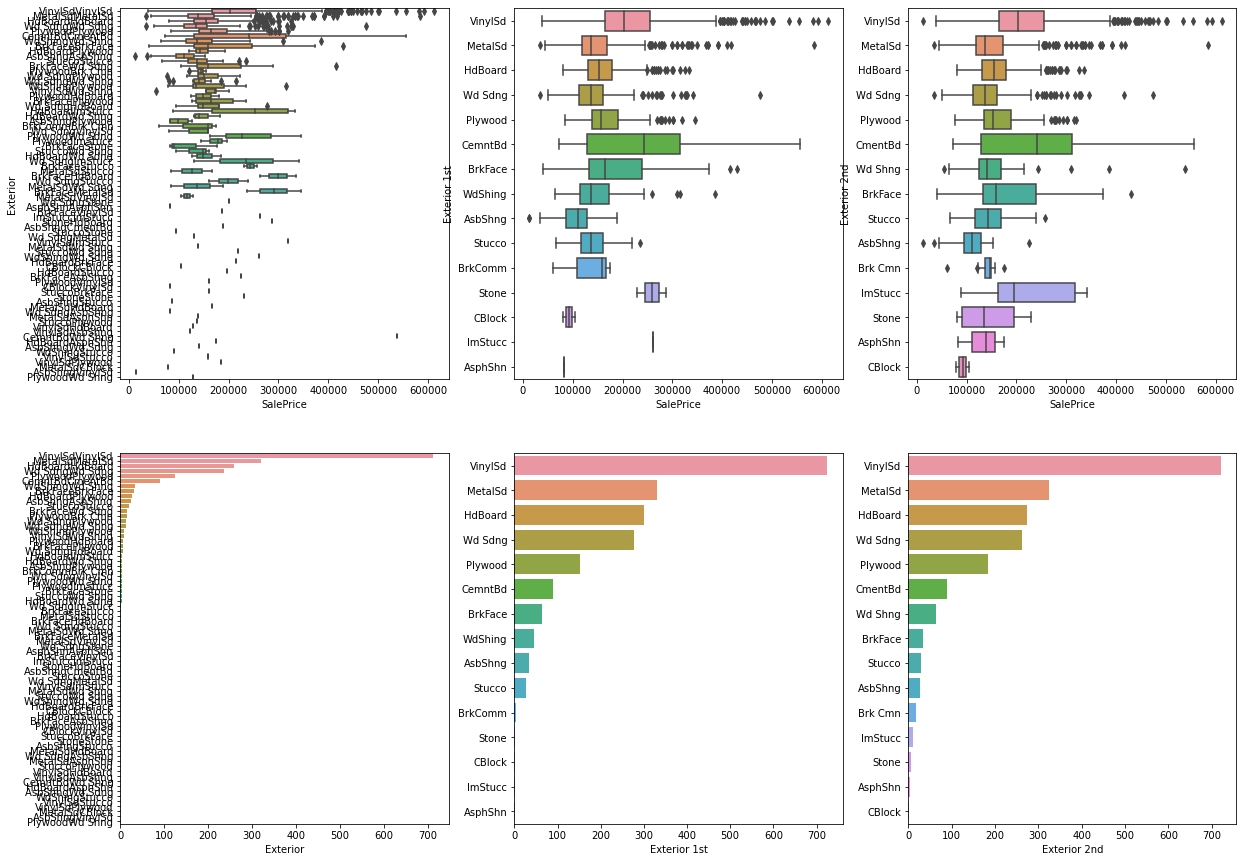

In [197]:
boxplot_count_subplot('SalePrice', ['Exterior', 'Exterior 1st', 'Exterior 2nd'], data=data, row=2 , col=3, figure_size=(20, 15))

- To use Exterior due to more granularity for as compared to Exterior 1st and Exterior 2nd

In [198]:
model_features_list.remove('Exterior 1st')
model_features_list.remove('Exterior 2nd')
model_features_list.append('Exterior')

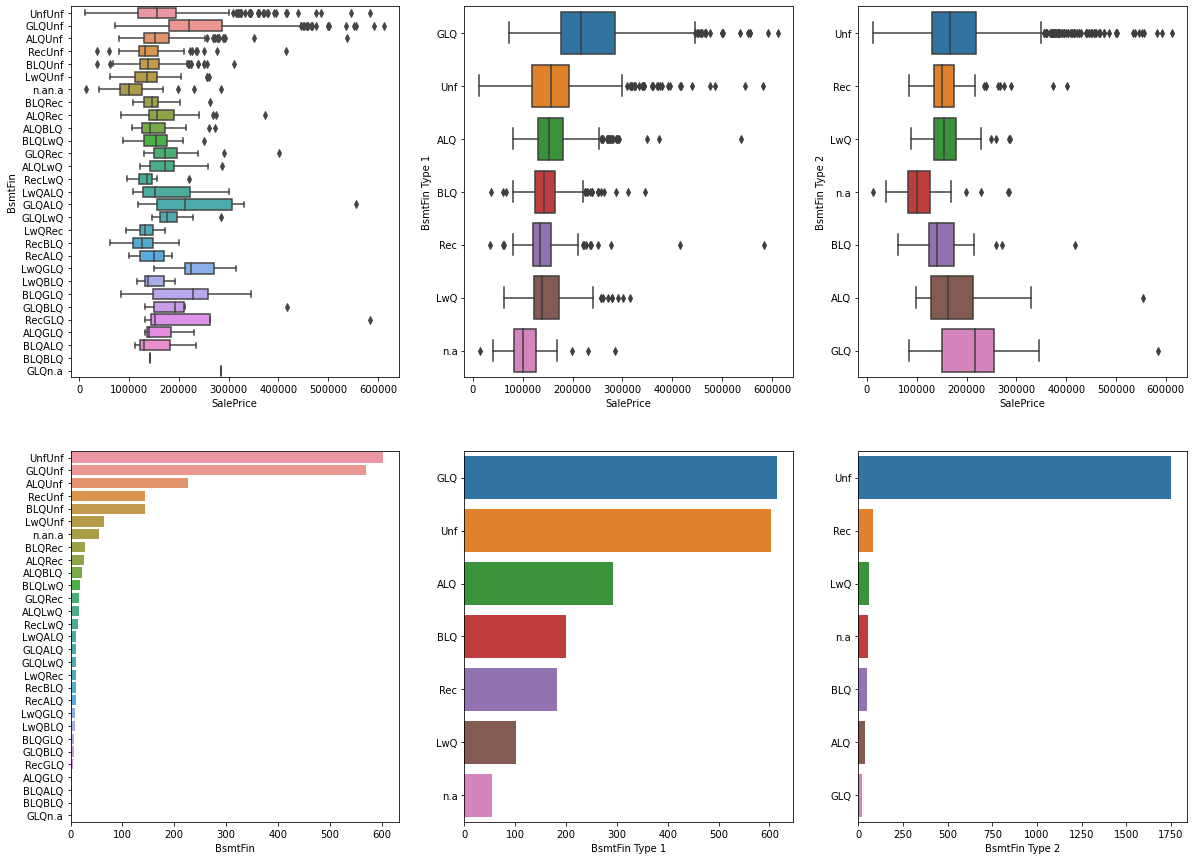

In [199]:
boxplot_count_subplot('SalePrice', ['BsmtFin', 'BsmtFin Type 1', 'BsmtFin Type 2'], data=data, row=2 , col=3, figure_size=(20, 15))

- To use BsmtFin as primary feature instead of BsmtFin Type 1 and 2 due to higher granularity

In [200]:
secondary_model_features_list.remove('BsmtFin Type 1')
secondary_model_features_list.remove('BsmtFin Type 2')
model_features_list.append('BsmtFin')

### Modeling

In [ ]:
model_features_list = ['Age_Sold', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Overall Qual',
                       'Garage Area', 'Land Contour', 'Neighborhood', 'Exter Qual', 'Bsmt Qual',
                       'Bsmt Exposure', 'Heating QC', 'Kitchen Qual', 'Bldg Type', 'No Of Bath',
                       'TotRms AbvGrd', 'Screen Porch', 'Mas Vnr Area Available',
                       'Total Bsmt SF Available', '2nd Flr SF Available', 'Garage Area Available',
                       'Wood Deck SF Available', 'Total Porch SF Available', 'Pool Area Available']

In [317]:
model_features_list = ['Age_Sold', 'Lot Area', '1st Flr SF', 'Total Bsmt SF', 'Mas Vnr Area',
                       'Gr Liv Area', 'TotRms AbvGrd', 'No Of Bath', 'Garage Area',
                       'Fireplaces', 'Misc Val', 'Land Slope', 'Neighborhood']

In [ ]:
'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure','Mas Vnr Type', 'Garage Type', 'Misc Feature'

#### Prepare train and validation data

In [364]:
# Prep Data
X = prep(clean(data_ori))

# Drop rows with NA
X.dropna(inplace=True)

# Assign required DataFrame data to variable X and y
y = X['SalePrice'].copy()
X = X[model_features_list].copy()
X_poly_df = X[model_features_list]

'''
# One Hot Encoding X
X_OHE = pd.get_dummies(data = X, drop_first=True)


# Feature Engineered Features
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_OHE)
X_poly_df = pd.DataFrame(data=X_poly, columns=poly.get_feature_names(X_OHE.columns))
X_poly_df
'''

'\n# One Hot Encoding X\nX_OHE = pd.get_dummies(data = X, drop_first=True)\n\n\n# Feature Engineered Features\npoly = PolynomialFeatures(interaction_only=True, include_bias=False)\nX_poly = poly.fit_transform(X_OHE)\nX_poly_df = pd.DataFrame(data=X_poly, columns=poly.get_feature_names(X_OHE.columns))\nX_poly_df\n'

In [365]:
# Feature Engineer Lot Area and Land Slope
# One Hot Encoding X
features = ['Lot Area', 'Land Slope']
X_OHE_temp = pd.get_dummies(data = X[features], drop_first=False)

# Features Engineering
poly_temp = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly_temp = poly.fit_transform(X_OHE_temp)
X_poly_df_temp = pd.DataFrame(data=X_poly_temp, columns=poly.get_feature_names(X_OHE_temp.columns))
X_poly_df_temp['Log_Lot Area Land Slope_Sev'] = np.log(X_poly_df_temp['Lot Area']) * X_poly_df_temp['Land Slope_Sev']
X_poly_df_temp.drop(columns='Lot Area', inplace=True)

# Merge Data to X
X_poly_df = pd.merge(left = X_poly_df,
                right = X_poly_df_temp,
                how = "inner",
                left_index = True,
                right_index = True)
X_poly_df.drop(columns=['Land Slope'], inplace=True)

In [366]:
# Feature Engineer Lot Area and Neighborhood
# One Hot Encoding X
features = ['Lot Area', 'Neighborhood']
X_OHE_temp = pd.get_dummies(data = X[features], drop_first=False)
X_poly_df_temp = X_OHE_temp

# Features Engineering
for feature in X_OHE_temp.columns[1:]:
    new_feature = 'Lot Area' + ' ' + feature
    X_poly_df_temp[new_feature] = X_poly_df_temp[feature] * X_poly_df_temp['Lot Area']
    

X_poly_df_temp['Log_Lot Area Neighborhood_ClearCr'] = np.log(X_poly_df_temp['Lot Area']) * X_poly_df_temp['Neighborhood_ClearCr']
X_poly_df_temp.drop(columns='Lot Area', inplace=True)

# Merge Data to X
X_poly_df = pd.merge(left = X_poly_df,
                right = X_poly_df_temp,
                how = "inner",
                left_index = True,
                right_index = True)
X_poly_df.drop(columns=['Neighborhood'], inplace=True)

In [368]:
# Feature Engineer  1st Flr SF and Neighborhood
# One Hot Encoding X
features = ['1st Flr SF', 'Neighborhood']
X_OHE_temp = pd.get_dummies(data = X[features], drop_first=False)
X_poly_df_temp = X_OHE_temp

# Features Engineering
for feature in X_OHE_temp.columns[1:]:
    new_feature = '1st Flr SF' + ' ' + feature
    X_poly_df_temp[new_feature] = X_poly_df_temp[feature] * X_poly_df_temp['1st Flr SF']
    

X_poly_df_temp['Log_Lot Area Neighborhood_ClearCr'] = np.log(X_poly_df_temp['1st Flr SF']) * X_poly_df_temp['Neighborhood_Edwards']
X_poly_df_temp.drop(columns='1st Flr SF', inplace=True)

# Merge Data to X
X_poly_df = pd.merge(left = X_poly_df,
                right = X_poly_df_temp,
                how = "inner",
                left_index = True,
                right_index = True)

In [369]:
X_poly_df.columns

Index(['Age_Sold', 'Lot Area', '1st Flr SF', 'Total Bsmt SF', 'Mas Vnr Area',
       'Gr Liv Area', 'TotRms AbvGrd', 'No Of Bath', 'Garage Area',
       'Fireplaces',
       ...
       '1st Flr SF Neighborhood_NridgHt_y',
       '1st Flr SF Neighborhood_OldTown_y', '1st Flr SF Neighborhood_SWISU_y',
       '1st Flr SF Neighborhood_Sawyer_y', '1st Flr SF Neighborhood_SawyerW_y',
       '1st Flr SF Neighborhood_Somerst_y',
       '1st Flr SF Neighborhood_StoneBr_y', '1st Flr SF Neighborhood_Timber_y',
       '1st Flr SF Neighborhood_Veenker_y',
       'Log_Lot Area Neighborhood_ClearCr'],
      dtype='object', length=192)

In [370]:
# Split Data in Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_poly_df, y, train_size=0.8, random_state = 60)

# Apply Standard Scaler on X_train and X_test
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)

#### Create OLS Model

Using R2:-
Train R2 Score (OLS):  0.8764782171692156
Train R2 Score (OLS with CV):  -6.606619076580995e+25
Validation R2 Score:  -9.154358716512916e+24

Using RMSE:-
Train RMSE Score (OLS):  27548.959680874872
Train RMSE Score (OLS with CV):  2.989112646682994e+17
Validation RMSE Score (OLS):  2.4891517051585878e+17


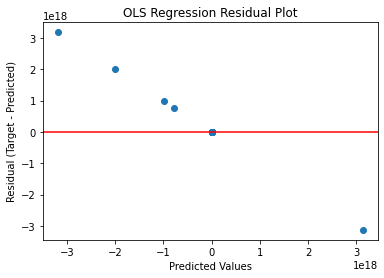

In [371]:
# Instantiate lr as LinearRegression
lr = LinearRegression()

# Fit using OLS
lr.fit(X_train_scaled, y_train)

# Assign cv
cv_value = 5

# R2 Score
print('Using R2:-')
# Training Set Using OLS
print('Train R2 Score (OLS): ', lr.score(X_train_scaled, y_train))

# Training Set Using Cross-Validation
print('Train R2 Score (OLS with CV): ', 
      cross_val_score(lr, X_train_scaled, y_train, cv = cv_value).mean())

# Validation Set Using OLS
print('Validation R2 Score: ', lr.score(X_val_scaled, y_val))


# Using RMSE
print('\nUsing RMSE:-')
# Training Set Using OLS
print('Train RMSE Score (OLS): ', metrics.mean_squared_error(y_train, lr.predict(X_train_scaled))**0.5)

# Training Set Using Cross-Validation
print('Train RMSE Score (OLS with CV): ', 
      abs(cross_val_score(lr, X_train_scaled, y_train, cv = cv_value, scoring='neg_root_mean_squared_error').mean()))

# Validation Set Using OLS
print('Validation RMSE Score (OLS): ', metrics.mean_squared_error(y_val, lr.predict(X_val_scaled))**0.5)

# Plot Residual Plot
residual_plot(model = lr, predictors = X_val_scaled, target = y_val,
              fig_title='OLS Regression Residual Plot')

output_result('OLS',
              model_features_list,
              lr.score(X_train_scaled, y_train),
              cross_val_score(lr, X_train_scaled, y_train, cv = cv_value).mean(),
              lr.score(X_val_scaled, y_val),
              metrics.mean_squared_error(y_train, lr.predict(X_train_scaled))**0.5,
              abs(cross_val_score(lr, X_train_scaled, y_train, cv = cv_value, scoring='neg_root_mean_squared_error').mean()),
              metrics.mean_squared_error(y_val, lr.predict(X_val_scaled))**0.5
             )

In [372]:
for x, y in zip(X_train.columns, lr.coef_):
    print (f'{x}: {y}')

Age_Sold: -14751.868677809352
Lot Area: -4.6486428079557384e+16
1st Flr SF: -8.947762417791016e+16
Total Bsmt SF: 7149.594703612033
Mas Vnr Area: 2151.1385526121057
Gr Liv Area: 28687.456151651422
TotRms AbvGrd: -3364.0092676092554
No Of Bath: 8696.966454968362
Garage Area: 6703.8652784643145
Fireplaces: 8068.0
Misc Val: 1435.0
Land Slope_Gtl: 8.789083411222197e+16
Land Slope_Mod: 8.342934642532286e+16
Land Slope_Sev: 2.87412049273732e+16
Lot Area Land Slope_Gtl: 2.937473991770401e+16
Lot Area Land Slope_Mod: 1.8394425043803644e+16
Lot Area Land Slope_Sev: 3.0208939699165904e+16
Land Slope_Gtl Land Slope_Mod: 1.1046170171373426e+17
Land Slope_Gtl Land Slope_Sev: -1.2314251149865676e+16
Land Slope_Mod Land Slope_Sev: -1.7907318137502556e+16
Log_Lot Area Land Slope_Sev: 28804.0
Neighborhood_Blmngtn_x: -3.569286776787408e+16
Neighborhood_Blueste_x: -7.58049061441927e+16
Neighborhood_BrDale_x: 3.763075156518073e+17
Neighborhood_BrkSide_x: -7.0111795008754936e+16
Neighborhood_ClearCr_x: -3.

#### Create Ridge Regression Model

Best alpha is 100.0

Using R2:-
Train R2 Score (OLS):  0.8655434786707906
Train R2 Score (OLS with CV):  0.8008046383499101
Validation R2 Score:  0.8461925446312696

Using RMSE:-
Train RMSE Score (OLS):  28742.488298900975
Train RMSE Score (OLS with CV):  34437.646640002524
Validation RMSE Score (OLS):  32264.585974564114


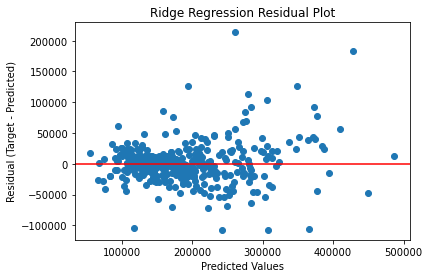

In [373]:
# Creating a array of alphas to be tested
r_alphas=np.logspace(0, 2, 1000)

# Instantiate ridge_cv as RidgeCV
ridge_cv=RidgeCV(alphas=r_alphas, cv=5)

# Fit Using RidgeCV
ridge_cv.fit(X_train_scaled, y_train)

# Print the best alpha
print(f'Best alpha is {ridge_cv.alpha_}')

# Instantiate ridge_model as Ridge using best alpha from ridge_cv
ridge_model = Ridge(alpha=ridge_cv.alpha_)

# Fit using Ridge
ridge_model.fit(X_train_scaled, y_train)

# Assign cv
cv_value = 5

# R2 Score
print('\nUsing R2:-')
# Training Set Using OLS
print('Train R2 Score (OLS): ', ridge_model.score(X_train_scaled, y_train))

# Training Set Using Cross-Validation
print('Train R2 Score (OLS with CV): ', 
      cross_val_score(ridge_model, X_train_scaled, y_train, cv = cv_value).mean())

# Validation Set Using OLS
print('Validation R2 Score: ', ridge_model.score(X_val_scaled, y_val))


# Using RMSE
print('\nUsing RMSE:-')
# Training Set Using OLS
print('Train RMSE Score (OLS): ', metrics.mean_squared_error(y_train, ridge_model.predict(X_train_scaled))**0.5)

# Training Set Using Cross-Validation
print('Train RMSE Score (OLS with CV): ', 
      abs(cross_val_score(ridge_model, X_train_scaled, y_train, cv = cv_value, scoring='neg_root_mean_squared_error').mean()))

# Validation Set Using OLS
print('Validation RMSE Score (OLS): ', metrics.mean_squared_error(y_val, ridge_model.predict(X_val_scaled))**0.5)

# Plot Residual Plot
residual_plot(model = ridge_model, predictors = X_val_scaled, target = y_val,
              fig_title='Ridge Regression Residual Plot')

output_result('Ridge', 
              model_features_list,
              ridge_model.score(X_train_scaled, y_train),
              cross_val_score(ridge_model, X_train_scaled, y_train, cv = cv_value).mean(),
              ridge_model.score(X_val_scaled, y_val),
              metrics.mean_squared_error(y_train, ridge_model.predict(X_train_scaled))**0.5,
              abs(cross_val_score(ridge_model, X_train_scaled, y_train, cv = cv_value, scoring='neg_root_mean_squared_error').mean()),
              metrics.mean_squared_error(y_val, ridge_model.predict(X_val_scaled))**0.5
             )

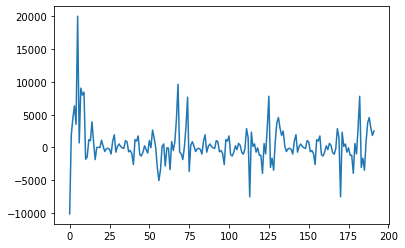

In [374]:
plt.plot(ridge_model.coef_)

In [352]:
for x, y in zip(X_train.columns, ridge_model.coef_):
    print (f'{x}: {y}')

Age_Sold: -9669.823911292986
Lot Area: 1278.0415593453783
1st Flr SF: 5234.710396426194
Total Bsmt SF: 7369.899775214311
Mas Vnr Area: 4188.274916806938
Gr Liv Area: 18430.30861152667
TotRms AbvGrd: 143.52967312288925
No Of Bath: 8676.327479402771
Garage Area: 8533.358771959818
Fireplaces: 8296.896871202736
Misc Val: -3498.139347218807
Land Slope_Gtl: -1699.9060479098807
Land Slope_Mod: 1492.5638148144408
Land Slope_Sev: 865.7443888668632
Lot Area Land Slope_Gtl: 3874.9697524270196
Lot Area Land Slope_Mod: 120.36986284598069
Lot Area Land Slope_Sev: -2123.0170455208736
Land Slope_Gtl Land Slope_Mod: 0.0
Land Slope_Gtl Land Slope_Sev: 0.0
Land Slope_Mod Land Slope_Sev: 0.0
Log_Lot Area Land Slope_Sev: 902.0928654340258
Neighborhood_Blmngtn: 813.8414689472206
Neighborhood_Blueste: -1183.2806778099161
Neighborhood_BrDale: -1534.9001433388999
Neighborhood_BrkSide: -2183.6065470295885
Neighborhood_ClearCr: -1042.120639932629
Neighborhood_CollgCr: -64.53774896108749
Neighborhood_Crawfor: 365

#### Create Lasso Regression Model

In [375]:
# Creating a array of alphas to be tested
l_alphas = np.logspace(-5,5,1000)

#Instantiate lasso_cv as LassoCV
lasso_cv = LassoCV(alphas = l_alphas, cv=5, max_iter=10000)

# Fit using LassoCV
lasso_cv.fit(X_train_scaled, y_train)

# Print the best alpha
print(f'Best alpha is {lasso_cv.alpha_}')

# Instantiate lasso_model as Lasso using best alpha from lasso_cv
lasso_model = Lasso(alpha=lasso_cv.alpha_, max_iter = 10000)

# Fit using Lasso
lasso_model.fit(X_train_scaled, y_train)

# Assign cv
cv_value = 5


# R2 Score
print('\nUsing R2:-')
# Training Set Using OLS
print('Train R2 Score (OLS): ', lasso_model.score(X_train_scaled, y_train))

# Training Set Using Cross-Validation
print('Train R2 Score (OLS with CV): ', 
      cross_val_score(lasso_model, X_train_scaled, y_train, cv = cv_value).mean())

# Validation Set Using OLS
print('Validation R2 Score: ', lasso_model.score(X_val_scaled, y_val))


# Using RMSE
print('\nUsing RMSE:-')
# Training Set Using OLS
print('Train RMSE Score (OLS): ', metrics.mean_squared_error(y_train, lasso_model.predict(X_train_scaled))**0.5)

# Training Set Using Cross-Validation
print('Train RMSE Score (OLS with CV): ', 
      abs(cross_val_score(lasso_model, X_train_scaled, y_train, cv = cv_value, scoring='neg_root_mean_squared_error').mean()))

# Validation Set Using OLS
print('Validation RMSE Score (OLS): ', metrics.mean_squared_error(y_val, lasso_model.predict(X_val_scaled))**0.5)

# Plot Residual Plot
residual_plot(model = lasso_model, predictors = X_val_scaled, target = y_val,
              fig_title='Lasso Regression Residual Plot')

output_result('Lasso',
              model_features_list,
              lasso_model.score(X_train_scaled, y_train),
              cross_val_score(lasso_model, X_train_scaled, y_train, cv = cv_value).mean(),
              lasso_model.score(X_val_scaled, y_val),
              metrics.mean_squared_error(y_train, lasso_model.predict(X_train_scaled))**0.5,
              abs(cross_val_score(lasso_model, X_train_scaled, y_train, cv = cv_value, scoring='neg_root_mean_squared_error').mean()),
              metrics.mean_squared_error(y_val, lasso_model.predict(X_val_scaled))**0.5
             )

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1085342664.9399414, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3610236328.6330566, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7300292360.166382, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180282233536.4306, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185993558415.07892, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191577094993.40747, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298823284432.4564, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301772544558.35693, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304653831267.2543, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360537105200.26794, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362106939249.35156, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363643054653.2697, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393981038628.0066, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 394849885470.70593, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395701025709.17865, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412713607931.38745, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 413206735415.82007, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 413690123336.4796, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 423421679156.4734, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 423705768660.8222, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 423984371129.7022, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Co

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 429620661618.9087, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 429785778516.38776, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 429947741492.23486, tolerance: 788631697.3681214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: 

KeyboardInterrupt: 

In [ ]:
plt.plot(lasso_model.coef_)

In [ ]:
for x, y in zip(X_train.columns, lasso_model.coef_):
    print (f'{x}: {y}')

### Make Prediction Using "Test.csv" for Kaggle Submission

In [ ]:
# Prep data
test_X = clean_prep(test)
test_X = test_X[model_features_list].copy()

In [ ]:
# Checking for Null values
temp = test_X.isnull().sum()
for i in range(len(temp)):
    print(temp.index[i], ': ',  temp[i], ', Percentage of All Rows', ": ", temp[i]/test_X.shape[0], ' Type: ', test_X.dtypes[i])

In [ ]:
#Fill missing row with mean
if 'Mas Vnr Area' in test_X.columns:
    test_X['Mas Vnr Area'] = test_X['Mas Vnr Area'].fillna(X_train['Mas Vnr Area'].mean())

# One Hot Encoding
test_X_OHE = pd.get_dummies(data=test_X, drop_first=False)

In [ ]:
# Features in trained model but not in test data (after One Hot Encoding)
missing_feature_in_test = []
for feature in X_train.columns:
    if feature not in test_X_OHE.columns:
        missing_feature_in_test.append(feature)
        
# Features in trained model but not in test data (after One Hot Encoding)
missing_feature_in_train = []
for feature in test_X_OHE.columns:
    if feature not in X_train.columns:
        missing_feature_in_train.append(feature)

In [ ]:
# Create new features which are in training data model but not in test data and assign 0 to them
for feature in missing_feature_in_test:
       test_X_OHE[feature] = 0

# Drop features in test data which is not in trained model
test_X_OHE.drop(columns=missing_feature_in_train, inplace=True)

# Scale using StandardScaler
test_X_OHE_scaled = ss.transform(test_X_OHE)

In [ ]:
# Predict using test data using ridge regression
y_test_predict = np.log(ridge_model.predict(test_X_OHE_scaled))

# Put prediction results into dataframe with Id column
test_result = pd.DataFrame(y_test_predict, columns = ['SalePrice'])
test_result['Id'] = test['Id']

# Write to csv file
test_result.to_csv('..\datasets\kaggle_submission_ridge.csv', index = False, columns=['Id', 'SalePrice'])

In [ ]:
# Predict using test data using lasso regression
y_test_predict = np.log(lasso_model.predict(test_X_OHE_scaled))

# Put prediction results into dataframe with Id column
test_result = pd.DataFrame(y_test_predict, columns = ['SalePrice'])
test_result['Id'] = test['Id']

# Write to csv file
test_result.to_csv('..\datasets\kaggle_submission_lasso.csv', index = False, columns=['Id', 'SalePrice'])

### Conclusion

### Recommendations